**Empirical Asset Pricing with Individual Stocks on the JSE: Betas Versus Characteristics**

# Preparation

## Load any required modules

In [1]:
import linearmodels
import json
import random
import pandas as pd
import numpy as np
import seaborn as sn
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
from datetime import datetime
from scipy import stats
from tqdm import tqdm
from scipy.stats.mstats import spearmanr
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS

In [104]:
plt.rcParams["figure.figsize"] = (5, 3.5) # Define the size of figures

In [3]:
random.seed(12345)
print(random.random())

0.41661987254534116


## Define Functions 

Define the "replacer" funtion to replace the consecutive 0s with np.NaN in each column

In [105]:
def replacer(l,target_val=0,replace_val=np.NaN,repeat_max=10):
    #repeat_max = n (consecutive 0s over 10 times will be replaced with NAs)
    counter = 0
    new_l = []
    for e in l:
        if e == target_val: counter += 1
        else:
            counter = 0

        if counter > repeat_max:
            new_l.append(replace_val)
        else:
            new_l.append(e)

    return new_l

Define Newey-West t-test For Time-Series Data

In [106]:
def NW_ttest(ret,h0):
  T = len(ret)
  lag = int(4*(T/100)**(2/9))
  vv = np.var(ret)

  for l in range(0,lag):
      cc=np.cov(ret[0:(len(ret)-l)].T,ret[l:len(ret)].T)[0,1]
      vv=vv+2*(1-(l+1)/lag)*cc
      t=(np.mean(ret)-h0)/np.sqrt(vv)*np.sqrt(T)
  
  return t

Define the unlist function

In [107]:
def flatten(t):
    return [item for sublist in t for item in sublist]

GRS test for joint Alpha Distribution

In [108]:
"""
Function GRS_test(factor, resid, alpha) is to conduct GRS test according 
to Gibbons, Ross & Shanken(1989) to receive GRS-statistic and p-value.

H0: alpha1=alpha2=...=alphaN=0

Parameters:
  T = number of months
  N = number of portfolios/stocks
  L = number of factors

Inputs:
  factor: matrix of FF factors with shape (T, L)
  resid: matrix of residuals with shape (T, N)
  alpha: matrix of intercepts with shape (N, 1)

Outputs:
  f_grs: GRS-statistic
  p_grs: P-value

"""
from scipy.stats import f

def GRS_test(factor, resid, alpha):
    N = resid.shape[1]        
    T = resid.shape[0]       
    L = factor.shape[1]      

    if (T-N-L) < 0:
        print('can not conduct GRS test because T-N-L<0')
        return

    factor = np.asmatrix(factor)                   # factor matrix (T, L)
    resid = np.asmatrix(resid)                     # residual matrix (T, N)
    alpha = np.asmatrix(alpha).reshape(N, 1)       # intercept matrix (N, 1)

    mean_return_factor = (factor.mean(axis=0))

    # covariance matrix of residuals
    cov_resid = (resid.T * resid) / (T-L-1)
    # covariance matrix of factors
    cov_factor = ((factor - mean_return_factor).T * (factor - mean_return_factor)) / (T-1)

    mean_return_factor = mean_return_factor.reshape(L, 1)

    # GRS statistic
    # pinv.linalg.pinv is a pseudoinverse not a real one, for calculating the real inverse we need to use np.linalg.inv
    # However, the structure of resids matrix is oftenly a Singular matrix (one for which a inverse matrix does not exis)
    f_grs = float((T/N) * ((T-N-L)/(T-L-1)) * ((alpha.T * np.linalg.pinv(cov_resid) * alpha) / (1 + mean_return_factor.T * np.linalg.inv(cov_factor) * mean_return_factor)))

    # p-value
    p_grs = 1 - stats.f.cdf(f_grs, N, (T-N-L))

    return f_grs, p_grs


In [109]:
ols_model = LinearRegression()

## Import Data

In [110]:
# Import excessive market return (J203T - Rf)
df_MR = pd.read_csv('df_MR.csv')
df_MR.Dates = df_MR.Dates.apply(lambda x:x[:10])
df_MR.set_index('Dates',inplace=True)

Import risk-free rate (91-day T-Bill)

In [111]:
df_RF = pd.read_csv('df_RF.csv',index_col=0)

Import listed stock returns on the JSE

In [112]:
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])

Drop the columns of stock returns that full of 0s or NAs and replace consecutive 0s with NAs

In [113]:
df_SR = df_SR.loc[:, (df_SR != 0).any(axis=0)].astype(np.float64)
df_SR = df_SR.dropna(axis = 0, how = 'all')
# df_SR = df_SR.apply(replacer)

Calculate the Excess Stock Returns 

In [114]:
df_Ex_SR = df_SR-df_RF.values

Import the Factor Realizations (Mimicking portfolio returns)

In [115]:
df_FF3 = pd.read_csv('df_FF3.csv')
df_FF3.Dates = df_FF3.Dates.apply(lambda x: x[:10])
df_FF3.set_index('Dates',inplace=True)

In [116]:
df_FF4 = pd.read_csv('df_FF4.csv')
df_FF4.Dates = df_FF4.Dates.apply(lambda x:x[:10])
df_FF4.set_index('Dates',inplace=True)

In [117]:
df_FF5 = pd.read_csv('df_FF5.csv')
df_FF5.Dates = df_FF5.Dates.apply(lambda x:x[:10])
df_FF5.set_index('Dates',inplace=True)

Import Firm Characteristics 

In [118]:
df_ln_Size = pd.read_csv('df_ln_Size.csv')
df_ln_Size.Dates = df_ln_Size.Dates.apply(lambda x:x[:10])
df_ln_Size.set_index('Dates',inplace=True)

In [119]:
df_PE = pd.read_csv('df_std_PE.csv')
df_PE.Dates = df_PE.Dates.apply(lambda x:x[:10])
df_PE.set_index('Dates',inplace=True)

In [120]:
df_OP = pd.read_csv('df_std_OP.csv')
df_OP.Dates = df_OP.Dates.apply(lambda x:x[:10])
df_OP.set_index('Dates',inplace=True)

In [121]:
df_INV = pd.read_csv('df_std_INV.csv')
df_INV.Dates = df_INV.Dates.apply(lambda x:x[:10])
df_INV.set_index('Dates',inplace=True)

Import 18 double-sorted portfolios returns

In [122]:
df_18_PR = pd.read_csv('df_18_PR.csv')
df_18_PR.Dates = df_18_PR.Dates.apply(lambda x:x[:10])
df_18_PR.set_index('Dates',inplace=True)

Import Firm Characteristics of 18 double-sorted portfolios

In [123]:
df_18_std_Size = pd.read_csv('df_18_std_size.csv')
df_18_std_Size.Dates = df_18_std_Size.Dates.apply(lambda x:x[:10])
df_18_std_Size.set_index('Dates',inplace=True)

In [124]:
df_18_std_PE = pd.read_csv('df_18_std_PE.csv')
df_18_std_PE.Dates = df_18_std_PE.Dates.apply(lambda x:x[:10])
df_18_std_PE.set_index('Dates',inplace=True)

In [125]:
df_18_std_OP = pd.read_csv('df_18_std_OP.csv')
df_18_std_OP.Dates = df_18_std_OP.Dates.apply(lambda x:x[:10])
df_18_std_OP.set_index('Dates',inplace=True)

In [126]:
df_18_std_INV = pd.read_csv('df_18_std_INV.csv')
df_18_std_INV.Dates = df_18_std_INV.Dates.apply(lambda x:x[:10])
df_18_std_INV.set_index('Dates',inplace=True)

# Simulation (CAPM)

## South African Sample (N=500, T=5215days)

To evaluate the samll sample properties of the IV method, a battery of simulations are conducted using the parameters matched to real data.

For each stock, we fit CAPM model regressions to esimate constant betas and residual return standard deviation (sigmas);
Then we match the simulation paramters (mean & standard deviation) to the distribution of these parametes in the real data.

In [127]:
# the following codes estimate the market beta and the residual return standard deviations (sigmas)
df_Ex_SR_tmp = df_Ex_SR.loc[df_MR.index,:] # keep the length of stock returns equal to market factor returns

all_betas = []
all_sigmas = []

betas = []
sigmas = []
labels = []
# j is listed stock on the JSE
for j in tqdm(df_Ex_SR_tmp.columns):
    # drop the NA returns and only keep the date that have valid returns
    df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
    # the regression will be run only when it has at least 10 observations
    if len(df_index) > 10:
        ols = sm.OLS(df_Ex_SR_tmp.loc[df_index,j].values.astype(np.float64), 
        sm.add_constant(df_MR.loc[df_index,:].values.astype(np.float64)))
        res = ols.fit()
        b = list(res.params)
        s = np.std(res.resid)
        betas.append(b)
        sigmas.append(s)
        labels.append(j)

all_betas.append(pd.DataFrame(betas))
all_sigmas.append(pd.DataFrame(sigmas))


100%|██████████| 740/740 [00:01<00:00, 439.90it/s]


In [128]:
# The following are market betas
df_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
df_betas.columns = ['Intercepts','MKT','Stocks']
df_betas = df_betas.set_index('Stocks')
df_betas = df_betas[(np.abs((df_betas-df_betas.mean())/df_betas.std()) <= 3).all(axis=1)]
df_betas

,Intercepts,MKT
Stocks,,
ABC.SJ.Equity,-0.000527,0.012906
ABI.SJ.Equity,-0.000128,0.065382
ABK.SJ.Equity,-0.001182,0.182993
ABR.SJ.Equity,-0.001066,-0.022444
ABU.SJ.Equity,-0.000235,0.010576
...,...,...
ZPT.SJ.Equity,-0.001798,0.079832
ZRNHDG.SJ.Equity,-0.000197,0.012835
ZRNPLY.SJ.Equity,-0.000181,0.000153


In [129]:
# The following are residual return standard deviations (sigmas)
df_sigmas = pd.concat([all_sigmas[0], pd.DataFrame(labels)], axis = 1)
df_sigmas.columns = ['sigmas','Stocks']
df_sigmas = df_sigmas.set_index('Stocks')
df_sigmas = df_sigmas[(np.abs((df_sigmas-df_sigmas.mean())/df_sigmas.std()) <= 3).all(axis=1)]
df_sigmas

,sigmas
Stocks,
ABC.SJ.Equity,0.019822
ABI.SJ.Equity,0.005701
ABK.SJ.Equity,0.044608
ABR.SJ.Equity,0.025737
ABU.SJ.Equity,0.008763
...,...
ZPT.SJ.Equity,0.065835
ZRNHDG.SJ.Equity,0.002140
ZRNPLY.SJ.Equity,0.000040


In [130]:
# The mean and standard deviation of real betas
m_all_betas = np.mean(df_betas.iloc[:,1])
sd_all_betas = np.std(df_betas.iloc[:,1])
print(m_all_betas, sd_all_betas)

0.16514471061904212 0.21161089569068053


In [131]:
# # The mean and standard deviation of real sigmas
m_all_sigmas = np.mean(df_sigmas.iloc[:,0].astype('float64'))
sd_all_sigmas = np.std(df_sigmas.iloc[:,0].astype('float64'))
print(m_all_sigmas, sd_all_sigmas)

0.01840973708300509 0.013629287305736423


### Simulated betas and sigmas are fixed during 100 repetitions

The study conducts simulations with the cross-sectional size of N=500 stocks. We randomly generat daily returns using the following procedures:

Step-1: For each stock, we randomly generate a beta and a standard deviations of return residuals from normal distributions.

In [132]:
# How many cross-sectional stocks in the simulation sample
N = 500

Simulate market betas:
The mean and standard deviation of simulated betas are set to be the same as the real betas

In [133]:
sim_betas_tmp = []
sim_betas_tmp.append(np.random.normal(loc = m_all_betas,scale = sd_all_betas, size= N ))
np.mean(sim_betas_tmp), np.std(sim_betas_tmp)

(0.1616166544129436, 0.20586163041355918)

In [134]:
# Print simulated betas
sim_betas = pd.DataFrame(sim_betas_tmp)
sim_betas

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-0.120941,-0.053855,0.51737,0.264765,0.204238,-0.117302,0.281503,0.414601,0.266181,0.355493,...,0.562139,0.166633,0.075888,0.203044,0.221907,0.427529,0.379233,0.086623,0.119508,0.151663


In [135]:
# Simulate the residual return standard deviations (sigmas)
sim_sigmas_tmp = []
sim_sigmas_tmp.append(np.random.normal(loc = m_all_sigmas,scale = sd_all_sigmas, size= N ))
np.mean(sim_sigmas_tmp), np.std(sim_sigmas_tmp)

(0.01840224389488976, 0.013366384556341739)

In [136]:
# Print simulated sigmas
sim_sig_res = pd.DataFrame(sim_sigmas_tmp).abs()
sim_sig_res

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.009751,0.014747,0.011134,0.019603,0.011949,0.014193,0.017148,0.032161,0.024199,0.007103,...,0.01456,0.028848,0.018061,0.015987,0.00765,0.023453,0.025736,0.002375,0.016418,0.019419


### Simulated market, stock and residual returns are changable during 100 repetitions

Step-2: For each day, we randomly draw market excess return from a normal distribution with mean and standard deviation equal to the real mean and standard deviation from the sample data

In [137]:
# Print the mean and standard deviation of real market return
mean_MKT = np.mean(df_MR.iloc[:,0])
sd_MKT = np.std(df_MR.iloc[:,0])
print(mean_MKT, sd_MKT)

0.0002807670182166827 0.011549088535812713


In [138]:
# Simulated market factor returns
sim_MKT_tmp = []
sim_MKT_tmp.append(np.random.normal(loc = mean_MKT,scale = sd_MKT, size= len(df_MR)))
print(np.mean(sim_MKT_tmp), np.std(sim_MKT_tmp))

-4.9695325893963804e-05 0.011678647425920178


In [139]:
# Print simulated market returns
sim_MKT = pd.DataFrame(sim_MKT_tmp).T
sim_MKT.index = df_MR.index
sim_MKT.columns = ['RM-RF']
sim_MKT

,RM-RF
Dates,
2000-01-05,0.009979
2000-01-06,-0.016818
2000-01-07,0.020815
2000-01-10,-0.012652
2000-01-11,0.019696
...,...
2019-12-25,0.018061
2019-12-26,0.009585
2019-12-27,-0.008281


Step-3: For each stock, we then randomly generate daily residual return from a normal distribution with mean zero and standard deviation equal to the value generate in step-1, i.e. sim_sigmas

In [140]:
res_return = pd.DataFrame(np.zeros((len(sim_MKT), len(sim_sig_res.columns))))
for j in range(len(sim_sig_res.columns)):
    res_return.iloc[:,j] = np.random.normal(loc = 0,scale = sim_sig_res[j], size= len(sim_MKT))
res_return

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.002427,0.011027,-0.010037,0.020248,0.005154,-0.026079,-0.001819,0.074988,0.056772,-0.005319,...,-9.108083e-03,0.023918,-0.016589,-0.012250,-0.008041,0.003355,-0.016785,-0.005129,0.024499,0.018650
1,-0.009749,0.025150,0.011814,0.015768,0.008584,0.024619,0.019442,-0.000174,-0.028190,0.007442,...,1.128231e-02,-0.019156,-0.015334,0.013922,0.004367,0.007835,0.049801,0.001500,0.005787,0.027334
2,0.001397,0.001452,-0.026400,0.017887,0.003363,-0.015240,0.013293,0.014859,-0.015975,-0.003804,...,2.658394e-02,-0.022099,0.012999,0.002482,0.002839,0.000748,-0.011856,-0.002405,-0.004342,-0.039381
3,0.013004,-0.020131,0.006723,0.015183,0.002698,0.002049,0.002269,-0.006357,-0.022567,0.011889,...,-7.575026e-03,-0.037511,0.006853,-0.002887,0.003553,-0.004425,0.006861,-0.002781,-0.003227,-0.009783
4,0.008902,-0.014836,0.004070,0.019010,0.021067,-0.008559,-0.017953,-0.030926,-0.022970,-0.018769,...,4.959315e-03,0.036569,-0.001940,-0.010471,0.015233,0.038209,-0.008820,0.002020,0.013408,0.023048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5210,0.010104,0.005503,0.002279,-0.001205,0.012686,0.018178,-0.020033,-0.004376,0.004877,-0.006688,...,2.957968e-07,-0.002958,-0.012677,-0.003710,-0.000075,-0.007510,0.026962,-0.000420,0.005809,0.011446
5211,-0.001763,0.013129,0.004918,-0.014956,-0.006308,-0.015442,0.028058,-0.011578,-0.033322,-0.001912,...,-2.354131e-02,0.010711,-0.004054,0.015447,0.002808,-0.002039,0.064112,-0.002421,-0.043898,-0.010718
5212,-0.006906,0.007805,-0.019331,0.002488,-0.021198,0.007038,-0.006815,0.003618,0.024955,0.005733,...,1.164903e-02,0.016199,-0.016024,0.016680,-0.006229,0.015164,-0.008912,0.001829,-0.010393,-0.016365
5213,-0.011712,0.002378,0.020507,0.002855,0.027431,0.009355,0.015676,0.009528,0.030329,0.002364,...,-1.347989e-02,0.007641,-0.009459,0.007394,-0.014692,-0.000002,0.006478,-0.001151,0.017674,-0.003301


Step-4: For stock i, we compute its excess return as beta,i*MKT,t + episiloni,t

In [141]:
sim_SR = (np.mat(sim_MKT.iloc[:,0]).T*np.mat(sim_betas.iloc[0,:].values)) + res_return
sim_SR = pd.DataFrame(sim_SR)
sim_SR.index = df_Ex_SR.index
sim_SR

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,0.001220,0.010490,-0.004873,0.022890,0.007192,-0.027250,0.000990,0.079125,0.059428,-0.001771,...,-0.003498,0.025580,-0.015832,-0.010224,-0.005826,0.007622,-0.013001,-0.004264,0.025692,0.020163
2000-01-06,-0.007715,0.026055,0.003113,0.011315,0.005149,0.026592,0.014708,-0.007147,-0.032666,0.001463,...,0.001828,-0.021959,-0.016610,0.010507,0.000635,0.000645,0.043423,0.000043,0.003777,0.024784
2000-01-07,-0.001121,0.000331,-0.015631,0.023399,0.007614,-0.017682,0.019153,0.023489,-0.010434,0.003596,...,0.038285,-0.018630,0.014578,0.006709,0.007458,0.009647,-0.003962,-0.000601,-0.001855,-0.036224
2000-01-10,0.014535,-0.019449,0.000177,0.011833,0.000114,0.003533,-0.001292,-0.011602,-0.025935,0.007391,...,-0.014687,-0.039620,0.005893,-0.005456,0.000745,-0.009835,0.002062,-0.003877,-0.004739,-0.011702
2000-01-11,0.006520,-0.015897,0.014260,0.024224,0.025090,-0.010870,-0.012409,-0.022760,-0.017728,-0.011767,...,0.016031,0.039851,-0.000445,-0.006472,0.019604,0.046629,-0.001350,0.003726,0.015762,0.026035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,0.007920,0.004531,0.011623,0.003577,0.016375,0.016059,-0.014949,0.003112,0.009684,-0.000267,...,0.010153,0.000052,-0.011307,-0.000043,0.003933,0.000211,0.033811,0.001144,0.007968,0.014185
2019-12-26,-0.002923,0.012613,0.009877,-0.012419,-0.004350,-0.016566,0.030756,-0.007604,-0.030770,0.001495,...,-0.018153,0.012308,-0.003327,0.017393,0.004935,0.002059,0.067747,-0.001591,-0.042753,-0.009264
2019-12-27,-0.005905,0.008251,-0.023616,0.000296,-0.022889,0.008009,-0.009146,0.000184,0.022750,0.002789,...,0.006994,0.014819,-0.016652,0.014999,-0.008066,0.011623,-0.012052,0.001112,-0.011383,-0.017621


In [142]:
# The study assumes 21 days per month, T = 252 days corresponds to one year
months = []
periods = int(len(sim_SR)/21)+1
mons = pd.date_range(start=sim_SR.index[0], periods = periods, freq='M').astype(str).str[:7]
for i in range(periods): 
    m = mons[i]
    months.append(np.repeat(m,21))

Sum simulated daily stock returns to monthly returns. They are addable because they are log returns. In line with Jegadeesh et al. (2019), the simulation first estimate beta on a daily basis and then estimate risk premium on a monthly basis.

In [143]:
# Monthly version of simulated stock returns
m_sim_SR = sim_SR
m_sim_SR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_SR = m_sim_SR.groupby('month').sum()
sim_SR = sim_SR.drop(['month'], axis = 1)
m_sim_SR = m_sim_SR.iloc[:-1,:]
m_sim_SR

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
month,,,,,,,,,,,,,,,,,,,,,
2000-01,0.001531,-0.028424,-0.002902,0.079857,-0.054489,-0.096885,-0.035842,0.056059,-0.214096,-0.024709,...,0.074488,-0.195738,0.033998,-0.034232,0.025947,-0.128265,0.114645,-0.015686,0.052927,-0.018223
2000-02,0.036223,0.084693,-0.016648,0.033958,0.014582,-0.016123,0.118472,-0.288789,-0.112099,0.010150,...,-0.021373,-0.114237,0.114452,0.009823,-0.055967,-0.055767,-0.110714,-0.009402,0.120688,-0.082239
2000-03,0.028675,-0.068618,0.072701,-0.046068,-0.088977,0.026085,-0.124727,0.064321,-0.046448,-0.032778,...,0.010393,-0.096451,-0.025835,-0.044221,-0.039605,-0.005697,-0.038869,0.007910,0.052757,-0.055624
2000-04,-0.026356,0.165226,0.045240,0.000196,-0.006608,0.033846,0.060116,0.060240,0.108347,-0.009371,...,0.174526,0.128696,-0.012891,0.063563,-0.002149,0.106865,0.116446,-0.017250,0.059798,0.099838
2000-05,-0.002312,0.110251,-0.069183,-0.075178,-0.064231,-0.036253,-0.077381,-0.083427,0.034272,0.034840,...,-0.084022,0.072674,0.014257,0.114108,-0.051912,0.028156,0.106434,-0.009285,0.061503,-0.116736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04,-0.009586,0.050103,0.012646,0.127350,0.083151,-0.064802,0.029845,0.078069,0.081330,0.017072,...,-0.037890,-0.269730,-0.013027,-0.066709,-0.024344,0.173812,0.141056,-0.014301,0.054544,-0.113454
2020-05,0.018870,-0.094767,0.113221,0.012161,0.109863,-0.091095,0.064792,-0.111987,0.083102,0.043568,...,0.210106,-0.057735,0.040122,0.036143,-0.007619,0.047363,-0.081146,0.021306,-0.142961,0.007937
2020-06,-0.017629,-0.022170,0.133671,-0.117889,-0.096006,0.018614,-0.003211,0.039211,0.031172,0.027294,...,0.080755,-0.138204,0.020991,0.027933,0.067128,0.036782,0.303663,0.017497,-0.069473,0.037555


In [144]:
# Monthly version of simulated stock returns
m_sim_MKT = sim_MKT
m_sim_MKT['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_MKT = m_sim_MKT.groupby('month').sum()
sim_MKT = sim_MKT.drop(['month'], axis = 1)
m_sim_MKT = m_sim_MKT.iloc[:-1,:]
m_sim_MKT

,RM-RF
month,
2000-01,-0.013182
2000-02,-0.019690
2000-03,-0.006489
2000-04,0.055393
2000-05,-0.062482
...,...
2020-04,-0.051336
2020-05,0.099736
2020-06,0.130063


In [145]:
# Monthly version of real market returns
m_MR = df_MR
m_MR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_MR = m_MR.groupby('month').sum()
df_MR = df_MR.drop(['month'], axis = 1)
m_MR = m_MR.iloc[:-1,:]
m_MR

,MR_RF
month,
2000-01,0.0154
2000-02,-0.0955
2000-03,-0.0024
2000-04,-0.0693
2000-05,-0.0119
...,...
2020-04,-0.0695
2020-05,0.0382
2020-06,-0.0010


### FM-OLS (Constant Betas)

Try to run FM OLS (without rolling windows) to estimate risk premiums of market factor. Use the factor model in the linearmodel module, however, this function does not allow for time-varying betas, so the FM two-step regression would yield the same results as cross-sectional regression.

In [146]:
from linearmodels.asset_pricing.model import LinearFactorModel
model_ols = LinearFactorModel(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                500   R-squared:                      0.0179
No. Factors:                          1   J-statistic:                    554.46
No. Observations:                  5215   P-value                         0.0431
Date:                  Mon, May 02 2022   Distribution:                chi2(499)
Time:                          13:16:38                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
RM-RF      -2.126e-05     0.0002    -0.1250     0.9006     -0.0004      0.0003
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

In [147]:
# Print the ex-ante and ex-post biases of FM OLS (without rolling windows) regression
print("ex-ante bias(%):" + str(((res_ols.risk_premia-mean_MKT)/mean_MKT*100).values))
print("ex-post bias(%):" + str(((res_ols.risk_premia-np.mean(sim_MKT, axis = 0))/np.mean(sim_MKT, axis = 0)*100).values))

ex-ante bias(%):[-107.57331656]
ex-post bias(%):[-57.21252509]


### FM-OLS (Time-Varying Betas)

Step-5: For the first-stage regression of FM in the simulation, we estimate betas using time series regression of CAPM model

In [148]:
# how many years in the rolling window periods
n = 3

In [149]:
# This cell defines the rolling estimation window (n years) and 
# rebalance frequency (monthly) for the first stage of FM regression
holding = 21 # 21 days per month
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

211 756


The first stage of FM OLS regression (Beta Estimates)

In [150]:
# Estimate market betas by regressing sim_SR on sim_MKT
all_betas = []

# i is time in periods
for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []
    # j is a listed stock on the JSE
    for j in sim_SR.columns:      
        lag = int(4*((len(sim_SR.loc[:,j]))/100)**(1/9))
        OLS = sm.OLS(sim_SR_tmp.loc[:,j].values.astype(np.float64), sm.add_constant(sim_MKT_tmp.values.astype(np.float64)))
#         res = OLS.fit()
        res = OLS.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
        b = list(res.params)
        betas.append(b)

    df_betas = pd.DataFrame(betas).rename(columns={0:'Intercepts',1:'MKT'})
    all_betas.append(df_betas)

100%|██████████| 211/211 [00:51<00:00,  4.09it/s]


In [151]:
# Print the betas and intercepts for one period
all_betas[0]

,Intercepts,MKT
0,-0.000590,-0.093906
1,0.000349,-0.000145
2,-0.000362,0.514303
3,0.000304,0.354134
4,-0.000303,0.238642
...,...,...
495,0.000417,0.499730
496,0.000813,0.287127
497,-0.000049,0.079062
498,0.000456,0.041285


In [152]:
# Test the correlation between estimated betas and simulated betas
corr_betas_true = []

for i in range(len(all_betas)):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_betas_true.append(corr)

print(np.mean(corr_betas_true), stats.ttest_1samp(corr_betas_true, 0.0)[0])

0.9469988780447998 3803.993667106844


In [153]:
# This cell redefine the daily regression to monthly regression
# by simple change the holding periods from "21 days" to "1 month"
holding = 1 
rollingW = holding *n*12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

211 36


The second stage of FM OLS regression (factor premium estimates)

In [154]:
# This cell estimate the risk premiums (lambdas) of market factor and
# the residual returns.
all_lambdas_OLS = []
all_resids_OLS = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):   
    i = int(index_times.index(k)/holding)
    OLS = sm.OLS(m_sim_SR_tmp_T.loc[:,k], 
                 sm.add_constant(all_betas[i].loc[:,"MKT"].astype(np.float64)))
    res = OLS.fit()
    l = list(res.params)
    r = list(res.resid)
    lambdas.append(l)
    resids.append(r)
        
all_lambdas_OLS.append(pd.DataFrame(lambdas))
all_resids_OLS.append(pd.DataFrame(resids))

100%|██████████| 211/211 [00:00<00:00, 719.69it/s]


In [155]:
# Print risk premiums of Market factor and the intercepts
all_lambdas_OLS[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,0.008201,0.049897
1,-0.006176,-0.001528
2,0.004256,0.073093
3,-0.000379,0.073124
4,-0.002183,-0.048453
...,...,...
206,0.003291,0.049838
207,0.001605,-0.054248
208,0.002404,0.080428
209,0.001882,0.121903


In [156]:
# Print residual returns
all_resids_OLS = pd.DataFrame(all_resids_OLS[0].T)
all_resids_OLS

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,0.049571,-0.010327,0.009156,-0.075264,0.013365,-0.018689,0.049415,-0.010281,0.030718,-0.014415,...,-0.039104,0.045705,0.016089,0.031166,-0.018496,-0.043018,-0.018642,0.027715,-0.002561,-0.020197
1,-0.003839,0.000427,-0.009273,0.008428,-0.036774,0.143636,0.018846,0.120373,-0.069277,0.060208,...,0.056288,-0.085254,-0.087416,0.134216,0.028358,0.113942,0.041447,-0.087109,-0.008648,-0.042466
2,-0.054115,0.005772,0.036648,-0.022600,-0.001975,0.002334,0.079043,0.029783,0.039977,-0.029869,...,0.084467,-0.051129,-0.011756,-0.003353,0.013709,0.006001,0.037343,0.071770,0.072754,-0.035892
3,0.122330,0.031766,0.003359,-0.053290,0.211118,-0.034879,-0.054262,0.038825,-0.061663,-0.279058,...,0.005072,0.022410,-0.058050,-0.074208,0.026302,-0.043935,0.136728,-0.005767,-0.143136,-0.066336
4,0.012167,0.067318,-0.047486,0.130943,-0.069019,0.093738,0.029260,-0.036579,0.044434,-0.081896,...,-0.030539,-0.032576,-0.050088,0.049591,0.095605,-0.041584,0.090307,0.094047,-0.117966,0.091970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.097253,-0.002846,0.120906,0.057073,-0.076145,0.056392,-0.207388,-0.178663,0.280182,0.042916,...,-0.007841,-0.021862,0.128325,0.008634,0.112054,-0.161797,0.194170,0.013962,-0.011303,-0.041913
496,-0.024472,-0.183368,-0.145961,-0.156314,0.043881,0.059735,-0.025603,0.138459,0.131761,0.131873,...,0.108254,-0.102173,-0.030669,0.042228,0.075303,-0.281547,0.160341,-0.113273,0.254728,-0.007037
497,-0.014432,0.010782,-0.021503,0.031504,-0.006390,0.011637,0.010036,-0.012927,0.011183,-0.002747,...,0.007095,-0.020256,0.016631,0.003627,0.025531,-0.011759,-0.011279,0.012240,0.005243,-0.004659
498,-0.033351,0.048250,0.053774,-0.175157,-0.060714,-0.009455,-0.017477,0.046500,0.125173,0.104671,...,-0.061818,0.003342,-0.031357,0.070305,0.001325,-0.009857,0.053994,-0.147553,-0.073072,0.053869


In [157]:
# Compute the t-statistics of intercept of market premiums
stats.ttest_1samp(all_lambdas_OLS[0], 0.0)[0]

array([-1.41201006,  0.46780991])

In [158]:
## Print the time-series average of market premiums (monthly)
print(np.mean(all_lambdas_OLS[0].iloc[:,1]))

0.0017152652469111915


In [159]:
# Test whether the betas in the second-stage of FM is endougenous
corr_betas_res = []

for i in range(np.shape(all_resids_OLS)[1]):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),all_resids_OLS.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_betas_res.append(corr)

print("Rho:" + str(np.mean(corr_betas_res)), "x is Endogenous" if np.mean(corr_betas_res).round(10)!=0 else "betas are Exogenous")

Rho:-4.60811615300948e-18 betas are Exogenous


In [160]:
# Calculate the ex-ante and ex-post biases
print("ex-ante bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(m_MR.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))

ex-ante bias(%): -71.07596510274186
ex-post bias(%): -268.39967423019147


In [161]:
m_MR_tmp = m_MR.iloc[rollingW+1:len(m_MR),:]
m_sim_MKT_tmp = m_sim_MKT.iloc[rollingW+1:len(m_MR),:]

In [162]:
## Calculate the Ex-ante RMSE
diff = all_lambdas_OLS[0].iloc[:,1]-np.array(m_MR_tmp).flatten()
np.sqrt((diff**2).mean())

0.07533540571051271

In [163]:
## Calculate the Ex-post RMSE
diff = all_lambdas_OLS[0].iloc[:,1]-np.array(m_sim_MKT_tmp).flatten()
np.sqrt((diff**2).mean())

0.07622110654473974

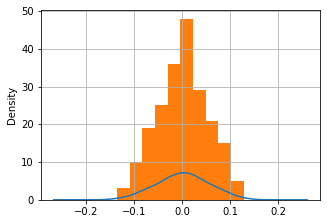

In [164]:
## Plot the the distribution of estimated market premium time-series
all_lambdas_OLS[0].iloc[:,1].plot(kind='density')
all_lambdas_OLS[0].iloc[:,1].hist()
plt.show()

### FM-IV (Time-Varying Betas)

In [165]:
# this cell define the rolling estimation window (n years) the rebalance frequency (monthly)
# for the first stage of FM regression
holding = 21 # 21 days per month
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(rollingW, periods)

756 211


For the IV approach, the study estimate betas within odd months and even months separately. Then we use odd-month betas as instrumental variables and even-month betas as explanatory variables when month t is even and vice versa when month t is odd. 

The first stage of FM IV regression (explanatory and instrumental beta estimates)

In [166]:
# This cell estimates the explanatory betas and instrumental betas
# These betas will be further used as explanatory variables and instrumental
# variabnles in the second stage to estimate risk premiums of market factor

all_betas_ev = []
all_betas_iv = []

for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    
    if (i + 1) % 2 == 1: # 0:Jan is odd month
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2): # if current month is odd, extract all the past odd months in the rolling window to estimate explanatory betas
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        
        for j in sim_SR.columns:
            df_index = rw_odd.index
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)
        
        rw_even = pd.DataFrame()         
        for k in range(1,n*12,2): # if current month is odd, extract all the past even months in the rolling window to estimate instrumental betas (lagged explanatory betas)
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []
        
        for j in sim_SR.columns:
            df_index = rw_even.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)      
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)

    if (i + 1) % 2 == 0: # 1: Feb is even month
        rw_odd = pd.DataFrame()
        for k in range(1,n*12,2): # if current month is even, extract all the past odd months in the rolling window to estimate instrumental betas (lagged explanatory betas)
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []
        
        for j in sim_SR.columns:
            df_index = rw_odd.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)        
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)
        
        rw_even = pd.DataFrame()   
        for k in range(0,n*12,2): # if current month is even, extract all the past even months in the rolling window to estimate explanatory betas 
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        
        for j in sim_SR.columns:
            df_index = rw_even.index         
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)


100%|██████████| 211/211 [02:25<00:00,  1.45it/s]


In [2]:
# Print explanatory betas for one period
all_betas_ev[0] 

NameError: name 'all_betas_ev' is not defined

In [168]:
# Print instrumental betas for one period
all_betas_iv[0]

,0
0,-0.078690
1,-0.009737
2,0.583537
3,0.386280
4,0.131113
...,...
495,0.386583
496,0.332361
497,0.082344
498,0.014471


In [169]:
holding = 1 # 1 month
rollingW = holding * n *12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

211 36


A rule of thumb is the first stage (i.e., the regression of x on the instrument and any covariates)should have an F statistic of at least 10.

In [170]:
# This cell test the f-values of the first stage of IV-2SLS (two-stage least squares) regression
fvalues = []

for i in tqdm(range(len(all_betas_ev))):
    ols = sm.OLS(all_betas_ev[i].values.astype(np.float64), sm.add_constant(all_betas_iv[i].values.astype(np.float64)))
    res = ols.fit()
    f = res.fvalue
    fvalues.append(f)


100%|██████████| 211/211 [00:00<00:00, 1652.34it/s]


In [171]:
pd.DataFrame(fvalues).describe()

,0
count,211.000000
mean,937.478612
std,108.126715
min,711.528570
25%,860.876360
50%,914.113504
75%,996.041166
max,1294.195065


The second stage of FM IV regression (estimate factor risk premiums)

In [172]:
all_lambdas_IV = []
all_resids_IV = []
# i is time

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)
    
    iv = IV2SLS(endog = m_sim_SR_tmp_T.loc[:,k].values,exog = sm.add_constant(all_betas_ev[i].values.astype(np.float64)),\
                instrument = sm.add_constant(all_betas_iv[i].values.astype(np.float64)))
    res = iv.fit()
    l = list(res.params)
    r = list(res.resid)
    lambdas.append(l)
    resids.append(r)

all_lambdas_IV.append(pd.DataFrame(lambdas))
all_resids_IV.append(pd.DataFrame(resids))

100%|██████████| 211/211 [00:00<00:00, 1071.20it/s]


In [173]:
res.summary

<bound method IVRegressionResults.summary of <statsmodels.sandbox.regression.gmm.IVRegressionResults object at 0x7fa72ac18820>>

In [174]:
# res.wu_hausman()

In [175]:
# This cell shows the second way to conduct the IV2SLS regression

# from statsmodels.sandbox.regression.gmm import IV2SLS

# all_lambdas_IV = []
# all_resids_IV = []
# # i is time

# m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

# lambdas = []
# resids = []
# index_times = list(m_sim_SR_tmp_T.columns)

# for k in tqdm(m_sim_SR_tmp_T.columns):
    
#     i = int(index_times.index(k) / holding)
    
#     iv = IV2SLS(endog = m_sim_SR_tmp_T.loc[:,k].values,exog = sm.add_constant(all_betas_ev[i].values.astype(np.float64)),\
#                 instrument = sm.add_constant(all_betas_iv[i].values.astype(np.float64)))
# #     iv = IV2SLS(endog = m_sim_SR_tmp_T.loc[:,k].values,exog = all_betas_ev[i].values.astype(np.float64),instrument = all_betas_iv[i].values.astype(np.float))
#     res = iv.fit()
#     l = list(res.params)
#     r = list(res.resid)
#     lambdas.append(l)
#     resids.append(r)

# all_lambdas_IV.append(pd.DataFrame(lambdas))
# all_resids_IV.append(pd.DataFrame(resids))


In [176]:
# # This cell shows the way of using the IV estimator equation to estimate risk premiums
# lam = []
# for i in range(periods):
#     a = np.dot(np.array(all_betas_iv[i]).T,np.array(all_betas_ev[i]))
#     b = np.dot(np.array(all_betas_iv[i]).T, np.array(m_sim_SR_tmp_T.iloc[:,i]))
#     l = np.linalg.inv(a)*b
#     lam.append(l)

In [177]:
# The following are residual returns
all_resids_IV = pd.DataFrame(all_resids_IV[0].T)
all_resids_IV

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,0.056618,-0.005333,0.015078,-0.074211,0.011509,-0.020151,0.049058,-0.003452,0.031563,-0.013165,...,-0.038365,0.043767,0.015515,0.034831,-0.016276,-0.040413,-0.023363,0.021603,-0.002883,-0.022451
1,-0.000587,0.002604,-0.008573,0.006747,-0.035908,0.143747,0.022260,0.115708,-0.069819,0.061918,...,0.057926,-0.088580,-0.089455,0.138955,0.031998,0.120415,0.035708,-0.091507,-0.005939,-0.045621
2,-0.058008,-0.000250,0.033056,-0.022331,0.000444,0.004202,0.078848,0.021953,0.039079,-0.032044,...,0.083032,-0.048343,-0.010183,-0.008559,0.010800,0.002505,0.040492,0.080424,0.076583,-0.034257
3,0.119787,0.029157,0.004954,-0.049191,0.209723,-0.034950,-0.057040,0.039523,-0.061593,-0.281169,...,0.003455,0.024418,-0.055326,-0.075791,0.023919,-0.050130,0.143999,-0.011078,-0.155330,-0.062674
4,0.003317,0.064613,-0.056908,0.124469,-0.064319,0.095144,0.035601,-0.047453,0.042874,-0.079713,...,-0.030680,-0.032234,-0.050202,0.049273,0.095472,-0.042188,0.091843,0.093417,-0.119410,0.092789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.081787,-0.009832,0.109834,0.053409,-0.072455,0.058973,-0.205262,-0.195171,0.277888,0.042319,...,-0.009344,-0.019439,0.129331,0.004834,0.108918,-0.167829,0.200512,0.015544,-0.016710,-0.038472
496,-0.024484,-0.185818,-0.145416,-0.154013,0.044445,0.060342,-0.026870,0.131396,0.130887,0.131406,...,0.108137,-0.101583,-0.031009,0.039292,0.074123,-0.280680,0.158554,-0.105110,0.259952,-0.006737
497,-0.012261,0.012350,-0.019466,0.032251,-0.007498,0.011066,0.009204,-0.009710,0.011481,-0.002417,...,0.007487,-0.020966,0.015899,0.004791,0.026418,-0.010131,-0.013233,0.011368,0.006214,-0.005555
498,-0.032325,0.050650,0.056390,-0.173060,-0.063241,-0.010044,-0.017421,0.051224,0.125618,0.105222,...,-0.062237,0.003287,-0.030768,0.071547,0.001890,-0.009871,0.052955,-0.150631,-0.072808,0.052518


In [178]:
# # Plot the distrubtion of the residualS
# label = all_resids_IV.index
# index = all_resids_IV.columns

# # Get the shape of df_residuals
# shape = all_resids_IV.shape

# plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)

# for j in tqdm(range(shape[1])):
#     plt.plot(all_resids_IV.iloc[:,j],)  

# plt.title('The distrubtion of residuals')
# # plt.xticks(np.arange(min(label), max(label)+1, 12), fontsize = 6)
# plt.xticks([], [])
# plt.yticks(fontsize = 6)
# # plt.xlabel('Stock Labels', fontsize = 10)
# plt.ylabel('Residuals', fontsize = 10)
# plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5, axis='y')
# plt.tight_layout()
# plt.show()

In [179]:
## test whether beta_iv (instrumental betas) are exogenous
corr_iv_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_iv[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_iv_res.append(corr)

print('mean_Pho = ' + str(np.mean(corr_iv_res)), "IV is Endogenous" if np.mean(corr_iv_res).round(10)!=0 else "IV is Exogenous") 

mean_Pho = 1.6703907214767194e-17 IV is Exogenous


In [180]:
## test whether beta_ev (explanatory betas) is endogenous
corr_ev_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_ev_res.append(corr) 
    
print('mean_Pho = ' + str(np.mean(corr_ev_res)), "EV is Endogenous" if np.mean(corr_ev_res).round(10)!=0 else "EV is Exogenous") 


mean_Pho = -0.00845800127938037 EV is Endogenous


Weak instrument variable test 

In [181]:
corr_ev_iv = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_betas_iv[i].values.astype(np.float64).flatten())[0]
    corr_ev_iv.append(corr)
    
print('mean_Pho = ' + str(np.mean(corr_ev_iv)), "IV is Strong" if np.mean(corr_ev_iv)>0.5 and stats.ttest_1samp(corr_ev_iv, 0.0)[0] > 2 else "IV is Weak")

mean_Pho = 0.8068371022596683 IV is Strong


In [182]:
# the average correlations between estimated and simulated betas 

corr_ev_true = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_ev_true.append(corr)

print('mean_Pho = ' + str(np.mean(corr_ev_true)), 'P-value =' + str(stats.ttest_1samp(corr_ev_true, 0.0)[0]))

mean_Pho = 0.9045556996107194 P-value =1532.3728855832146


In [183]:
# Print the intercept andrisk premium time-series
all_lambdas_IV[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,0.004366,0.073675
1,-0.009164,0.017010
2,0.001301,0.091369
3,-0.000762,0.075470
4,-0.001100,-0.055060
...,...,...
206,0.000628,0.068415
207,0.004633,-0.075269
208,0.005072,0.064252
209,0.000882,0.130310


In [184]:
# Calculate the t-statistic of market risk premium under IV approach
stats.ttest_1samp(all_lambdas_IV[0], 0.0)[0]

array([-2.0644271 ,  0.96867605])

In [185]:
# Print the time-series mean of market risk premiums
print(np.mean(all_lambdas_IV[0].iloc[:,1]))

0.003935164036861053


In [186]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(m_MR.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))   

ex-ante bias(%): -33.642436857174054
ex-post bias(%): -486.3427787877737


In [187]:
## Calculate the Ex-ante RMSE
diff = all_lambdas_IV[0].iloc[:,1]-np.array(m_MR_tmp).flatten()
np.sqrt((diff**2).mean())

0.07899510034942449

In [188]:
## Calculate the Ex-post RMSE
diff = all_lambdas_IV[0].iloc[:,1]-np.array(m_sim_MKT_tmp).flatten()
np.sqrt((diff**2).mean())

0.08050531307339052

### Plot the Bias of OLS/IV Estimator (South African Sample)

In [189]:
## The average of 100 times repetitions
## OLS Estimator Bias and RMSE
## n=1,2,3,5
## ex-ante biases: -27.1393, -20.4629, -12.2368, -2.3749
## ex-post biases: -26.1879, -19.7896, -11.8769, -1.8976

In [190]:
## IV Estimator Bias and RMSE
## n=1,2,3,5
## ex-ante biases: -16.5125, -11.8083, -6.7241, 2.5237
## ex-post biases: -15.7312, -10.9876, -5.8921, 1.6542

In [191]:
ea_1 = np.array([-27.1393, -20.4629, -12.2368, -2.3749], dtype = np.float64)
ea_2 = np.array([-16.5125, -11.8083, -6.7241, 2.5237], dtype = np.float64)
ep_1 = np.array([-26.1879, -19.7896, -11.8769, -1.8976], dtype = np.float64)
ep_2 = np.array([-15.7312, -10.9876, -5.8921, 1.6542], dtype = np.float64)
days = np.array([252, 252*2, 252*3, 252*5], dtype = np.float64)

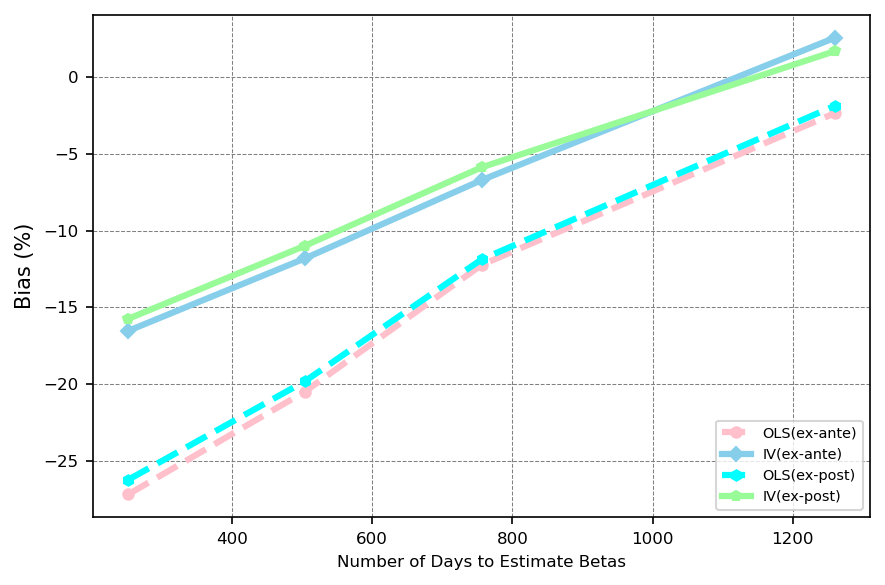

In [192]:
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
plt.plot(days, ea_1, linestyle='dashed', marker='o', markerfacecolor='pink', markersize= 5, color='pink', linewidth=3, label = "OLS(ex-ante)")
plt.plot(days, ea_2, marker='D', markerfacecolor='skyblue', markersize= 5, color='skyblue', linewidth=3, label = "IV(ex-ante)")
plt.plot(days, ep_1, linestyle='dashed', marker='h', markerfacecolor='cyan', markersize= 5, color='cyan', linewidth=3, label = "OLS(ex-post)")
plt.plot(days, ep_2, marker='p', markerfacecolor='palegreen', markersize= 5, color='palegreen', linewidth=3, label = "IV(ex-post)")
plt.xlabel('Number of Days to Estimate Betas', fontsize=8)
plt.ylabel('Bias (%)', fontsize=10)
plt. xticks(fontsize=8)
plt. yticks(fontsize=8)
# plt.title('Figuer1: Biases versus Number of Days Used to Estimate Betas', fontsize=10)
plt.legend(loc='lower right', fontsize = 'x-small')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()


Simulation results suggest that using the IV approach in the second stage of FM regression does not outperform the original OLS method. It will therefore be necessary to determine whether this problem is caused by a small sample size in the simulation (N=500, T=5215). This study uses the parameter from Jegadeesh et al. (2019) and then expands the simulation sample size to the same scale as theirs (N=2000, T=14363).

## Jegadeesh et al. (2019) Sample

### Import the simulation parameters from Jegadeesh et al. (2019)

In [193]:
# Import the mean and standard deviation of market factor return
mean_MKT = 5.80/100/252
sd_MKT = 15.33/100/np.sqrt(252)
print(mean_MKT, sd_MKT)

0.00023015873015873014 0.009656992285385755


In [194]:
# Import the mean and standard deviation of market betas
m_all_betas = 0.95
sd_all_betas = 0.42
print(m_all_betas, sd_all_betas)

0.95 0.42


In [195]:
# Import the standard deviation of residual returns 
m_all_sigmas = 58.73/100/252
sd_all_sigmas = 23.81/100/np.sqrt(252)
print(m_all_sigmas, sd_all_sigmas)

0.0023305555555555553 0.014998890170582832


### Simualted betas and sigmas are fixed through 100 repetitions

The betas and sigmas are generated at the begining of each simulation and keep them constant

In [196]:
# How many stocks in the simulation sample on cross-section 
N = 2000

In [197]:
# How many days in the simulation sample on time-series
T = 684 * 21 

In [198]:
# Beta simulation 
sim_betas_tmp = []
sim_betas_tmp.append(np.random.normal(loc = m_all_betas,scale = sd_all_betas, size= N ))
print(np.mean(sim_betas_tmp), np.std(sim_betas_tmp))

0.9617514273848073 0.4230565414646146


In [199]:
# Print simulated betas
sim_betas = pd.DataFrame(sim_betas_tmp)
# sim_betas = sim_betas.iloc[sim_betas.index.repeat(len(df_Ex_SR)),:]
# sim_betas = sim_betas.reset_index(drop = True)
sim_betas

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.932237,1.522305,0.791202,0.49591,0.11854,0.350575,0.904908,0.793816,1.775307,1.336061,...,0.956087,1.069294,1.209894,1.597663,0.813261,1.052333,1.226471,1.301344,0.736826,1.644053


In [200]:
# Residual sigmas simulation
sim_sigmas_tmp = []
sim_sigmas_tmp.append(np.random.normal(loc = m_all_sigmas,scale = sd_all_sigmas, size= N ))
np.mean(sim_sigmas_tmp), np.std(sim_sigmas_tmp)

(0.0019580519589467204, 0.014825244358583213)

In [201]:
# Print simulated the standard deviation of residuals
sim_sig_res = pd.DataFrame(sim_sigmas_tmp).abs()
sim_sig_res

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.005687,0.01691,0.003794,0.013527,0.011341,0.023142,0.020176,0.014029,0.008213,0.00853,...,0.011325,0.013992,0.013071,0.010719,0.013278,0.022569,0.023539,0.012081,0.005022,0.006398


In [202]:
## sum negative values in sim_sig_res
sim_sig_res.values.flatten()
sum(n < 0 for n in sim_sig_res.values.flatten())

0

### Simulated market, stock and residual returns are changable through 100 repetitions

Step-2: For each day, we randomly draw market excess return from a normal distribution with mean and standard deviation equal to the sample mean and standard deviation from the data

In [203]:
# market excess return simulation
sim_MKT_tmp = []
sim_MKT_tmp.append(np.random.normal(loc = mean_MKT,scale = sd_MKT, size= T))
print(np.mean(sim_MKT_tmp), np.std(sim_MKT_tmp))

0.00011149533529504435 0.00967039282502542


In [204]:
# Print simulated market returns
sim_MKT = pd.DataFrame(sim_MKT_tmp).T
sim_MKT.index = pd.date_range(start=df_MR.index[0], periods = T, freq='D').astype(str)
sim_MKT.columns = ['RM-RF']
sim_MKT

,RM-RF
2000-01-05,0.000254
2000-01-06,0.020639
2000-01-07,0.010061
2000-01-08,-0.002094
2000-01-09,-0.009117
...,...
2039-04-29,-0.020336
2039-04-30,-0.002601
2039-05-01,0.006368
2039-05-02,-0.008304


Step-3: For each stock, we then randomly generate daily residual return from a normal distribution with mean zero and standard deviation equal to the value generate in step-1, i.e. sim_sigmas

In [205]:
# Residual returns simulation
res_return = pd.DataFrame(np.zeros((len(sim_MKT), len(sim_sig_res.columns))))
for j in range(len(sim_sig_res.columns)):
    res_return.iloc[:,j] = np.random.normal(loc = 0,scale = sim_sig_res[j], size= len(sim_MKT))
res_return

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,-0.004204,-0.017845,-0.000432,-0.004285,-0.008723,-0.005269,-0.008751,0.022583,-0.004395,0.002867,...,0.014972,-0.015629,-0.020787,0.001069,-0.001796,-0.012072,0.015704,-0.015685,0.000197,-0.000677
1,0.007867,-0.007384,0.001324,-0.001242,0.013088,0.000647,-0.022456,0.023864,-0.002387,-0.003098,...,0.001231,0.011720,-0.007291,0.002864,-0.024575,0.055505,0.052419,-0.034685,-0.001140,0.012186
2,-0.001879,-0.008367,-0.000443,0.005667,0.003926,-0.010197,-0.002284,-0.003082,-0.004645,0.010493,...,-0.001174,-0.005472,0.004818,-0.005455,-0.000068,0.005183,0.016537,0.022074,-0.004624,-0.001222
3,-0.000561,-0.004234,0.002807,-0.018589,0.011488,-0.042271,-0.012156,0.002238,0.000993,0.011656,...,0.033912,0.025758,-0.010879,0.004287,0.017034,0.023688,0.018504,0.014450,0.004278,-0.003069
4,-0.003398,0.056201,-0.001988,-0.002016,0.007555,0.020126,-0.020114,-0.000864,0.000326,-0.010071,...,0.009822,-0.012392,0.007889,-0.003420,0.001751,0.012046,0.014341,0.012497,-0.009140,-0.004838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14359,0.006951,-0.007220,0.000090,0.012488,-0.010096,-0.019964,-0.005802,0.022802,0.003570,0.001813,...,0.004153,0.008437,0.004866,0.014101,-0.010192,0.042042,-0.004164,0.020810,-0.003181,0.004098
14360,0.004846,-0.007742,0.000428,0.007051,0.003404,-0.006889,0.006764,-0.004554,-0.001678,0.008104,...,0.007454,0.008365,-0.021941,-0.008592,0.025522,0.014797,-0.032741,0.000962,0.000280,0.010827
14361,-0.006540,-0.007856,0.002051,-0.014748,-0.028088,0.017228,-0.018777,-0.017181,0.005477,0.007719,...,-0.002476,-0.030067,0.009120,-0.013940,0.000785,0.007940,0.020148,0.003621,0.012360,-0.004017
14362,-0.000423,-0.033194,-0.003812,-0.025475,0.006628,-0.022543,-0.008594,0.000285,-0.000914,-0.004868,...,0.003781,-0.005404,0.003626,0.003065,0.003796,-0.004230,0.020711,0.002211,0.000401,0.003368


Step-4: For each stock i, we compute its excess return as beta,i*MKT,t + episiloni,,t

In [206]:
# Stock returns simulation
sim_SR = (np.mat(sim_MKT.iloc[:,0]).T*np.mat(sim_betas.iloc[0,:].values)) + res_return
sim_SR = pd.DataFrame(sim_SR)
sim_SR.index = pd.date_range(start=df_MR.index[0], periods = T, freq='D').astype(str)
sim_SR

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
2000-01-05,-0.003967,-0.017458,-0.000231,-0.004159,-0.008693,-0.005180,-0.008521,0.022785,-0.003944,0.003207,...,0.015216,-0.015357,-0.020480,0.001475,-0.001590,-0.011804,0.016016,-0.015355,0.000384,-0.000259
2000-01-06,0.027107,0.024035,0.017653,0.008993,0.015535,0.007882,-0.003780,0.040247,0.034253,0.024476,...,0.020963,0.033788,0.017679,0.035838,-0.007790,0.077223,0.077732,-0.007827,0.014067,0.046117
2000-01-07,0.007501,0.006949,0.007518,0.010656,0.005119,-0.006669,0.006820,0.004905,0.013217,0.023935,...,0.008446,0.005287,0.016991,0.010619,0.008114,0.015771,0.028877,0.035167,0.002789,0.015319
2000-01-08,-0.002514,-0.007422,0.001150,-0.019627,0.011239,-0.043006,-0.014051,0.000576,-0.002725,0.008858,...,0.031910,0.023519,-0.013413,0.000941,0.015331,0.021484,0.015935,0.011725,0.002734,-0.006512
2000-01-09,-0.011897,0.042323,-0.009201,-0.006538,0.006474,0.016930,-0.028364,-0.008101,-0.015859,-0.022252,...,0.001106,-0.022140,-0.003141,-0.017986,-0.005664,0.002452,0.003160,0.000633,-0.015858,-0.019826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039-04-29,-0.012007,-0.038177,-0.016000,0.002403,-0.012506,-0.027094,-0.024204,0.006659,-0.032533,-0.025357,...,-0.015290,-0.013308,-0.019739,-0.018390,-0.026730,0.020642,-0.029105,-0.005654,-0.018165,-0.029336
2039-04-30,0.002422,-0.011702,-0.001630,0.005761,0.003096,-0.007800,0.004410,-0.006619,-0.006296,0.004630,...,0.004967,0.005584,-0.025087,-0.012748,0.023406,0.012061,-0.035930,-0.002422,-0.001636,0.006552
2039-05-01,-0.000603,0.001838,0.007089,-0.011591,-0.027333,0.019461,-0.013015,-0.012126,0.016781,0.016227,...,0.003612,-0.023258,0.016824,-0.003767,0.005963,0.014641,0.027958,0.011908,0.017052,0.006453
2039-05-02,-0.008164,-0.045836,-0.010382,-0.029593,0.005643,-0.025454,-0.016108,-0.006307,-0.015656,-0.015962,...,-0.004159,-0.014284,-0.006421,-0.010202,-0.002957,-0.012968,0.010527,-0.008595,-0.005717,-0.010284


In [207]:
# The study assumes 21 days per month, T = 252 days corresponds to one year
months = []
periods = int(len(sim_SR)/21)+1
mons = pd.date_range(start=sim_SR.index[0], periods = periods, freq='M').astype(str).str[:7]
for i in range(periods):
    m = mons[i]
    months.append(np.repeat(m,21))

In [208]:
## Sum daily stock returns to monthly returns
## They are addable because they are log returns
m_sim_SR = sim_SR
m_sim_SR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_SR = m_sim_SR.groupby('month').sum()
sim_SR = sim_SR.drop(['month'], axis = 1)
m_sim_SR = m_sim_SR.iloc[:,:]
m_sim_SR

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
month,,,,,,,,,,,,,,,,,,,,,
2000-01,0.055356,0.141444,0.049311,-0.020667,0.078816,0.048345,0.000372,0.055569,0.053541,0.138622,...,0.088442,-0.074108,-0.002528,-0.035088,0.079044,0.186771,0.115039,0.007549,0.014772,0.019049
2000-02,-0.012971,0.034380,0.009187,0.005031,0.041602,0.308087,0.052171,-0.013604,0.029564,-0.055350,...,0.071682,0.064404,0.067314,-0.038305,0.019371,-0.099229,0.044093,0.031084,0.011745,0.069906
2000-03,-0.031968,-0.128775,-0.029659,0.038510,-0.099618,0.188665,-0.066064,-0.049771,-0.081649,-0.022125,...,0.007549,-0.117326,-0.005728,-0.091107,-0.092097,-0.095529,0.080809,0.018731,-0.030681,-0.084635
2000-04,-0.010764,0.060179,0.013380,-0.062208,-0.123174,-0.040174,0.047615,0.013157,0.018731,-0.030643,...,-0.049352,0.004412,0.108107,-0.049745,0.056116,-0.060151,0.076687,-0.019528,-0.045440,0.011404
2000-05,-0.018528,0.022371,0.011224,-0.094120,-0.062712,0.285256,-0.137255,0.004167,0.005708,0.109751,...,-0.050874,-0.068501,0.012263,-0.021408,-0.006247,0.019808,-0.032229,-0.001693,-0.018300,-0.036017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056-08,-0.027158,-0.047821,0.012248,0.057655,0.035789,-0.104264,-0.110771,0.091451,0.010583,-0.029812,...,-0.049975,-0.098234,-0.059605,-0.046175,-0.161215,0.045076,-0.105819,-0.011779,-0.027311,0.004618
2056-09,-0.043416,-0.024305,0.000344,0.017437,-0.002932,-0.046965,0.009343,0.009986,-0.013857,-0.005738,...,-0.030375,-0.146495,-0.045167,0.047638,0.013206,0.184032,0.093563,-0.074648,-0.076624,0.043832
2056-10,-0.027657,0.027055,-0.032666,-0.012560,0.015678,-0.130854,0.084233,-0.082483,-0.015867,-0.074879,...,-0.055019,0.050964,-0.024142,-0.092199,0.079759,-0.092083,-0.205550,0.011314,-0.001313,-0.013946


In [209]:
# Sum daily market factor returns to monthly returns
m_sim_MKT = sim_MKT
m_sim_MKT['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_MKT = m_sim_MKT.groupby('month').sum()
sim_MKT = sim_MKT.drop(['month'], axis = 1)
m_sim_MKT = m_sim_MKT.iloc[:,:]
m_sim_MKT

,RM-RF
month,
2000-01,0.040028
2000-02,0.023227
2000-03,-0.047339
2000-04,-0.012533
2000-05,-0.000643
...,...
2056-08,-0.005207
2056-09,-0.013960
2056-10,-0.018949


### FM-OLS (Constant Betas)

Try to run FM OLS (without rolling windows) to estimate risk premiums for simulated market factor. Use the factor model in the linearmodel module, however, this function does not allow for time-varying betas, so the FM two-step regression would yield the same results as cross-sectional regression.

In [210]:
from linearmodels.asset_pricing.model import LinearFactorModel
model_ols = LinearFactorModel(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:               2000   R-squared:                      0.3160
No. Factors:                          1   J-statistic:                    2241.7
No. Observations:                 14364   P-value                         0.0001
Date:                  Mon, May 02 2022   Distribution:               chi2(1999)
Time:                          13:20:41                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
RM-RF          0.0001  8.074e-05     1.3937     0.1634  -4.572e-05      0.0003
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

In [211]:
# Print the time-series mean of Market factor premiums and its t-statistics.
print(res_ols.risk_premia.values, res_ols.risk_premia_tstats.values)

[0.00011253] [1.39373258]


In [212]:
# Print the ex-ante and ex-post biases 
print("ex-ante bias(%):" + str(((res_ols.risk_premia-mean_MKT)/mean_MKT*100).values))
print("ex-post bias(%):" + str(((res_ols.risk_premia-sim_MKT.mean())/sim_MKT.mean()*100).values))

ex-ante bias(%):[-51.10905393]
ex-post bias(%):[0.92510179]


### FM-OLS (Time-varying Betas)

In [213]:
# how many years of the rolling estimation window
n = 3

In [214]:
# Define the length of rolling window and the rebalance frequency
holding = 21 # 1 month
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

647 756


Step-5: For the first-stage of FM-OLS regression in the simulation, we estimate betas using time series regression below

In [215]:
all_betas = []

for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []
    # j is cross-sectional stock name
    for j in sim_SR.columns:      
        OLS = sm.OLS(sim_SR_tmp.loc[:,j].values.astype(np.float64), sm.add_constant(sim_MKT_tmp.values.astype(np.float64)))
        res = OLS.fit()
        b = list(res.params)
        s = np.std(res.resid)
        betas.append(b)

    df_betas = pd.DataFrame(betas).rename(columns={0:'Intercepts',1:'MKT'})
    all_betas.append(df_betas)

100%|██████████| 647/647 [08:32<00:00,  1.26it/s]


In [216]:
# Print estimated betas and intercepts for one period
all_betas[0]

,Intercepts,MKT
0,-0.000129,0.965066
1,0.000494,1.380506
2,0.000287,0.802207
3,-0.000092,0.491407
4,-0.000353,0.158874
...,...,...
1995,-0.000446,1.184780
1996,0.000048,1.243256
1997,0.000167,1.230971
1998,0.000138,0.732690


In [217]:
# Test the correlation between estimated betas and simulated betas
corr_betas_true = []

for i in range(len(all_betas)):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_betas_true.append(corr)

print(np.mean(corr_betas_true), stats.ttest_1samp(corr_betas_true, 0.0)[0])

0.9912854215956383 25674.384521221044


In [218]:
# This cell redefine the daily regression to monthly regression
# by simple change the holding scale from "21 days" to "1 month"
holding = 1 # 1 month
rollingW = holding *n*12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

647 36


In [219]:
all_lambdas_OLS = []
all_resids_OLS = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):   
    i = int(index_times.index(k)/holding)
    OLS = sm.OLS(m_sim_SR_tmp_T.loc[:,k], sm.add_constant(all_betas[i].loc[:,"MKT"].astype(np.float64)))
    res = OLS.fit()
    l = list(res.params)
    r = list(res.resid)
    lambdas.append(l)
    resids.append(r)
        
all_lambdas_OLS.append(pd.DataFrame(lambdas))
all_resids_OLS.append(pd.DataFrame(resids))

100%|██████████| 647/647 [00:01<00:00, 530.44it/s]


In [220]:
# Print intercepts and market factor premiums for one period
all_lambdas_OLS[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,-0.003423,0.003459
1,0.005154,0.048369
2,-0.003780,-0.011946
3,-0.008857,0.086889
4,0.004165,0.088027
...,...,...
642,0.004325,0.064805
643,0.002274,-0.009286
644,0.000138,-0.013680
645,-0.001719,-0.017473


In [221]:
# Print residuals
all_resids_OLS = pd.DataFrame(all_resids_OLS[0].T)
all_resids_OLS

,0,1,2,3,4,5,6,7,8,9,...,637,638,639,640,641,642,643,644,645,646
0,-0.016402,-0.022266,-0.033297,0.007436,-0.044660,-0.026429,0.021467,-0.001708,0.036506,0.053397,...,-0.017521,0.004261,0.004219,0.007795,-0.014597,-0.034047,-0.020511,-0.030514,-0.009210,-0.008559
1,-0.112245,-0.009276,-0.020483,0.122356,0.175218,-0.002632,0.159861,-0.075987,-0.047039,-0.042096,...,-0.021396,-0.044188,0.120582,0.107341,0.017309,-0.088624,-0.037603,-0.005654,0.053212,-0.041328
2,0.036720,0.001348,-0.011051,-0.032668,0.014049,0.021261,0.002361,0.017178,0.002241,-0.025947,...,-0.007329,-0.033009,0.007621,-0.002103,0.022501,-0.031004,0.017466,0.011165,-0.016916,0.017805
3,0.024758,-0.063644,-0.067809,-0.074496,-0.080812,0.049424,0.027917,-0.005987,0.009800,0.019619,...,-0.040907,-0.131309,-0.011256,-0.075022,-0.067473,-0.014458,0.059659,0.023555,-0.003194,0.032419
4,-0.007296,0.014605,-0.042180,0.037159,-0.049638,0.015920,-0.107891,0.133610,0.010123,0.072511,...,-0.069689,-0.035307,0.038569,-0.066219,0.059879,-0.009648,0.034910,-0.000874,0.020374,0.007698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.124750,0.124632,0.217263,0.015367,0.142183,0.127803,0.107092,-0.040192,0.184389,-0.071937,...,-0.035594,-0.005321,0.042452,-0.043829,0.185843,-0.195239,0.052181,0.198244,-0.072319,0.042655
1996,-0.079689,0.000184,-0.089482,0.094398,0.033814,-0.160290,0.083237,-0.110756,0.048967,-0.065635,...,-0.011593,-0.020287,0.051981,0.016643,0.030166,0.088861,-0.096533,0.110765,-0.181959,0.115004
1997,-0.049120,-0.001202,-0.026161,0.000190,-0.060280,-0.000398,-0.039430,0.017539,0.006572,0.033644,...,-0.034071,0.050535,0.033551,0.020070,0.067598,0.042027,-0.002187,-0.057436,0.035200,0.018275
1998,-0.042982,-0.030845,-0.019012,-0.015703,-0.016560,0.046107,-0.000741,-0.005219,0.004517,-0.034288,...,0.023892,0.034163,-0.008560,-0.010295,-0.047602,-0.001495,-0.022778,-0.066765,0.013079,-0.030659


In [222]:
# Calculate the t-statistics of intercepts and factor premiums
stats.ttest_1samp(all_lambdas_OLS[0], 0.0)[0]

array([1.35824635, 1.30393981])

In [223]:
## Newey-West t-test for market risk premiums
all_lambdas_OLS[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([0.83134424, 0.79813519])

In [224]:
# Print the mean of market risk premiums
print(np.mean(all_lambdas_OLS[0].iloc[:,1]))

0.002155544529319163


In [225]:
# Print the ex-ante and ex-post biases for FM-OLS regression
print("ex-ante bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(mean_MKT*21))/(np.mean(mean_MKT*21))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))

ex-ante bias(%): -55.402526979603515
ex-post bias(%): -7.937872633861577


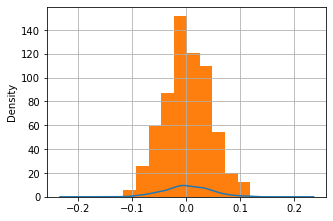

In [226]:
# Plot the distribution of market risk premiums
all_lambdas_OLS[0].iloc[:,1].plot(kind='density')
all_lambdas_OLS[0].iloc[:,1].hist()
plt.show()

### FM-IV (Time-varying Betas)

In [227]:
# Define the length of rolling window and rebalance frequency
holding = 21
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(rollingW, periods)

756 647


In [228]:
# This cell estimates the explanatory betas and instrumental betas
# These betas will be further used as explanatory variables and instrumental
# variabnles in the second stage to estimate risk premiums of market factor

all_betas_ev = []
all_betas_iv = []

for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    
    if (i + 1) % 2 == 1: # 0:Jan is odd month
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):  # if current month is odd, extract all the past odd months in the rolling window to estimate explanatory betas
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []

        for j in sim_SR.columns:
            df_index = rw_odd.index
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)

        rw_even = pd.DataFrame()         
        for k in range(1,n*12,2): # if current month is odd, extract all the past even months in the rolling window to estimate instrumental betas (lagged explanatory betas) 
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []

        for j in sim_SR.columns:
            df_index = rw_even.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)      
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)

    if (i + 1) % 2 == 0: # 1: Feb is even month
        rw_odd = pd.DataFrame()
        for k in range(1,n*12,2): # if current month is even, extract all the past odd months in the rolling window to estimate instrumental betas (lagged explanatory betas)
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []

        for j in sim_SR.columns:
            df_index = rw_odd.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)        
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)
        
        rw_even = pd.DataFrame()   
        for k in range(0,n*12,2): # if current month is even, extract all the past even months in the rolling window to estimate explanatory betas 
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        for j in sim_SR.columns:
            df_index = rw_even.index         
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)

100%|██████████| 647/647 [27:54<00:00,  2.59s/it]


In [229]:
# Print all of the explanatory betas
all_betas_ev[0]

,0
0,0.972348
1,1.426044
2,0.824189
3,0.501393
4,0.160656
...,...
1995,1.310994
1996,1.311564
1997,1.187244
1998,0.741148


In [230]:
# Print all of the instrumental betas
all_betas_iv[0]

,0
0,0.956918
1,1.341022
2,0.783033
3,0.487006
4,0.161564
...,...
1995,1.079051
1996,1.183952
1997,1.273715
1998,0.724436


### Correlation between iv_errors and ev_errors

In Jegadeesh et al. (2019), they argue that the IV estimator that they adopt is nearly unbiased and N-consistent, however, we cannot find such attractive property in this study. After reading through econometrics papers that also used IV approach, we double the problem of the puzzling result is due to the time-series correlation of measurement errors. Such an issue happens very often when using lagged exdogenous variables as instrumental variables to solve the endogeneity problem (like EIV problem).  Regardless of sample size, the autocorrelation of measurement errors would cause the IV estimation to be inconsistent.

In [231]:
# Run this cell to randomly test the covariance of the measurement errors of explanatory and instrumental variables
# If the covariance value is not equal to 0, then there is autocorrelation in the
# measurement errors. As such, the risk premium estimation will be significantly biased and inconsistent.
h = np.random.randint(0,len(all_betas_ev))
print(h)
beta_err_ev = all_betas_ev[h].values - sim_betas.T.values
beta_err_iv = all_betas_iv[h].values - sim_betas.T.values
np.cov(beta_err_ev.flatten(), beta_err_iv.flatten())[0,1]

298


2.548917422298013e-05

In [232]:
# This cell calculates the correlation coefficeints of the measurement errors of explanatory and instrumental variables
corr_errs = []
for i in range(periods):
    beta_err_ev = all_betas_ev[i].values - sim_betas.T.values
    beta_err_iv = all_betas_iv[i].values - sim_betas.T.values
    corr = stats.pearsonr(beta_err_ev.flatten(), beta_err_iv.flatten())[0]
    corr_errs.append(corr)

In [233]:
# If the average correlation coefficient is not equal to zero, then there is autocorrelation in the measurement errors
pd.DataFrame(corr_errs).describe()

,0
count,647.000000
mean,-0.000945
std,0.049446
min,-0.120349
25%,-0.037959
50%,-0.001748
75%,0.034355
max,0.116347


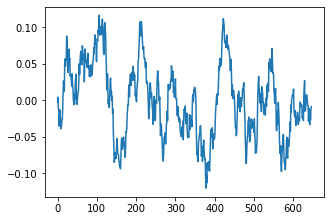

In [234]:
# Plot the distribution of the correlation coefficients of measurement erros
plt.plot(corr_errs)
plt.show()

In [235]:
# Define the length of rolling window and the rebalance frequency
holding = 1 # 1 month
rollingW = holding * n *12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

647 36


In [236]:
# This cell uses a two-stage least squares regression to estimate market risk premium by
# using instrumental betas that estimated before as the instrumental variables

all_lambdas_IV = []
all_resids_IV = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)
    
    iv = IV2SLS(endog = m_sim_SR_tmp_T.loc[:,k].values,
                exog = sm.add_constant(all_betas_ev[i].values.astype(np.float64)),
                instrument = sm.add_constant(all_betas_iv[i].values.astype(np.float64)))
    
    res = iv.fit()
    l = list(res.params)
    r = list(res.resid)
    lambdas.append(l)
    resids.append(r)

all_lambdas_IV.append(pd.DataFrame(lambdas))
all_resids_IV.append(pd.DataFrame(resids))

100%|██████████| 647/647 [00:00<00:00, 789.83it/s]


In [237]:
all_resids_IV = pd.DataFrame(all_resids_IV[0].T)
all_resids_IV

,0,1,2,3,4,5,6,7,8,9,...,637,638,639,640,641,642,643,644,645,646
0,-0.016423,-0.022211,-0.033382,0.008554,-0.042795,-0.026105,0.019606,-0.002523,0.036498,0.053395,...,-0.017672,0.004438,0.004078,0.007880,-0.014583,-0.034656,-0.020453,-0.030337,-0.008910,-0.009141
1,-0.112276,-0.013222,-0.019288,0.116948,0.172146,-0.003519,0.163577,-0.074018,-0.046697,-0.042309,...,-0.022795,-0.040899,0.119138,0.107790,0.016711,-0.089002,-0.037230,-0.006461,0.052834,-0.039942
2,0.036608,0.000389,-0.010923,-0.034293,0.011971,0.020949,0.003578,0.017981,0.002161,-0.025878,...,-0.007275,-0.033055,0.007745,-0.002165,0.022768,-0.030400,0.017139,0.011196,-0.016958,0.017830
3,0.024601,-0.062055,-0.068776,-0.072931,-0.078540,0.050019,0.024810,-0.008796,0.009465,0.019829,...,-0.041283,-0.129109,-0.012642,-0.074180,-0.066469,-0.016697,0.059267,0.024267,-0.002941,0.031912
4,-0.007517,0.015452,-0.043310,0.038309,-0.047744,0.016247,-0.110384,0.130787,0.009626,0.072853,...,-0.069415,-0.035230,0.038929,-0.066199,0.061286,-0.009290,0.033629,-0.000729,0.020187,0.007583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.125091,0.121190,0.218152,0.012253,0.137924,0.127105,0.111747,-0.038419,0.184489,-0.071983,...,-0.035819,-0.004245,0.042419,-0.043712,0.185820,-0.195863,0.052381,0.197847,-0.073090,0.043754
1996,-0.079829,-0.002437,-0.088513,0.089576,0.026998,-0.161260,0.088762,-0.107882,0.049128,-0.065738,...,-0.010198,-0.026364,0.056611,0.014808,0.029330,0.098508,-0.097606,0.108491,-0.184927,0.120075
1997,-0.048907,-0.000643,-0.026034,-0.000020,-0.060830,-0.000443,-0.039431,0.017957,0.006759,0.033509,...,-0.033799,0.049953,0.033566,0.019884,0.066974,0.043764,-0.001950,-0.057738,0.035036,0.019341
1998,-0.043070,-0.030770,-0.019361,-0.015857,-0.016982,0.046149,-0.001192,-0.005526,0.004385,-0.034194,...,0.023469,0.035569,-0.009027,-0.009970,-0.047140,-0.002571,-0.022973,-0.066449,0.013250,-0.031123


In [238]:
## test whether beta_iv (instrumental betas) is exogenous
corr_iv_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_iv[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_iv_res.append(corr)

print("rho = " + str(np.mean(corr_iv_res)), "IV is Endogenous" if np.mean(corr_iv_res).round(10)!=0 else "IV is Exogenous") 

rho = 6.927867551055676e-17 IV is Exogenous


In [239]:
# test whether beta_ev (explanatory variables) is exogenous
corr_ev_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_ev_res.append(corr) 
    
print("rho = " + str(np.mean(corr_ev_res)), "EV is Endogenous" if np.mean(corr_ev_res).round(10)!=0 else "EV is Exogenous") 


rho = -0.0005106628870856506 EV is Endogenous


In [240]:
# weak instrument variable test
corr_ev_iv = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_betas_iv[i].values.astype(np.float64).flatten())[0]
    corr_ev_iv.append(corr)
    
print(np.mean(corr_ev_iv), "IV is Strong" if np.mean(corr_ev_iv)>0.5 and stats.ttest_1samp(corr_ev_iv, 0.0)[0] > 2 else "IV is Weak")

0.9658157542175577 IV is Strong


In [241]:
# Print the factor premiums and intercepts
all_lambdas_IV[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,-0.003165,0.003189
1,0.003906,0.049645
2,-0.002503,-0.013264
3,-0.009604,0.087640
4,0.003775,0.088379
...,...,...
642,0.003651,0.065705
643,0.003792,-0.010889
644,-0.000201,-0.013359
645,-0.001531,-0.017707


In [242]:
# Print the t-statistics of intercept and market risk premium
stats.ttest_1samp(all_lambdas_IV[0], 0.0)[0]

array([1.0797115 , 1.30506736])

In [243]:
# Summarized statistics of intercept and market risk premium
all_lambdas_IV[0].describe()

,0,1
count,647.000000,647.000000
mean,0.000169,0.002196
std,0.003989,0.042792
min,-0.017062,-0.116006
25%,-0.002313,-0.025598
50%,0.000329,-0.000033
75%,0.002995,0.031421
max,0.012962,0.120858


In [244]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - mean_MKT*21)/(mean_MKT*21)*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))   

ex-ante bias(%): -54.57498174588062
ex-post bias(%): -6.229579101773005


### Plot the Bias of OLS/IV Estimator (Jegadeesh et al. (2019) Sample)

In [245]:
ea_1 = np.array([-9.0037, -4.1658, -2.5595, -0.6091, 2.4610], dtype = np.float64)
ea_2 = np.array([-5.7519, -3.4048, -2.3114, -0.5500, 1.9114], dtype = np.float64)
ep_1 = np.array([-10.8707, -6.1321, -4.5588, -2.3624, 1.6327], dtype = np.float64)
ep_2 = np.array([-7.6857, -5.3868, -4.3158, -2.3044, 1.0795], dtype = np.float64)
days = np.array([252, 252*3, 252*5, 252*7, 252*10 ], dtype = np.float64)

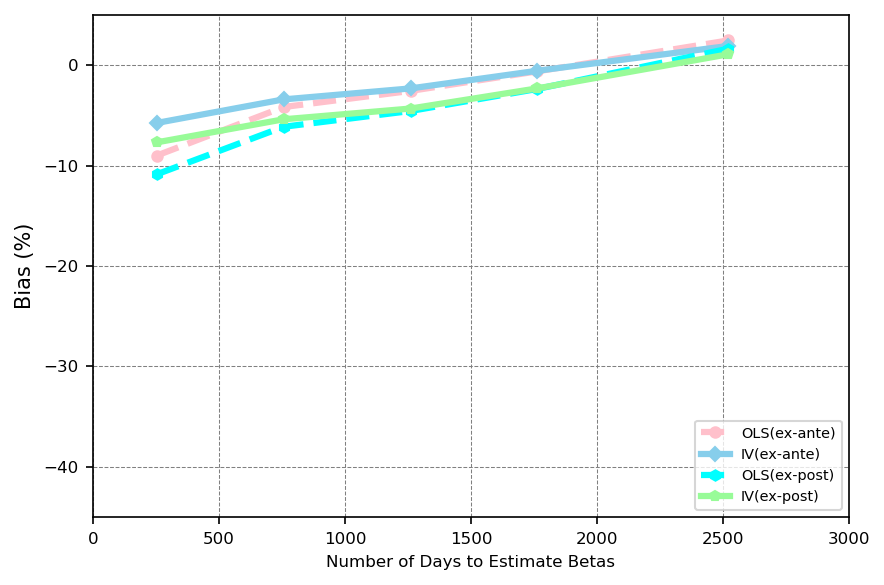

In [246]:
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
plt.plot(days, ea_1, linestyle='dashed', marker='o', markerfacecolor='pink', markersize= 5, color='pink', linewidth=3, label = "OLS(ex-ante)")
plt.plot(days, ea_2, marker='D', markerfacecolor='skyblue', markersize= 5, color='skyblue', linewidth=3, label = "IV(ex-ante)")
plt.plot(days, ep_1, linestyle='dashed', marker='h', markerfacecolor='cyan', markersize= 5, color='cyan', linewidth=3, label = "OLS(ex-post)")
plt.plot(days, ep_2, marker='p', markerfacecolor='palegreen', markersize= 5, color='palegreen', linewidth=3, label = "IV(ex-post)")
plt.xlabel('Number of Days to Estimate Betas', fontsize=8)
plt.ylabel('Bias (%)', fontsize=10)
plt.ylim((-45,5))
plt.xlim((0,3000))
plt. xticks(fontsize=8)
plt. yticks(fontsize=8)
# plt.title('Figuer1: Biases versus Number of Days Used to Estimate Betas', fontsize=10)
plt.legend(loc='lower right', fontsize = 'x-small')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()


# Empirical Results

This section employs the OLS and IV methods to estimate the premiums for risk factors proposed by prominent asset pricing models.

## FM-OLS Regression (Time-Varying Betas)

This Section first tests whether the risk premiums under the CAPM and the FF3- and FF5-Factor Models are significantly different from zero using the OLS method with individual stocks. For the OLS tests, the regression is fitted with daily return data from month t-36 to month t-1 to estimate beta for month t. 

### CAPM Model

How many years in the rolling estimation window?

In [247]:
n = 3

Define the length of rolling window and rebalance frequency

In [248]:
holding = 21
rollingW = holding * n *12
lens = len(df_MR)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

211 756


This cell is the first stage of FM-OLS regression, which is used to estimate market betas by regressing stock returns on market factor returns

In [249]:
# Keep the stock returns has the same length as market returns
df_Ex_SR_trnct = df_Ex_SR.loc[df_MR.index,:]

all_betas = []

for i in tqdm(range(periods)):

    df_MR_tmp = df_MR.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []
    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) > 10:
            b = list(ols_model.fit(df_MR_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'stock'}).set_index('stock')
    
    all_betas.append(df_betas)

100%|██████████| 211/211 [01:38<00:00,  2.14it/s]


In [250]:
# Print market betas for one period
all_betas[0]

,MKT
stock,
ABC.SJ.Equity,0.06890337112683975
ABI.SJ.Equity,0.23352855971285957
ABR.SJ.Equity,-0.13818778126607012
ACL.SJ.Equity,0.957051285238076
ACP.SJ.Equity,-0.02694573125717277
...,...
WTC.SJ.Equity,0.360477310787068
YRK.SJ.Equity,-0.04329882197390028
ZPT.SJ.Equity,0.19615208275356721


This cell is the second stage of FM-OLS regression, which aims to estimate market risk premiums

In [251]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    # k is stock on cross-section
    i = int(index_times.index(k) / holding)
    # i is time in periods
    df_return = df_Ex_SR_tmp_T.loc[all_betas[i].index,k].dropna()
    df_index = df_return.index
    
    if len(df_index) != 0:
        ols = sm.OLS(df_return, sm.add_constant(all_betas[i].loc[df_index,:].astype(np.float64)))
        res = ols.fit()
        l = list(res.params)
        
        lambdas.append(l)
        
all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 4431/4431 [00:08<00:00, 532.75it/s]


In [252]:
# Print market risk premiums and intercepts
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,-0.000307,0.007606
1,0.000293,0.004216
2,0.000881,0.005596
3,-0.000568,0.009103
4,0.002481,-0.013106
...,...,...
4426,-0.000153,-0.001191
4427,0.000078,0.003805
4428,-0.000666,0.011018
4429,0.000893,0.003637


In [253]:
# Print the time-series mean of market risk premiums and intercepts
print(np.mean(all_lambdas[0], axis = 0)*21*100)

0   -0.245363
1    0.157725
dtype: float64


In [254]:
stats.ttest_1samp(all_lambdas[0], 0)

Ttest_1sampResult(statistic=array([-4.92741028,  0.45160346]), pvalue=array([8.63669385e-07, 6.51576783e-01]))

In [255]:
# Use the Newey-West t-test to examine market risk premiums and intercepts
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis = 0)

0   -2.717779
1    0.268160
dtype: float64

### —Adding Control Variables

The significance of factor risk premium estimates may due to an omitted variable bias because the second-stage cross-sectional regressions do not control for corresponding firm charactersitics. For mitigating this potential bias, we add characteristics as control variables in the second stage. 

In [256]:
# Keep the size and PE have the same length as stock returns
df_ln_Size_trnct = df_ln_Size.loc[df_Ex_SR_trnct.index,:]
df_PE_trnct = df_PE.loc[df_Ex_SR_trnct.index,:]

In [257]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)

True

In [258]:
# Stock returns are forward for 21 days compared to firm characteristics 
Gap = 21

In [259]:
# This cell represents the second stage of FM-OLS regression, which estimates the market risk premiums 
# by controlling for Size and PE characteristics.
all_lambdas = []
all_intercepts = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)


for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):
    # k is date t in len(df_Ex_SR_tmp) days
    i = int(index_times.index(k) / holding)
    # i is time T in 185 periods
    # df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan), the -inf in ln_Size data dataframe would interrupt the regression
    df_index = (((all_betas[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                   intersection(df_PE_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index))
    
    if len(df_index) != 0:
        
        l = list(ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], \
                                           df_ln_Size_tmp_T.loc[df_index,k],\
                                           df_PE_tmp_T .loc[df_index,k]],axis = 1).values), \
                               (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).coef_)
        
        h = ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], \
                                      df_ln_Size_tmp_T.loc[df_index,k],\
                                      df_PE_tmp_T .loc[df_index,k]],axis = 1).values), \
                          (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).intercept_
        
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 4410/4410 [00:21<00:00, 202.84it/s]


In [260]:
# Print regression intercepts 
all_intercepts[0]

,0
0,0.005652
1,-0.008008
2,0.011105
3,-0.000321
4,-0.001798
...,...
4405,-0.003185
4406,-0.002526
4407,-0.002783
4408,0.002012


In [261]:
# Print market risk premiums and the slope coefficients of characteristics
all_lambdas[0].rename(columns={0:'MKT',1:'Size',2:'PE'})

,MKT,Size,PE
0,4.760142e-03,-8.311793e-04,3.071736e-03
1,-1.749357e-02,1.587276e-03,-4.629646e-03
2,5.040778e-03,-1.800801e-03,1.327077e-04
3,5.885179e-35,-9.144830e-36,-1.331188e-36
4,-5.066241e-03,4.362579e-04,-1.391939e-03
...,...,...,...
4405,-3.936111e-03,6.137074e-04,8.360527e-04
4406,4.720645e-03,2.455590e-04,-2.765701e-03
4407,9.944941e-03,2.467517e-04,-6.173282e-04
4408,6.320216e-03,-7.996539e-05,-1.068169e-03


In [262]:
# Print the mean of intercepts
np.mean(all_intercepts[0], axis = 0)*21*100

0   -0.836576
dtype: float64

In [263]:
# Print the mean of market risk premiums
np.mean(all_lambdas[0])*21*100

/Users/runxinlin/opt/anaconda3/envs/Research_Codes_2021/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0   -0.476476
1    0.108517
2   -0.506973
dtype: float64

In [264]:
# Print the result of ordinary t-test
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([-5.10928701])

In [265]:
# Print the result of ordinary t-test
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([-1.23678645,  3.81995033, -8.47653173])

In [266]:
## Newey-West t-test
all_intercepts[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-3.22757131])

In [267]:
## Newey-West t-test
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-0.74939395,  2.39302968, -5.34123296])

### FF3-Factor Model

In [268]:
# How many years in the rolling window
n = 3

In [269]:
holding = 21
rollingW = holding * n * 12
lens = len(df_FF3)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

189 756


This cell is the first stage of FM OLS regression under the FF3-Factor Model, which aims to estiamte intercepts and the betas of FF3-Factors

In [270]:
# Keep the excess stock returns and factor returns have the same length
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF3.index,:]

all_betas = []

for i in tqdm(range(periods)):

    df_FF3_tmp = df_FF3.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []

    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) != 0:
            b = list(ols_model.fit(df_FF3_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'SMB',2:'HML',3:'stock'}).set_index('stock')
    
    all_betas.append(df_betas)


100%|██████████| 189/189 [01:40<00:00,  1.87it/s]


In [271]:
# Print the estimated betas for one period
all_betas[0]

,MKT,SMB,HML
stock,,,
ABC.SJ.Equity,-0.11886881746759886,-0.7129746357980258,0.875250891422741
ABI.SJ.Equity,0.25783980152032315,-0.010324300961727153,-0.010932559606184007
ABR.SJ.Equity,-0.21197460481696337,0.778388720466541,-0.34772436567797277
ACL.SJ.Equity,0.9128206343490194,1.3235356352168206,-0.024148286154124676
ACP.SJ.Equity,-0.03951329859901125,-0.061075408168753176,0.14407439092975466
...,...,...,...
WTC.SJ.Equity,0.07080044688134128,-0.13632567541626667,-0.24204855792579677
YRK.SJ.Equity,-0.0700711207991542,-0.0839246623936035,0.09238358790580153
ZPT.SJ.Equity,0.07969652734074247,-0.9069146398011514,-0.3695302740365012


This cell is the second stage of FM OLS regression, which aims to
estimate intercepts and the risk premiums of the FF3-Factor. It should be noted the regression is performed on a time-series scale

In [272]:
all_lambdas = []
all_intercepts = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_return = df_Ex_SR_tmp_T.loc[all_betas[i].index,k].dropna()
    df_index = df_return.index
    
    if len(df_index) != 0:
        l = list(ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).coef_)
        h = ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).intercept_
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3969/3969 [00:09<00:00, 417.05it/s]


In [273]:
# Print all the risk premiums of FF3-Factor
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML'})

,MKT,SMB,HML
0,0.001955,-0.001143,-0.003918
1,0.007036,-0.003012,0.004084
2,-0.009969,-0.003361,0.010345
3,0.001255,0.009913,0.003711
4,-0.003232,-0.008978,0.007480
...,...,...,...
3964,0.003332,0.003186,0.003091
3965,-0.004193,0.000156,-0.005368
3966,0.007471,-0.000180,-0.007915
3967,-0.006167,0.001530,0.004463


In [274]:
# Print the time-series average of intercepts
np.mean(all_intercepts[0])*21*100

/Users/runxinlin/opt/anaconda3/envs/Research_Codes_2021/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0   -0.236118
dtype: float64

In [275]:
# Print the time-series average of risk premiums
np.mean(all_lambdas[0], axis = 0)*21*100

0    0.127375
1   -0.137505
2   -0.181974
dtype: float64

In [276]:
# Print the ordinary t-statistics of intercepts
stats.ttest_1samp(all_intercepts[0], 0.0)

Ttest_1sampResult(statistic=array([-4.47615238]), pvalue=array([7.81334086e-06]))

In [277]:
# Print the ordinary t-statistics of factor premiums 
stats.ttest_1samp(all_lambdas[0], 0.0)

Ttest_1sampResult(statistic=array([ 0.35009464, -0.75340166, -0.83078615]), pvalue=array([0.72628626, 0.45125328, 0.40614443]))

In [278]:
## Newey-West t-test For FF3-Factor
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([ 0.20958544, -0.4890191 , -0.53965733])

### —Adding Control Variables

In [279]:
# Keep the size and PE have the same length as stock returns
df_ln_Size_trnct = df_ln_Size.loc[df_Ex_SR_trnct.index,:]
df_PE_trnct = df_PE.loc[df_Ex_SR_trnct.index,:]

In [280]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)

True

In [281]:
# Stock returns are forward for 21 days compared to firm characteristics 
Gap = 21

This cell is the second stage of FM OLS regression under the FF3-Factor model and combined with the firm characteristics as control variables. This aim of this cell is to estimate factor premiums while controlling for omitted-variables bias

In [282]:
all_lambdas = []
all_intercepts = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)


for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):
    i = int(index_times.index(k) / holding)
    df_index = (((all_betas[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                   intersection(df_PE_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index))
    
    if len(df_index) != 0:
        
        l = list(ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], \
                                           df_ln_Size_tmp_T.loc[df_index,k],\
                                           df_PE_tmp_T .loc[df_index,k]],axis = 1).values), \
                               (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).coef_)
        
        h = ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], \
                                      df_ln_Size_tmp_T.loc[df_index,k],\
                                      df_PE_tmp_T .loc[df_index,k]],axis = 1).values), \
                          (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).intercept_
        
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3948/3948 [00:22<00:00, 178.84it/s]


In [283]:
# Print all the intercepts
all_intercepts[0]

,0
0,0.005349
1,0.002189
2,-0.000196
3,-0.005162
4,0.010692
...,...
3943,-0.000163
3944,-0.005610
3945,0.002769
3946,-0.002609


In [284]:
# Print all the risk premiums of FF3-Factor and the slope coefficients of firm characteristics
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML',3:'Size',4:'PE'})

,MKT,SMB,HML,Size,PE
0,-2.443581e-04,-1.937027e-04,6.948444e-03,-4.906601e-04,-1.829970e-03
1,6.871871e-03,2.368441e-03,-1.242112e-03,-1.767504e-04,-8.429261e-05
2,2.250261e-35,5.350728e-37,3.274130e-36,-3.971912e-36,-2.386607e-36
3,-6.177709e-03,2.869045e-03,9.146289e-03,1.274442e-03,-2.933153e-03
4,2.332042e-03,-3.264629e-03,1.117515e-02,-1.267048e-03,-4.738028e-03
...,...,...,...,...,...
3943,7.047222e-03,2.564455e-03,3.815938e-03,-1.968646e-04,-1.826724e-04
3944,-9.915025e-03,8.336589e-04,-5.430066e-03,6.397295e-04,5.142288e-04
3945,7.342885e-03,6.732022e-04,-5.291854e-03,-3.527892e-04,4.368102e-04
3946,-5.882946e-03,9.053062e-04,9.634557e-04,1.765721e-04,-2.647578e-03


In [285]:
# Print the time-series average of intercepts (pricing-errors)
np.mean(all_intercepts[0], axis = 0)*21*100

0   -0.838874
dtype: float64

In [286]:
# Print he time-series average of factor premiums 
np.mean(all_lambdas[0])*21*100

/Users/runxinlin/opt/anaconda3/envs/Research_Codes_2021/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0   -0.522847
1   -0.110273
2   -0.011830
3    0.115174
4   -0.524616
dtype: float64

In [287]:
# Print the ordinary t-statistics of intercepts
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([-5.05136515])

In [288]:
# Print the ordinary t-statistics of risk premiums
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([-1.27323603, -0.53880233, -0.04703861,  3.98794607, -8.28487722])

In [289]:
## Newey-West t-statistics of factor premiums 
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-0.77371566, -0.3499228 , -0.03054106,  2.49733885, -5.22513133])

### Carhart4-Factor Model

In [290]:
n = 3
holding = 21
rollingW = holding * n *12
lens = len(df_FF4)
periods = int((lens - rollingW) / holding) - 1

This cell is the first stage of FM OLS regression under the Carhart4-Factor Model, which aims to estiamte intercepts and the betas of Carhart4-Factors

In [291]:
# Keep the excess stock returns and factor returns have the same length
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF4.index,:]

all_betas = []

for i in tqdm(range(periods)):

    df_FF4_tmp = df_FF4.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []

    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) != 0:
            b = list(ols_model.fit(df_FF4_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'SMB',2:'HML',3:'WML',4:'stock'}).set_index('stock')
    
    all_betas.append(df_betas)

100%|██████████| 189/189 [02:01<00:00,  1.55it/s]


In [292]:
# Print the estimated betas for one period
all_betas[0]

,MKT,SMB,HML,WML
stock,,,,
ABC.SJ.Equity,-0.11912824594681116,-0.7158135966449568,0.8771803416462147,0.02946870859844191
ABI.SJ.Equity,0.2565406592736406,-0.02454098983150671,-0.0012704349782666977,0.14757070777909076
ABR.SJ.Equity,-0.21782838888249048,0.7143299717167659,-0.3041879543800899,0.6649364686134615
ACL.SJ.Equity,0.9163624169149315,1.3622938396494353,-0.050489623789941485,-0.4023141895245076
ACP.SJ.Equity,-0.03911198706166802,-0.05342373907668338,0.141827729168983,-0.03886119462193846
...,...,...,...,...
WTC.SJ.Equity,0.06880709440199435,-0.15813920051641667,-0.22722337605522291,0.22642665726679068
YRK.SJ.Equity,-0.07113888790500746,-0.09560938188299126,0.10032490370604473,0.12128860250395175
ZPT.SJ.Equity,0.07018070220958815,-1.0261899736829472,-0.2824764496101648,1.2379726804295152


This cell is the second stage of FM OLS regression, which aims to
estimate intercepts and the risk premiums of the Carhart4-Factor. It should be noted that the regression is performed on a time-series scale

In [293]:
all_lambdas = []
all_intercepts = []

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_return = df_Ex_SR_tmp_T.loc[all_betas[i].index,k].dropna()
    df_index = df_return.index
    
    if len(df_index) != 0:
        l = list(ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).coef_)
        h = ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).intercept_
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3969/3969 [00:11<00:00, 333.79it/s]


In [294]:
# Print all the risk premiums of Carhart4-Factor
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML',3:'WML'})

,MKT,SMB,HML,WML
0,-0.000523,0.000155,-0.004203,0.001711
1,0.006616,-0.000723,0.004330,0.008317
2,-0.002635,0.005977,0.002327,-0.014651
3,-0.005194,0.008607,0.004951,0.000551
4,-0.000670,0.001038,0.003125,0.008506
...,...,...,...,...
3964,0.002380,0.003220,0.004590,-0.015743
3965,-0.004564,0.000205,-0.004552,-0.006782
3966,0.008288,-0.000277,-0.010079,0.016069
3967,-0.005672,0.001550,0.004389,0.004690


In [295]:
# Print the time-series average of intercepts
np.mean(all_intercepts[0], axis = 0)*21*100

0   -0.236261
dtype: float64

In [296]:
# Print the time-series average of the risk premiums of Carhart4-Factor
np.mean(all_lambdas[0])*21*100

/Users/runxinlin/opt/anaconda3/envs/Research_Codes_2021/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0    0.121567
1   -0.098281
2   -0.248484
3    0.391282
dtype: float64

In [297]:
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([-4.50058507])

In [298]:
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([ 0.3335853 , -0.5406387 , -1.13460925,  1.41726389])

In [299]:
## Newey-West t-test
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([ 0.19976031, -0.34924499, -0.73775458,  0.92569667])

### FF5-Factor Model

In [300]:
# How many years in the rolling window
n = 3

In [301]:
holding = 21
rollingW = holding * n *12
lens = len(df_FF5)
periods = int((lens - rollingW) / holding) - 1
periods

189

In [302]:
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF5.index,:]

all_betas = []

for i in tqdm(range(periods)):

    df_FF5_tmp = df_FF5.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []

    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) != 0:
            b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
            
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'SMB',2:'HML',3:'RMW',4:'CMA',5:'stock'}).set_index('stock')    
    all_betas.append(df_betas)


100%|██████████| 189/189 [01:50<00:00,  1.71it/s]


In [303]:
all_betas[0]

,MKT,SMB,HML,RMW,CMA
stock,,,,,
ABC.SJ.Equity,-0.12684314175843783,-0.4747666761772388,0.9340936741121489,0.629364769541842,0.06586391442173273
ABI.SJ.Equity,0.2568059377395592,0.013582960066952803,-0.004555384126351262,0.0012329445968705206,0.07458054315664174
ABR.SJ.Equity,-0.20345491310869732,1.4536405780562263,-0.29444796730080713,0.4699693131563349,-0.138600293501439
ACL.SJ.Equity,0.9172582003475669,1.4801805116834983,-0.016990196125848733,-0.0190039663277225,0.2150234672803638
ACP.SJ.Equity,-0.04278501334108567,-0.02231944821105888,0.15343313918459275,-0.06594424784471697,0.09385929485194006
...,...,...,...,...,...
WTC.SJ.Equity,0.07144911622729312,-0.1758173153409281,-0.25078383483772393,-0.012935098781311063,-0.09924446984188118
YRK.SJ.Equity,-0.06833335577077126,-0.10984197789850345,0.08154567245046475,0.017796460491906793,-0.15821319042337367
ZPT.SJ.Equity,0.0894525745998114,-0.749087074199933,-0.3843523851471269,-0.14929578511987876,-0.584526876394319


In [304]:
all_lambdas = []
all_intercepts = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_return = df_Ex_SR_tmp_T.loc[all_betas[i].index,k].dropna()
    df_index = df_return.index
    
    if len(df_index) != 0:
        l = list(ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).coef_)
        h = ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).intercept_
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3969/3969 [00:12<00:00, 312.90it/s]


In [305]:
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML',3:'RMW',4:'CMA'})

,MKT,SMB,HML,RMW,CMA
0,-0.000381,0.004222,-0.007688,-0.001174,0.009319
1,0.004985,-0.002915,0.003290,0.000749,-0.011222
2,-0.008746,-0.015659,0.011880,-0.012019,-0.006924
3,-0.003722,0.014616,0.000693,0.000921,-0.000565
4,-0.006892,-0.005973,0.005879,-0.002973,-0.014842
...,...,...,...,...,...
3964,0.003014,0.004512,0.002668,-0.007995,-0.001342
3965,-0.005252,-0.001686,-0.005987,-0.001229,0.011652
3966,0.008473,-0.001796,-0.006293,0.015537,-0.004169
3967,-0.005881,-0.000858,0.005454,0.007234,-0.000533


In [306]:
np.mean(all_intercepts[0], axis = 0)*21*100

0   -0.231454
dtype: float64

In [307]:
np.mean(all_lambdas[0])*21*100

/Users/runxinlin/opt/anaconda3/envs/Research_Codes_2021/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0    0.136948
1   -0.180271
2   -0.249565
3   -0.070606
4    0.031000
dtype: float64

In [308]:
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([-4.42786266])

In [309]:
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([ 0.37484371, -0.94537521, -1.15067376, -0.30647434,  0.14281048])

In [310]:
all_intercepts[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-2.41650817])

In [311]:
## Newey-West t-test 
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([ 0.22492417, -0.61510588, -0.74646464, -0.19895197,  0.09305202])

### —Adding Control Variables

In [312]:
df_OP_trnct = df_OP.loc[df_FF5.index,:]
df_INV_trnct = df_INV.loc[df_FF5.index,:]

In [313]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)==len(df_OP_trnct)==len(df_INV_trnct)==len(df_FF5)

True

In [314]:
Gap = 21

In [315]:
all_lambdas = []
all_intercepts = []


df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_OP_tmp_T = df_OP_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_INV_tmp_T = df_INV_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)

# If Gap >0, the following should be 'for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):''
for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):
    # k is time t in 3885 days
    i = int(index_times.index(k) / holding)
    # i is time T in 185 periods
    
    df_index = ((((all_betas[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                 intersection(df_PE_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index)).\
                  intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index)).\
                   intersection(df_OP_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_INV_tmp_T.loc[:,k].dropna().index)
    
    if len(df_index) != 0:
        
        l = list(ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], df_ln_Size_tmp_T.loc[df_index,k],\
                                           df_PE_tmp_T.loc[df_index,k], df_OP_tmp_T.loc[df_index,k],\
                                           df_INV_tmp_T.loc[df_index,k]],axis = 1).values), \
                               (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).coef_)
        
        h = ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], df_ln_Size_tmp_T.loc[df_index,k],\
                                           df_PE_tmp_T.loc[df_index,k], df_OP_tmp_T.loc[df_index,k],\
                                           df_INV_tmp_T.loc[df_index,k]],axis = 1).values), \
                               (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).intercept_
        
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3948/3948 [00:30<00:00, 129.03it/s]


In [316]:
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML',3:'RMW',4:'CMA',5:'Size',6:'PE',7:'OP',8:'INV'})

,MKT,SMB,HML,RMW,CMA,Size,PE,OP,INV
0,0.003803,-0.004234,0.004522,-0.006366,0.004634,-0.001122,-0.000203,0.003908,-0.000636
1,0.007574,-0.000852,-0.002914,0.000272,-0.002199,-0.000765,-0.001765,0.001610,-0.004180
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.005724,0.001385,0.010815,-0.005783,0.008348,0.001585,-0.003001,0.001137,0.001949
4,0.010729,-0.011782,0.005250,-0.031956,-0.018611,-0.001423,-0.003307,-0.000846,0.000576
...,...,...,...,...,...,...,...,...,...
3943,0.006427,0.004787,0.002292,-0.010401,-0.000122,-0.000036,-0.000572,0.000199,-0.001150
3944,-0.010068,-0.000716,-0.005093,-0.000179,0.009322,0.000583,0.000605,-0.000037,-0.000063
3945,0.008914,-0.003308,-0.003575,0.017496,-0.003012,-0.000465,0.000623,0.000264,-0.000397
3946,-0.005389,-0.000352,0.001496,0.002851,-0.000085,0.000270,-0.002761,-0.001076,-0.003189


In [317]:
np.mean(all_intercepts[0], axis = 0)*21*100

0   -0.765054
dtype: float64

In [318]:
np.mean(all_lambdas[0])*21*100

/Users/runxinlin/opt/anaconda3/envs/Research_Codes_2021/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0   -0.542505
1   -0.114601
2   -0.027734
3    0.042531
4   -0.044879
5    0.111585
6   -0.525114
7    0.215474
8    0.121425
dtype: float64

In [319]:
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([-4.01540444])

In [320]:
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([-1.30515344, -0.53219324, -0.11126441,  0.15155002, -0.17652084,
        3.41459207, -7.79984051,  2.95807841,  1.9309824 ])

In [321]:
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values 

array([-0.79696989, -0.34540985, -0.07224609,  0.09848026, -0.11488431,
        2.14111556, -4.91050715,  1.87119942,  1.21796888])

In [322]:
all_intercepts[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-2.52745967])

## FM-IV Regression (Time-Varying Betas)

This section tests whether the risk premiums under the CAPM and the FF3- and FF5-Factor Models are significantly different from zero using the IV method with individual stocks. For the IV tests, the regression is fitted with daily return data from month t-36 to month t-1 to estimate beta for month t. Especially, we estimate odd- and even-month betas separately using returns on days belonging to odd and even months within this rolling window, repectively. Then we use odd-month betas as instrumental variabels and even-month vetas as explanatory variables when month t is even and vice versa when month t is odd. Thus the measurement errors in the instrumental variables and explanatory variables are not cross-sectionally correlated.

### The CAPM Model

How many years in the rolling estimation window?

In [323]:
n = 3

Define the length of rolling window and rebalance frequency

In [324]:
holding = 21
rollingW = holding * n *12
lens = len(df_MR)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

211 756


This cell is the first stage of FM-IV regression, which is used to estimate market betas by regressing stock returns on market factor returns. Specifically, we use odd-month betas as instrumental variables and even-month betas as explanatory variables when month t is even and vive versa when month t is odd.

In [325]:
df_Ex_SR_trnct = df_Ex_SR.loc[df_MR.index,:]

all_betas_ev = []
all_betas_iv = []

for i in tqdm(range(periods)):

    df_MR_tmp = df_MR.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    # if current i is odd-month
    if (i + 1) % 2 == 1:
        # extract all odd-months within the rolling window into the explanatory betas estimation
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,df_MR_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_MR_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)

        # extract all even-months within the rolling window into the instrumental betas estimation 
        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,df_MR_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []

        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_MR_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)

    # if current i is even-month
    if (i + 1) % 2 == 0:
        # extract all odd-months into the instrumental betas estimation window
        rw_odd = pd.DataFrame()
        for k in range(1,n*12,2):
            rw_odd = pd.concat([rw_odd,df_MR_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []

        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_MR_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)
        
        # extract all even-months into the explanatory betas estimation window
        rw_even = pd.DataFrame()   
        for k in range(0,n*12,2):
            rw_even = pd.concat([rw_even,df_MR_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []

        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_MR_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)


100%|██████████| 211/211 [03:57<00:00,  1.13s/it]


In [326]:
# Print all explanatory betas for one period
all_betas_ev[0]

,beta_1
stock,
ABC.SJ.Equity,0.009525758651982777
ABI.SJ.Equity,0.1960923076113216
ABR.SJ.Equity,0.186521230022673
ACL.SJ.Equity,1.097261797813182
ACP.SJ.Equity,-0.032080565428087175
...,...
WTC.SJ.Equity,0.14110604960768647
YRK.SJ.Equity,-0.0007643014234958393
ZPT.SJ.Equity,-0.006818859254406023


In [327]:
# Print all instrumental betas for one period
all_betas_iv[0]

,beta_1
stock,
ABC.SJ.Equity,0.11690714951262966
ABI.SJ.Equity,0.26394166816019343
ABR.SJ.Equity,-0.39981063393661925
ACL.SJ.Equity,0.8444968851727168
ACP.SJ.Equity,-0.02282582272470314
...,...
WTC.SJ.Equity,0.5374621417217156
YRK.SJ.Equity,-0.07748581353987674
ZPT.SJ.Equity,0.3602629665185131


This cell is the second stage of FM-IV regression, which aims to estimate market risk premiums

In [328]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_index = ((all_betas_iv[i].index).intersection(all_betas_ev[i].index)).intersection(df_Ex_SR.loc[k,:].dropna().index)
    
    if len(df_index) != 0:
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,k].values,exog = sm.add_constant(all_betas_ev[i].loc[df_index,:].values.astype(np.float64)),instrument = sm.add_constant(all_betas_iv[i].loc[df_index,:].values.astype(np.float64)))
        res = iv.fit()
        l = list(res.params)
        lambdas.append(l)
all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 4431/4431 [00:09<00:00, 457.10it/s]


In [329]:
# Print market risk premiums and intercepts
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,-0.001979,0.016466
1,0.001600,-0.002094
2,-0.000184,0.011280
3,-0.001818,0.015955
4,0.004119,-0.022074
...,...,...
4426,-0.000319,-0.000034
4427,0.000149,0.003264
4428,-0.000715,0.011156
4429,0.001260,0.001068


In [330]:
# Print the time-series mean of market risk premiums and intercepts
np.mean(all_lambdas[0], axis = 0)*100*21

0   -0.234493
1    0.132609
dtype: float64

In [331]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)[0]

array([-4.29253676,  0.29508812])

In [332]:
## Newey-West t-test 
all_lambdas[0].dropna().apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-2.4635258,  0.1754759])

### Adding Control Variables

The significance of factor risk premium estimates may due to an omitted variable bias because the second-stage cross-sectional regressions do not control for corresponding firm charactersitics. For mitigating this potential bias, we add characteristics as control variables in the second stage. 

In [333]:
# Keep the size and PE have the same length as stock returns
df_ln_Size_trnct = df_ln_Size.loc[df_Ex_SR_trnct.index,:]
df_PE_trnct = df_PE.loc[df_Ex_SR_trnct.index,:]

In [334]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)

True

In [335]:
# Stock returns are forward for 21 days compared to firm characteristics 
Gap = 21

In [336]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []

index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):

    i = int(index_times.index(k) / holding)

    df_index =  (((((all_betas_ev[i].index).intersection(all_betas_iv[i].index)).\
                 intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index)).\
                 intersection(df_PE_tmp_T.loc[:,k].dropna().index)).\
                 intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index))
    
    if len(df_index) != 0:
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values,\
                    exog = sm.add_constant(pd.concat([all_betas_ev[i].loc[df_index,:],\
                                                      df_ln_Size_tmp_T.loc[df_index,k],\
                                                      df_PE_tmp_T.loc[df_index,k]],axis = 1).values.astype(np.float64)),\
                    instrument = sm.add_constant(pd.concat([all_betas_iv[i].loc[df_index,:],\
                                                           df_ln_Size_tmp_T.loc[df_index,k],\
                                                           df_PE_tmp_T.loc[df_index,k]],axis = 1).values.astype(np.float64)))
        res = iv.fit()
        l = list(res.params)     
        lambdas.append(l)

all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 4410/4410 [00:22<00:00, 193.78it/s]


In [337]:
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT',2:'Size',3:'PE'})

,Intercept,MKT,Size,PE
0,0.006580,1.466635e-02,-1.326533e-03,3.205669e-03
1,-0.009981,-3.722857e-02,2.570098e-03,-4.938074e-03
2,0.011414,7.766057e-03,-1.934540e-03,1.872686e-04
3,-0.000321,5.395785e-18,-2.341493e-18,-4.522972e-19
4,-0.001978,-6.460550e-03,5.005187e-04,-1.443319e-03
...,...,...,...,...
4405,-0.003451,-4.623743e-03,6.682732e-04,7.795272e-04
4406,-0.003082,2.737293e-03,3.742187e-04,-2.771637e-03
4407,-0.002468,1.064938e-02,1.846401e-04,-5.043529e-04
4408,0.001998,6.002936e-03,-6.953603e-05,-1.011626e-03


In [338]:
np.mean(all_lambdas[0], axis = 0)*21*100

0   -0.852970
1   -0.553236
2    0.111983
3   -0.511546
dtype: float64

In [339]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)[0]

array([-4.53827935, -0.98326916,  3.22125059, -8.42846217])

In [340]:
## Newey-West t-test
all_lambdas[0].dropna().apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-2.87137362, -0.60419774,  2.0438235 , -5.31689169])

### The FF3-Factor Model

In [341]:
# How many years in the rolling window
n = 3

In [342]:
holding = 21
rollingW = holding * n * 12
lens = len(df_FF3)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

189 756


This cell is the first stage of FM IV regression under the FF3-Factor Model, which aims to estiamte intercepts and the betas of FF3-Factors

In [343]:
# Keep the excess stock returns and factor returns have the same length
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF3.index,:]

all_betas_ev = []
all_betas_iv = []

for i in tqdm(range(periods)):

    df_FF3_tmp = df_FF3.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]

    if (i + 1) % 2 == 1:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,df_FF3_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF3_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)


        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,df_FF3_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []

        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF3_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)


    if (i + 1) % 2 == 0:
        rw_odd = pd.DataFrame()
        for k in range(1,n*12,2):
            rw_odd = pd.concat([rw_odd,df_FF3_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []

        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF3_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)

        rw_even = pd.DataFrame()  
        for k in range(0,n*12,2):
            rw_even = pd.concat([rw_even,df_FF3_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF3_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)
        

100%|██████████| 189/189 [03:33<00:00,  1.13s/it]


In [344]:
# Print the estimated betas for one period
all_betas_ev[0]

,beta_1,beta_2,beta_3
stock,,,
ABC.SJ.Equity,-0.3268531755110442,-0.6124245989848942,0.5184193635149579
ABI.SJ.Equity,0.24617730235525837,0.05425134648046361,0.0422217378258441
ABR.SJ.Equity,0.1010109731125653,-0.34507237181482997,-0.5898301921449686
ACL.SJ.Equity,1.0668768540336409,1.5465407429547147,0.5948677602591734
ACP.SJ.Equity,-0.06303301722658639,-0.10388120490467742,0.1043280940176547
...,...,...,...
WTC.SJ.Equity,0.08829694059751701,-0.23470768343869003,-0.1276217050250745
YRK.SJ.Equity,-0.06685682467539814,-0.07086800152369618,-0.0005126169970859351
ZPT.SJ.Equity,0.1284458132594861,-0.8697247063803566,-0.668607414250201


This cell is the second stage of FM IV regression, which aims to
estimate intercepts and the risk premiums of the FF3-Factor. It should be noted the regression is performed on a time-series scale

In [345]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):

    i = int(index_times.index(k) / holding)

    df_index = ((all_betas_iv[i].index).intersection(all_betas_ev[i].index)).intersection(df_Ex_SR.loc[k,:].dropna().index)
    
    if len(df_index) != 0:
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,k].values,
                    exog = sm.add_constant(all_betas_ev[i].loc[df_index,:].values.astype(np.float64)),
                    instrument = sm.add_constant(all_betas_iv[i].loc[df_index,:].values.astype(np.float64)))
        
        res = iv.fit()
        l = list(res.params)
        lambdas.append(l)
        
all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 3969/3969 [00:12<00:00, 319.05it/s]


One of the issues that often arise with IV estimators is that for any finite stock amount N, there is a very small change that the cross-products of the matrixes of (B_IV ) and (B_EV ) might be singular, which will cause the parameter estimates too large to be trusted. To avoid this potential problem in finite samples, the monthly risk premium estimates that deviate three or more standard deviations of the corresponding factor realizations from their sample average as missing values. For each column, it first computes the Z-score of each value in the column, relative to the column mean and standard deviation. It then takes the absolute Z-score because the direction does not matter, only if it is below the threshold. All(axis=1) ensures that each row satisfies the constraint. Finally, the result of this condition is used to index the dataframe.

In [346]:
all_lambdas[0] = all_lambdas[0][(np.abs((all_lambdas[0]-all_lambdas[0].mean())/all_lambdas[0].std()) <= 3).all(axis=1)]
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT',2:'SMB',3:'HML'})

,Intercept,MKT,SMB,HML
0,0.002567,0.000881,-0.007161,-0.015952
1,0.000735,0.014544,-0.026231,0.119196
2,-0.007442,0.056679,-0.160149,0.260119
3,0.006640,-0.040072,0.110945,0.054684
4,-0.000471,-0.003414,-0.015844,0.067162
...,...,...,...,...
3964,-0.001295,0.003374,0.005633,0.007013
3965,-0.001954,-0.005498,-0.002275,-0.005888
3966,0.000279,0.007539,0.005092,-0.008241
3967,-0.000569,-0.008376,-0.001591,0.008292


In [347]:
np.mean(all_lambdas[0], axis = 0)*21*100

0   -0.185591
1   -0.159011
2   -0.426359
3   -0.073523
dtype: float64

In [348]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)[0]

array([-2.21501514, -0.24815043, -0.31943504, -0.04903754])

In [349]:
all_lambdas[0].dropna().apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-1.33214573, -0.15336243, -0.20224209, -0.02973003])

### Adding Control Variables

In [350]:
# Keep the size and PE have the same length as stock returns
df_ln_Size_trnct = df_ln_Size.loc[df_Ex_SR_trnct.index,:]
df_PE_trnct = df_PE.loc[df_Ex_SR_trnct.index,:]

In [351]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)

True

This cell is the second stage of FM OLS regression under the FF3-Factor model and combined with the firm characteristics as control variables. This aim of this cell is to estimate factor premiums while controlling for omitted-variables bias

In [352]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []

index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):

    i = int(index_times.index(k) / holding)

    df_index =  (((((all_betas_ev[i].index).intersection(all_betas_iv[i].index)).\
                 intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index)).\
                 intersection(df_PE_tmp_T.loc[:,k].dropna().index)).\
                 intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index))
    
    if len(df_index) != 0:
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values,\
                    exog = sm.add_constant(pd.concat([all_betas_ev[i].loc[df_index,:],\
                                                      df_ln_Size_tmp_T.loc[df_index,k],\
                                                      df_PE_tmp_T.loc[df_index,k]],axis = 1).values.astype(np.float64)),\
                    instrument = sm.add_constant(pd.concat([all_betas_iv[i].loc[df_index,:],\
                                                           df_ln_Size_tmp_T.loc[df_index,k],\
                                                           df_PE_tmp_T.loc[df_index,k]],axis = 1).values.astype(np.float64)))
        res = iv.fit()
        l = list(res.params)     
        lambdas.append(l)

all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 3948/3948 [00:22<00:00, 176.17it/s]


In [353]:
# Print all factor premiums and slope coefficients
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT',2:'SMB',3:'HML',4:'Size',5:'PE'})

,Intercept,MKT,SMB,HML,Size,PE
0,0.012461,6.221141e-03,9.276940e-03,3.385038e-02,-1.627672e-03,-1.098045e-03
1,-0.005477,-5.816805e-03,1.762486e-02,-4.773823e-03,1.373696e-03,7.666732e-04
2,-0.000196,6.268282e-17,-5.489032e-17,2.330698e-17,-6.983600e-18,-2.840387e-18
3,0.031357,6.738775e-02,-8.684569e-02,1.505320e-03,-6.557786e-03,-7.764574e-03
4,0.047131,4.032544e-02,3.343628e-03,1.221515e-01,-7.362618e-03,-3.281921e-03
...,...,...,...,...,...,...
3943,0.000351,9.306867e-03,3.292599e-03,6.331240e-03,-3.398741e-04,2.588205e-05
3944,-0.007128,-1.671485e-02,-1.585883e-03,-5.298941e-03,1.033824e-03,2.887104e-04
3945,0.002439,9.364604e-03,6.709894e-03,-7.823815e-03,-3.091488e-04,9.072206e-04
3946,-0.003458,-1.115178e-02,-2.107113e-03,6.596075e-03,3.850270e-04,-2.695619e-03


In [354]:
np.mean(all_lambdas[0], axis = 0)*21*100

0   -1.104525
1   -1.295987
2    0.021446
3   -0.330416
4    0.169838
5   -0.516085
dtype: float64

In [355]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)

Ttest_1sampResult(statistic=array([-3.96694153, -1.9010129 ,  0.04021185, -0.42317529,  3.30000006,
       -7.13534745]), pvalue=array([7.40928797e-05, 5.73730930e-02, 9.67926262e-01, 6.72190426e-01,
       9.75432806e-04, 1.14334514e-12]))

In [356]:
# Newey-West t-test
all_lambdas[0].dropna().apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-2.54314055, -1.17269024,  0.02599602, -0.27794611,  2.11474579,
       -4.55277822])

### The Carhart4-Factor Model

In [357]:
n = 3

In [358]:
holding = 21
rollingW = holding * n *12
lens = len(df_FF4)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

189 756


In [359]:
df_Ex_SR_trcnt = df_Ex_SR.loc[df_FF4.index,:]

all_betas_ev = []
all_betas_iv = []

# i is time
for i in tqdm(range(periods)):

    df_FF4_tmp = df_FF4.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trcnt.iloc[i*holding:i*holding+rollingW,:]
    

    if (i + 1) % 2 == 1:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,df_FF4_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF4_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)


        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,df_FF4_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF4_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)


    if (i + 1) % 2 == 0:
        rw_odd = pd.DataFrame()
        for k in range(1,n*12,2):
            rw_odd = pd.concat([rw_odd,df_FF4_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF4_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)
        

        rw_even = pd.DataFrame()   
        for k in range(0,n*12,2):
            rw_even = pd.concat([rw_even,df_FF4_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF4_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)



100%|██████████| 189/189 [03:51<00:00,  1.23s/it]


In [360]:
all_betas_iv[0]

,beta_1,beta_2,beta_3,beta_4
stock,,,,
ABC.SJ.Equity,0.0656845569626169,-0.8699058368890427,1.22047780623036,0.11164566633025275
ABI.SJ.Equity,0.26707948127248565,-0.07241045551827295,-0.06176587041601211,-0.06614527486980788
ABR.SJ.Equity,-0.4795801044035704,1.9057894646316478,-0.15162748653778113,0.5509700968751177
ACL.SJ.Equity,0.7706463652726757,1.1732282918786088,-0.6077852702344433,-0.3580881554110593
ACP.SJ.Equity,-0.016920386656687835,-0.01049026612220319,0.19099885306394182,-0.012355055461858083
...,...,...,...,...
WTC.SJ.Equity,0.054390082964423464,-0.055516906448164205,-0.341291631075831,0.1364131330049344
YRK.SJ.Equity,-0.06899731520465617,-0.1317826150230018,0.1757901993569013,0.11825865851026425
ZPT.SJ.Equity,0.04773796186747457,-1.0492644000104407,-0.08757487010402643,0.5184032714137832


In [361]:
all_lambdas = []
# i is time

df_Ex_SR_tmp_T = df_Ex_SR_trcnt.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_index = ((all_betas_iv[i].index).intersection(all_betas_ev[i].index)).intersection(df_Ex_SR.loc[k,:].dropna().index)
    
    if len(df_index) != 0:
        
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,k].values,exog = sm.add_constant(all_betas_ev[i].loc[df_index,:].values.astype(np.float64)),instrument = sm.add_constant(all_betas_iv[i].loc[df_index,:].values.astype(np.float64)))
        res = iv.fit()
        l = list(res.params)
        lambdas.append(l)
        
all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 3969/3969 [00:15<00:00, 259.45it/s]


In [362]:
# all_lambdas[0] = all_lambdas[0][(np.abs((all_lambdas[0]-all_lambdas[0].mean())/all_lambdas[0].std()) <= 6).all(axis=1)]
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT',2:'SMB',3:'HML',4:'WML'})

,Intercept,MKT,SMB,HML,WML
0,0.002512,0.002120,-0.005909,-0.009939,0.006729
1,0.001559,0.010241,-0.015341,0.125449,-0.008744
2,-0.005763,0.037121,-0.154288,0.228174,-0.102053
3,0.007476,-0.041799,0.130826,0.081956,0.017403
4,0.000129,-0.004141,-0.004607,0.084875,0.009444
...,...,...,...,...,...
3964,-0.001747,0.000135,0.006859,0.005418,-0.032765
3965,-0.001980,-0.005498,-0.002282,-0.005910,-0.002387
3966,0.000600,0.008267,0.004531,-0.009597,0.010169
3967,-0.000667,-0.008154,-0.001511,0.009456,0.001455


In [363]:
np.mean(all_lambdas[0], axis = 0)*21*100

0   -0.422155
1    3.677819
2    3.454856
3    0.134548
4    1.090033
dtype: float64

In [364]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)[0]

array([-1.15628798,  1.17017975,  0.63005322,  0.0221677 ,  0.28810931])

In [365]:
## Newey-West t-test 
all_lambdas[0].dropna().apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-0.70321362,  0.68829068,  0.39576884,  0.01291935,  0.17671754])

### The FF5-Factor Model

In [366]:
n = 3

In [367]:
holding = 21
rollingW = holding * n *12
lens = len(df_FF5)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

189 756


In [368]:
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF5.index,:]

all_betas_ev = []
all_betas_iv = []

# i is time
for i in tqdm(range(periods)):

    df_FF5_tmp = df_FF5.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    

    if (i + 1) % 2 == 1:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,df_FF5_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'beta_5',5:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)


        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,df_FF5_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'beta_5',5:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)


    if (i + 1) % 2 == 0:
        rw_odd = pd.DataFrame()
        for k in range(1,n*12,2):
            rw_odd = pd.concat([rw_odd,df_FF5_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'beta_5',5:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)
        

        rw_even = pd.DataFrame()   
        for k in range(0,n*12,2):
            rw_even = pd.concat([rw_even,df_FF5_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'beta_5',5:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)



100%|██████████| 189/189 [04:12<00:00,  1.34s/it]


In [369]:
all_betas_ev[0]

,beta_1,beta_2,beta_3,beta_4,beta_5
stock,,,,,
ABC.SJ.Equity,-0.32026364154411135,-0.4181741837058309,0.5488704085016213,0.023409502726765417,-0.16448418940620343
ABI.SJ.Equity,0.24847943994035315,0.011119484477200708,0.06035605543899004,0.20140005166349167,0.11843689923637599
ABR.SJ.Equity,0.11937104282657346,0.5758286214434714,-0.4399249058491614,0.5767834482162031,0.35677253136071907
ACL.SJ.Equity,1.0615496463833378,1.7939094217907783,0.5837673610259562,0.07241908602345482,0.4572965633092674
ACP.SJ.Equity,-0.06378454804467328,-0.06024213362694133,0.1066651777621522,-0.00490860206044824,0.008412778577930092
...,...,...,...,...,...
WTC.SJ.Equity,0.0946709593702369,-0.20332179545616452,-0.0967683565271136,0.20088707524116356,-0.044281378078856015
YRK.SJ.Equity,-0.07237355472335277,-0.14796035618852368,-0.01511637698018932,-0.1427082964245994,0.07036236447171391
ZPT.SJ.Equity,0.14951797835353672,-1.1295336202057926,-0.6659625819969919,0.2411071247845945,-0.949035606654641


In [370]:
all_betas_iv[0]

,beta_1,beta_2,beta_3,beta_4,beta_5
stock,,,,,
ABC.SJ.Equity,0.009288251786810298,-0.5591896365415504,1.2530991369535094,1.1206433821257957,0.32911809781571555
ABI.SJ.Equity,0.27530506678175554,0.014711343780721947,-0.04621184939348005,-0.19071143889388972,0.027196075606529653
ABR.SJ.Equity,-0.4694896362683001,2.4245703884001966,-0.2217008632228077,0.4675457635689666,-0.7346085224689812
ACL.SJ.Equity,0.7856942506923502,1.1738528590966966,-0.584940693717014,0.024841226328937926,-0.05228612068052538
ACP.SJ.Equity,-0.015118550434149825,0.010521459372023367,0.22083977179298386,-0.14343954868356942,0.16175437621685396
...,...,...,...,...,...
WTC.SJ.Equity,0.06168047582958554,-0.14795610599511141,-0.3744724899159049,-0.19734848651882267,-0.16604128332906137
YRK.SJ.Equity,-0.07230129473263838,-0.05120638258682371,0.12866643407330716,0.18072040276074602,-0.40318939966505696
ZPT.SJ.Equity,0.06689118792284816,-0.4171521366334328,-0.07757136645783973,-0.557699232672268,-0.20443139926802334


In [371]:
all_lambdas = []


df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_index = ((all_betas_iv[i].index).intersection(all_betas_ev[i].index)).intersection(df_Ex_SR.loc[k,:].dropna().index)
    
    if len(df_index) != 0:
        
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,k].values,exog = sm.add_constant(all_betas_ev[i].loc[df_index,:].values.astype(np.float64)),instrument = sm.add_constant(all_betas_iv[i].loc[df_index,:].values.astype(np.float64)))
        res = iv.fit()
        l = list(res.params)
        lambdas.append(l)
        
all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 3969/3969 [00:16<00:00, 237.47it/s]


In [372]:
all_lambdas[0] = all_lambdas[0][(np.abs((all_lambdas[0]-all_lambdas[0].mean())/all_lambdas[0].std()) <= 3).all(axis=1)]
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT',2:'SMB',3:'HML',4:'RMW',5:'CMA'})

,Intercept,MKT,SMB,HML,RMW,CMA
0,-0.000736,0.017756,-0.052361,-0.049748,0.002751,0.031988
1,0.000120,0.006669,-0.021270,0.059547,-0.014553,-0.016758
2,-0.014751,0.037939,-0.167387,-0.057366,-0.013706,-0.033193
3,0.012175,-0.047488,0.136535,0.118425,-0.043197,-0.022410
4,-0.003919,0.009086,-0.057445,0.014345,-0.014498,0.013588
...,...,...,...,...,...,...
3964,-0.001163,0.002065,0.007467,0.007511,-0.004690,0.002219
3965,-0.001918,-0.004087,-0.006006,-0.007420,0.005648,0.003116
3966,0.000494,0.009785,-0.001885,-0.009238,0.013959,0.005915
3967,-0.000747,-0.006134,-0.008818,0.012110,0.024586,-0.003690


In [373]:
np.mean(all_lambdas[0], axis = 0)*21*100

0   -0.224114
1    0.188517
2   -0.818950
3   -0.497722
4    1.058757
5    0.885507
dtype: float64

In [374]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)[0]

array([-1.83042429,  0.25249975, -0.54513419, -0.34095375,  0.79573623,
        0.83114741])

In [375]:
## New-West Adjustment 
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-1.10560384,  0.15567656, -0.32884243, -0.2049036 ,  0.49279845,
        0.53092225])

### Adding Control Variables

In [376]:
df_OP_trnct = df_OP.loc[df_FF5.index,:]
df_INV_trnct = df_INV.loc[df_FF5.index,:]

In [377]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)==len(df_OP_trnct)==len(df_INV_trnct)==len(df_FF5)

True

In [378]:
Gap = 21

In [379]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_OP_tmp_T = df_OP_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_INV_tmp_T = df_INV_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)
# If Gap >0, the following should be 'for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):''
for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):

    i = int(index_times.index(k) / holding)

    # df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan), the -inf in ln_Size data dataframe would interrupt the regression
    df_index = ((((((all_betas_ev[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                 intersection(df_PE_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index)).\
                  intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index)).\
                   intersection(df_OP_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_INV_tmp_T.loc[:,k].dropna().index)).\
                     intersection(all_betas_iv[i].index))
    
    if len(df_index) != 0:
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values,\
                    exog = sm.add_constant(pd.concat([all_betas_ev[i].loc[df_index,:],\
                                                      df_ln_Size_tmp_T.loc[df_index,k],\
                                                      df_PE_tmp_T.loc[df_index,k],\
                                                      df_OP_tmp_T.loc[df_index,k],\
                                                      df_INV_tmp_T.loc[df_index,k]],axis = 1).values.astype(np.float64)),\
                    instrument = sm.add_constant(pd.concat([all_betas_iv[i].loc[df_index,:],\
                                                           df_ln_Size_tmp_T.loc[df_index,k],\
                                                           df_PE_tmp_T.loc[df_index,k],\
                                                           df_OP_tmp_T.loc[df_index,k],\
                                                           df_INV_tmp_T.loc[df_index,k]],axis = 1).values.astype(np.float64)))
        res = iv.fit()
        l = list(res.params)           
        lambdas.append(l)

all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 3948/3948 [00:32<00:00, 119.89it/s]


In [380]:
all_lambdas[0] = all_lambdas[0][(np.abs((all_lambdas[0]-all_lambdas[0].mean())/all_lambdas[0].std()) <= 3).all(axis=1)]
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT',2:'SMB',3:'HML',4:'RMW',5:'CMA',6:'Size',7:'PE',8:'OP',9:'INV'})

,Intercept,MKT,SMB,HML,RMW,CMA,Size,PE,OP,INV
0,0.002882,-3.203740e-02,4.063585e-02,5.377724e-02,2.179188e-02,-4.715364e-02,1.130874e-03,5.251107e-04,3.958948e-03,-2.326611e-04
1,-0.021259,-4.851882e-02,5.798545e-02,2.403054e-02,2.445930e-02,-4.481786e-02,4.997242e-03,-7.911011e-05,2.072826e-03,-3.609786e-03
2,-0.000196,1.095828e-16,-9.178089e-17,-3.723192e-17,-6.676822e-17,7.737957e-17,-1.007912e-17,-1.909638e-18,-2.013804e-18,-1.830244e-18
4,-0.010601,-1.033770e-01,1.138461e-01,1.471925e-01,5.006590e-02,-1.839394e-01,5.978639e-03,-1.510789e-03,-2.303752e-03,7.756941e-04
5,-0.009625,-5.158992e-02,4.896105e-02,5.819617e-02,4.737014e-02,-6.117162e-02,3.651936e-03,-1.580628e-03,-6.765344e-04,5.579345e-04
...,...,...,...,...,...,...,...,...,...,...
3943,-0.000912,9.546371e-03,6.989650e-03,4.548776e-03,-7.722791e-03,-4.327069e-03,-1.754188e-04,-1.297220e-04,4.058031e-04,-9.881525e-04
3944,-0.007133,-1.656225e-02,-7.270620e-03,-1.429668e-03,1.521101e-02,3.482431e-03,9.778977e-04,6.225103e-04,-7.986016e-04,3.668618e-04
3945,0.004583,1.088215e-02,-2.020555e-03,-7.457011e-03,9.777867e-03,9.744437e-03,-6.226551e-04,3.229791e-04,3.777887e-04,-8.273804e-04
3946,-0.004340,-1.107113e-02,-8.431077e-03,9.730512e-03,1.639626e-02,6.265878e-03,4.086144e-04,-2.711472e-03,-1.593937e-03,-3.257362e-03


In [381]:
np.mean(all_lambdas[0], axis = 0)*21*100

0   -0.878176
1   -1.100336
2    0.164529
3    0.562835
4    0.932494
5   -0.162485
6    0.146156
7   -0.542527
8    0.190085
9    0.140870
dtype: float64

In [382]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)[0]

array([-3.19410516, -1.3240211 ,  0.24435517,  0.58163314,  1.43850581,
       -0.19471938,  2.78854415, -6.85138594,  2.21110244,  1.71045743])

In [383]:
## Newey-West t-test
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-2.02833156, -0.83538512,  0.15906184,  0.37863244,  0.93575758,
       -0.12583157,  1.76963785, -4.32594274,  1.41011403,  1.09776553])

## IC & IR

In [384]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)==len(df_OP_trnct)==len(df_INV_trnct)==len(df_FF5)

True

In [385]:
all_betas = []

for i in tqdm(range(periods)):

    df_FF5_tmp = df_FF5.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []

    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) != 0:
            b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'SMB',2:'HML',3:'RMW',4:'CMA',5:'stock'}).set_index('stock')
    
    all_betas.append(df_betas)


100%|██████████| 189/189 [01:51<00:00,  1.70it/s]


In [386]:
IC_Series = pd.DataFrame()
k_index = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_OP_tmp_T = df_OP_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_INV_tmp_T = df_INV_trnct.iloc[rollingW:rollingW+periods*holding,:].T

index_times = list(df_Ex_SR_tmp_T.columns)
 
for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):
    IC = []

    i = int(index_times.index(k) / holding)

    df_index = (((((all_betas[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                    intersection(df_PE_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index)).\
                    intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index)).\
                    intersection(df_OP_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_INV_tmp_T.loc[:,k].dropna().index))

    df_TS_CS = pd.concat([all_betas[i].loc[df_index,:].astype(np.float64), \
                                         df_ln_Size_tmp_T.loc[df_index,k],\
                                         df_PE_tmp_T.loc[df_index,k], df_OP_tmp_T.loc[df_index,k],\
                                         df_INV_tmp_T.loc[df_index,k]],axis = 1)

    if len(df_index) != 0:
        for j in range(len(df_TS_CS.columns)):
            ic = list(spearmanr(df_TS_CS.iloc[:,j].values,df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]]))[0]
            IC.append(ic)
        k_index.append(k)
    IC_Series = pd.concat([IC_Series, pd.DataFrame(IC)],axis=1)
    

100%|██████████| 3948/3948 [01:18<00:00, 50.22it/s]


In [387]:
IC_Series_tmp = IC_Series.T.set_index([pd.Index(pd.Series(range(0,len(IC_Series.T))))])
IC_Series_tmp = pd.concat([IC_Series_tmp, pd.DataFrame(k_index)], axis = 1)
IC_Series_tmp.columns = ['MKT','SMB','HML','RMW','CMA','Size','PE','OP','INV','Dates']
IC_Series_tmp = IC_Series_tmp.set_index('Dates')
IC_Series_tmp

,MKT,SMB,HML,RMW,CMA,Size,PE,OP,INV
Dates,,,,,,,,,
2003-11-13,-0.079308,-0.022140,-0.028726,-0.138328,0.011337,-0.061218,0.027290,0.159819,-0.119245
2003-11-14,0.147583,0.034744,-0.001201,-0.076863,-0.006581,0.147324,-0.121448,0.132668,-0.077161
2003-11-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-11-18,-0.016021,0.064983,0.049302,-0.137799,0.034262,0.171072,-0.133885,-0.013541,0.069178
2003-11-19,0.180753,-0.059813,0.030371,-0.091417,-0.069705,0.134507,-0.192892,-0.050893,-0.065577
...,...,...,...,...,...,...,...,...,...
2018-12-25,0.005177,0.090264,-0.011360,-0.035602,0.021782,0.058714,-0.019444,-0.067647,0.001734
2018-12-26,-0.114304,-0.017521,-0.034003,0.102865,0.013508,-0.055444,0.087302,0.058119,-0.055422
2018-12-27,0.163933,-0.070015,-0.080470,0.003141,-0.052075,0.121295,-0.024359,-0.048854,-0.035295


In [388]:
IC_Series = IC_Series_tmp
IC_Series

,MKT,SMB,HML,RMW,CMA,Size,PE,OP,INV
Dates,,,,,,,,,
2003-11-13,-0.079308,-0.022140,-0.028726,-0.138328,0.011337,-0.061218,0.027290,0.159819,-0.119245
2003-11-14,0.147583,0.034744,-0.001201,-0.076863,-0.006581,0.147324,-0.121448,0.132668,-0.077161
2003-11-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-11-18,-0.016021,0.064983,0.049302,-0.137799,0.034262,0.171072,-0.133885,-0.013541,0.069178
2003-11-19,0.180753,-0.059813,0.030371,-0.091417,-0.069705,0.134507,-0.192892,-0.050893,-0.065577
...,...,...,...,...,...,...,...,...,...
2018-12-25,0.005177,0.090264,-0.011360,-0.035602,0.021782,0.058714,-0.019444,-0.067647,0.001734
2018-12-26,-0.114304,-0.017521,-0.034003,0.102865,0.013508,-0.055444,0.087302,0.058119,-0.055422
2018-12-27,0.163933,-0.070015,-0.080470,0.003141,-0.052075,0.121295,-0.024359,-0.048854,-0.035295


In [389]:
# Annualized the mean of IC_Series
all_ICs = IC_Series.apply(lambda x: x.mean()*np.sqrt(252), axis = 0) 
all_ICs

MKT    -0.036556
SMB    -0.002672
HML    -0.023002
RMW    -0.018756
CMA    -0.004478
Size    0.076955
PE     -0.125138
OP      0.092540
INV     0.014157
dtype: float64

In [390]:
# Annualized ICIR
all_ICIRs = IC_Series.apply(lambda x: x.mean()/x.std()*np.sqrt(252), axis = 0) 
all_ICIRs

MKT    -0.203455
SMB    -0.038310
HML    -0.337852
RMW    -0.282855
CMA    -0.062658
Size    0.456061
PE     -1.735563
OP      1.303562
INV     0.222764
dtype: float64

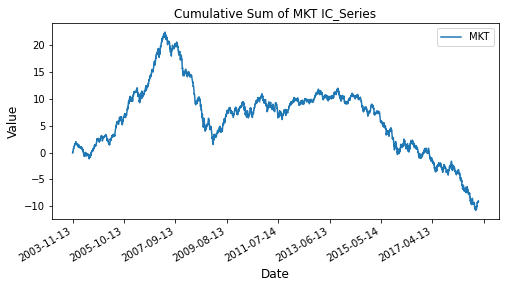

,IC,ICIR
MKT,-0.036556,-0.203455


In [391]:
## Plot Cumsum IC_Series of MKT
ax = IC_Series[['MKT']].cumsum().plot(title = 'Cumulative Sum of MKT IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.show()
pd.concat([all_ICs[["MKT"]],all_ICIRs[["MKT"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

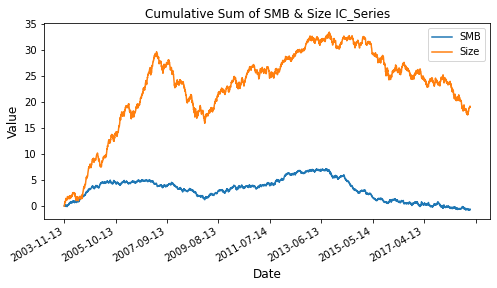

,IC,ICIR
SMB,-0.002672,-0.038310
Size,0.076955,0.456061


In [392]:
## Plot Cumsum IC_Series of SMB & Size
ax = IC_Series[["SMB","Size"]].cumsum().plot(title = 'Cumulative Sum of SMB & Size IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.show()
pd.concat([all_ICs[["SMB","Size"]],all_ICIRs[["SMB","Size"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

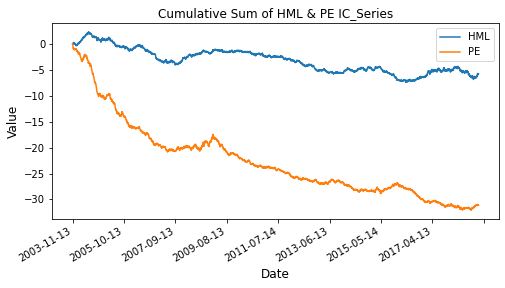

,IC,ICIR
HML,-0.023002,-0.337852
PE,-0.125138,-1.735563


In [393]:
## Plot Cumsum IC_Series of HML & PE
ax = IC_Series[["HML","PE"]].cumsum().plot(title = 'Cumulative Sum of HML & PE IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.show()
pd.concat([all_ICs[["HML","PE"]],all_ICIRs[["HML","PE"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

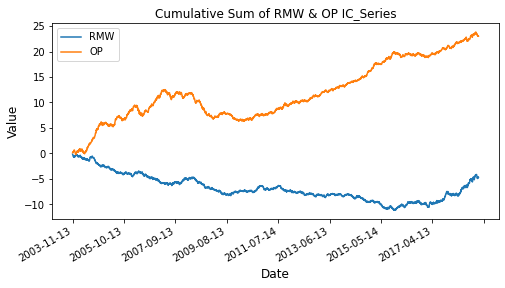

,IC,ICIR
RMW,-0.018756,-0.282855
OP,0.092540,1.303562


In [394]:
## Plot Cumsum IC_Series of RMW & OP
ax = IC_Series[["RMW","OP"]].cumsum().plot(title = 'Cumulative Sum of RMW & OP IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.show()
pd.concat([all_ICs[["RMW","OP"]],all_ICIRs[["RMW","OP"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

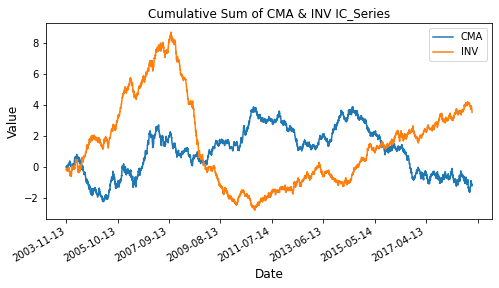

,IC,ICIR
CMA,-0.004478,-0.062658
INV,0.014157,0.222764


In [395]:
## Plot Cumsum IC_Series of CMA & INV
ax = IC_Series[["CMA","INV"]].cumsum().plot(title = 'Cumulative Sum of CMA & INV IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.show()
pd.concat([all_ICs[["CMA","INV"]],all_ICIRs[["CMA","INV"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

Overall speaking, the factor risks under the CAPM, FF3-factor model or FF5-factor model are all unpriced in the cross-section of individual stock returns, while the slope coefficients of SIZE, PE and OP are statistically significant under the OLS and IV estimation, respectively. These findings suggest that firm characteristics could be the better choice for proxying the true unknown factor loadings since they have stronger explanatory power than beta estimates. In the following section, this study evaluates the possibility of using firm characteristics as factor loadings in empirical asset pricing models to replace time-varying betas without causing the EIV problem in the second stage of FM regression when using individual stocks as test assets. 

# Compare TS and CS models

This section use the cross-section regression approach of FM to construct cross-sectional factor (CS factors) corresponding to the time-series factors (TS factors) of Fama and French (2015).

## TS Factor Model I

In [396]:
df_FF3

,MR_RF,SMB,HML
Dates,,,
2000-12-20,-0.0083,0.001267,0.00510
2000-12-21,-0.0062,0.001933,-0.00240
2000-12-22,0.0163,0.002433,0.00670
2000-12-25,-0.0003,0.000000,0.00000
2000-12-26,-0.0003,0.000000,0.00000
...,...,...,...
2019-02-27,0.0008,-0.003700,-0.00155
2019-02-28,-0.0055,0.005000,-0.00145
2019-03-01,0.0034,-0.003433,0.00380


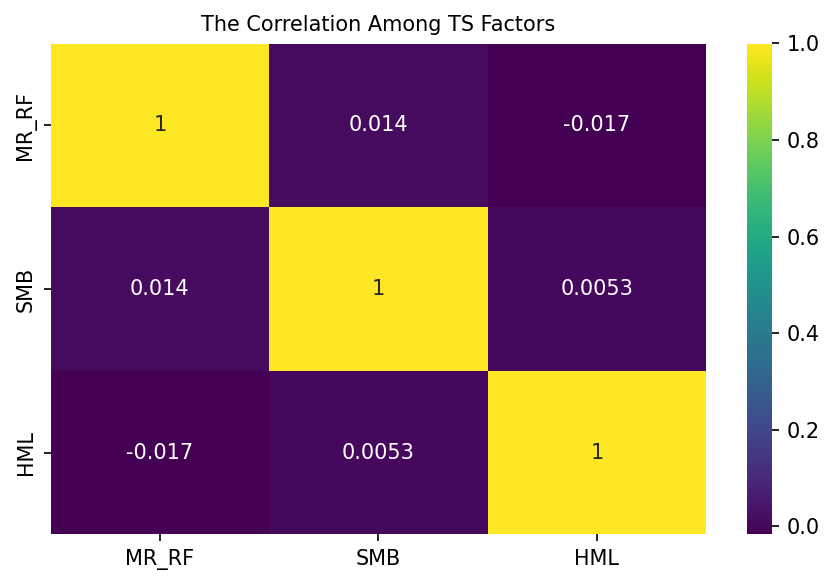

In [397]:
# Plot the correlation among FF3-Factor
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
corrMatrix = df_FF3.corr()
sn.heatmap(corrMatrix, annot=True, cmap="viridis")
plt.title('The Correlation Among TS Factors', fontsize=10)
plt.show()

TS factors are exactly the same as we used in FF5-Factor model

In [398]:
df_FF5

,MR_RF,SMB,HML,RMW,CMA
Dates,,,,,
2000-12-20,-0.0083,-0.0003,0.0052,-0.0016,0.0014
2000-12-21,-0.0062,0.0041,-0.0024,0.0004,0.0131
2000-12-22,0.0163,0.0027,0.0066,-0.0013,-0.0034
2000-12-25,-0.0003,0.0000,0.0000,0.0000,0.0000
2000-12-26,-0.0003,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...
2019-02-27,0.0008,-0.0033,-0.0015,-0.0005,-0.0010
2019-02-28,-0.0055,0.0032,-0.0015,0.0113,-0.0001
2019-03-01,0.0034,-0.0028,0.0037,0.0033,0.0052


Change the daily factor returns to monthly returns

In [399]:
m_df_FF5 = df_FF5
m_df_FF5['month'] = np.array(df_FF5.index.astype(str).str[:7])
m_df_FF5 = m_df_FF5.groupby('month').sum()
df_FF5 = df_FF5.drop(['month'], axis = 1)
# m_df_FF5 = m_df_FF5.iloc[:-1,:]
m_df_FF5

,MR_RF,SMB,HML,RMW,CMA
month,,,,,
2000-12,0.0107,-0.0029,0.0111,-0.0014,0.0021
2001-01,0.0851,-0.0018,-0.0045,-0.0324,0.0161
2001-02,-0.0068,0.0119,0.0353,0.0283,0.0519
2001-03,-0.0935,0.0192,0.0139,-0.0174,0.0412
2001-04,0.0921,-0.0157,0.0204,-0.0156,0.0160
...,...,...,...,...,...
2018-11,-0.0365,0.0014,-0.0235,0.0024,-0.0124
2018-12,0.0375,-0.0033,-0.0123,0.0085,0.0050
2019-01,0.0234,0.0057,0.0154,0.0151,0.0042


In [400]:
m_df_FF5.mean()*100

MR_RF    0.691045
SMB      0.205318
HML     -0.093909
RMW     -0.086682
CMA      0.052409
dtype: float64

In [401]:
m_df_FF5.std()

MR_RF    0.046434
SMB      0.013624
HML      0.017510
RMW      0.017026
CMA      0.017630
dtype: float64

In [402]:
m_df_FF5.apply(lambda x: stats.ttest_1samp(x,0))

,MR_RF,SMB,HML,RMW,CMA
0,2.207386,2.235227,-0.795491,-0.755142,0.440918
1,0.028325,0.026412,0.427189,0.450975,0.659708


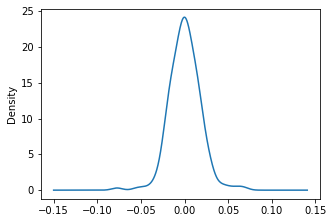

In [403]:
m_df_FF5.iloc[:,4].plot(kind='density')
# df_FF5.iloc[:,4].hist()
plt.show()

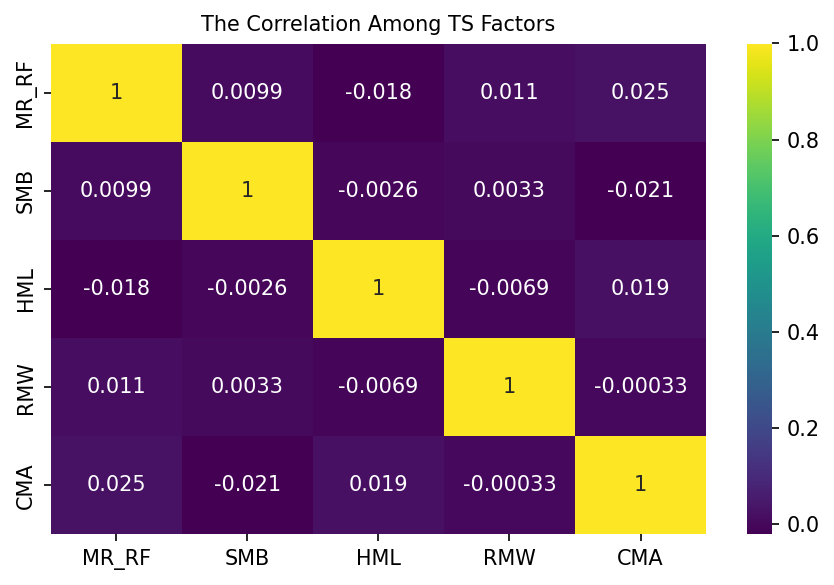

In [404]:
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
corrMatrix = df_FF5.corr()
sn.heatmap(corrMatrix, annot=True, cmap="viridis")
plt.title('The Correlation Among TS Factors', fontsize=10)
plt.show()

In [405]:
df_SR_tmp = df_SR.apply(replacer)
df_Ex_SR_tmp = df_SR_tmp - df_RF.values

Step-1: Use double-sorted portfolio return as regressors and then run time-series regression model to obtain factor loadings and interceptions, i.e. betas and alphas, with NW Adjustment

In [406]:
# Keep the excess stock returns and FF5-Factor returns have the same length
df_Ex_SR_trnct = df_Ex_SR_tmp.loc[df_FF5.index,:]

all_betas = []
all_cons_ts = []
all_std_errs = []
all_Rs = []
all_sd_res = []

betas = []
labels = []
cons_ts = []
std_errs = []
Rs = []
sd_res = []

for j in tqdm(df_Ex_SR.columns):

    df_index = (df_Ex_SR_trnct.loc[:, j].dropna().index).intersection(df_FF5.index)

    if len(df_index) > 10:
        lag = int(4*((len(df_Ex_SR_trnct.loc[df_index, j]))/100)**(1/9))
        ols = sm.OLS(df_Ex_SR_trnct.loc[df_index, j].astype(np.float64), sm.add_constant(
            df_FF5.loc[df_index, :].astype(np.float64)))
        res = ols.fit(cov_type='HAC', cov_kwds={'maxlags': lag})

        b = list(res.params)
        t = res.tvalues[0]
        se = res.bse[0]
        r = res.rsquared
        sr = res.resid.std()
        betas.append(b)
        cons_ts.append(t)
        std_errs.append(se)
        Rs.append(r)
        sd_res.append(sr)
        labels.append(j)

all_betas.append(pd.DataFrame(betas))
all_cons_ts.append(pd.DataFrame(cons_ts))
all_std_errs.append(pd.DataFrame(std_errs))
all_Rs.append(pd.DataFrame(Rs))
all_sd_res.append(pd.DataFrame(sd_res))

100%|██████████| 740/740 [00:03<00:00, 187.33it/s]


In [407]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ZSA.SJ.Equity   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.204
Date:                Mon, 02 May 2022   Prob (F-statistic):              0.305
Time:                        14:27:36   Log-Likelihood:                 7115.7
No. Observations:                2330   AIC:                        -1.422e+04
Df Residuals:                    2324   BIC:                        -1.418e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.684      0.494      -0.000       0.001
MR_RF          0.0121      0.016      0.759      0.448      -0.019       0.043
SMB            0.0624      0.066      0.945      0.345      -0.067       0.192
HML            0.0199      0.051      0.391      0.696      -0.080       0.120
RMW           -0.0233      0.046     -0.509      0.611      -0.113       0.066
CMA            0.1010      0.048      2.120      0.034       0.008       0.194
==============================================================================
Omnibus:                      411.302   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7222.062
Skew:                           0.280   Prob(JB):                         0.00
Kurtosis:                      11.607   Cond. No.                         267.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

In [408]:
TS_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
TS_betas.columns = ['Intercepts','MKT','SMB','HML','RMW','CMA','Stocks']
TS_betas = TS_betas.set_index('Stocks')
TS_betas

,Intercepts,MKT,SMB,HML,RMW,CMA
Stocks,,,,,,
ABC.SJ.Equity,-0.003048,-0.334855,-1.038481,2.287313,1.736295,0.155451
ABI.SJ.Equity,0.000293,0.250634,-0.027526,-0.026816,-0.052584,0.015525
ABK.SJ.Equity,-0.002319,0.223503,-2.430166,2.617665,1.897113,0.505996
ABR.SJ.Equity,-0.006584,-0.389331,3.760604,-0.545912,1.553621,-0.163119
ABU.SJ.Equity,-0.000460,0.013298,0.056566,0.179378,-0.216206,-0.083836
...,...,...,...,...,...,...
ZGOVI.SJ.Equity,0.000053,0.048067,-0.005870,-0.025272,-0.036429,-0.027054
ZPT.SJ.Equity,-0.002632,0.100060,-0.095590,-0.209509,0.405521,-0.727316
ZRNHDG.SJ.Equity,-0.000383,0.030242,0.154120,0.025129,-0.110328,-0.119765


In [409]:
## The alphas are missing pricing errors of asset pricing model (FF5-Factor), which are also the intercepts of time series regression
TS_alphas = TS_betas.iloc[:,0]
TS_alphas.describe()

count    708.000000
mean      -0.000724
std        0.002416
min       -0.019502
25%       -0.000787
50%       -0.000082
75%        0.000244
max        0.006842
Name: Intercepts, dtype: float64

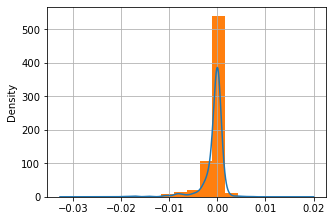

In [410]:
TS_alphas.plot(kind='density')
TS_alphas.hist()
plt.show()

In [411]:
all_cons_ts[0]

,0
0,-1.128583
1,0.932694
2,-1.452077
3,-2.011185
4,-0.748997
...,...
703,0.495672
704,-2.008599
705,-1.121602
706,0.333480


In [412]:
all_ses = pd.DataFrame(all_std_errs[0])
all_ses.index = TS_alphas.index
all_ses.columns = ['std_errs']
all_ses

,std_errs
Stocks,
ABC.SJ.Equity,0.002701
ABI.SJ.Equity,0.000314
ABK.SJ.Equity,0.001597
ABR.SJ.Equity,0.003274
ABU.SJ.Equity,0.000614
...,...
ZGOVI.SJ.Equity,0.000106
ZPT.SJ.Equity,0.001310
ZRNHDG.SJ.Equity,0.000342


In [413]:
TS_alphas_t = pd.concat([all_cons_ts[0], pd.DataFrame(labels)], axis = 1)
TS_alphas_t.columns = ['t-statistics','Stocks']
TS_alphas_t = TS_alphas_t.set_index('Stocks')
TS_alphas_t

,t-statistics
Stocks,
ABC.SJ.Equity,-1.128583
ABI.SJ.Equity,0.932694
ABK.SJ.Equity,-1.452077
ABR.SJ.Equity,-2.011185
ABU.SJ.Equity,-0.748997
...,...
ZGOVI.SJ.Equity,0.495672
ZPT.SJ.Equity,-2.008599
ZRNHDG.SJ.Equity,-1.121602


### Results_1

Step2: Calculate the absolute value of alphas and alphas_t, then calculate their mean respectively

In [414]:
print(np.mean(abs(TS_alphas))*21*100,np.nanmean(abs(TS_alphas_t)))

2.4473105113330336 1.2311180418810375


Step3: Calculate the cross-sectional variance of LHS average returns and then divided by the mean of squared alphas

In [415]:
cs_var = np.var(df_SR_tmp.apply(lambda x: np.mean(x), axis = 0))
print(np.mean(np.square(TS_alphas))/cs_var)

0.9212533564720019


Step4: Substract the squared standard error of each intercept to adjust for the noise in the Step-3

In [416]:
A_lamda = np.mean((pd.DataFrame(np.square(TS_alphas).values)-pd.DataFrame(np.square(all_ses).values)), axis = 0)
print(A_lamda/cs_var)

0    0.732419
dtype: float64


Step5: the average of the regression R^2; the average of the standard errors of the intercepts; the average of the standard deviations of the regression residuals.

In [417]:
print('AR^2: ' + str(np.mean(all_Rs)), 'As(a): ' + str(np.mean(all_ses.values)*np.sqrt(21)), \
      'As(e): ' + str(np.mean(all_sd_res)*np.sqrt(21)))

AR^2: 0.06929980236597638 As(a): 0.0035768601563833523 As(e): 0.12838075864403103


Step6: Calculate Cross-sectional R-squared, how much the total variance of expected stock returns can be explained by the model?

In [418]:
1-(np.var(TS_alphas)/np.var(df_Ex_SR_tmp.mean()))

0.16185540585253944

## CS Factor Model I

Import 18 double-sorted portfolios returns

In [419]:
df_18_PR

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,-0.0073,-0.0060,-0.0009,-0.0023,-0.0005,-0.0015,-0.0062,-0.0036,-0.0100,0.0022,0.0018,-0.0145,-0.0047,-0.0025,-0.0024,-0.0034,-0.0029,-0.0023
2000-12-21,-0.0117,0.0029,-0.0113,-0.0101,-0.0115,-0.0102,0.0039,-0.0145,-0.0099,-0.0054,-0.0077,-0.0010,-0.0020,-0.0041,-0.0026,0.0012,-0.0053,-0.0111
2000-12-22,0.0099,0.0028,0.0002,-0.0040,0.0139,0.0072,0.0021,-0.0022,0.0051,0.0110,0.0017,0.0075,0.0031,0.0043,-0.0055,0.0015,0.0107,0.0052
2000-12-25,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2000-12-26,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,0.0046,-0.0023,0.0026,0.0034,0.0008,0.0024,0.0046,-0.0011,0.0003,-0.0056,-0.0001,-0.0005,-0.0028,-0.0002,-0.0008,-0.0011,-0.0087,0.0051
2019-02-28,-0.0065,-0.0079,0.0032,0.0003,-0.0054,-0.0055,-0.0038,-0.0009,-0.0054,0.0016,0.0075,-0.0052,0.0064,0.0006,-0.0103,-0.0023,0.0027,-0.0004
2019-03-01,0.0093,-0.0046,-0.0010,0.0002,0.0056,-0.0022,0.0047,-0.0043,0.0013,-0.0059,0.0023,-0.0030,0.0004,-0.0006,-0.0037,0.0034,-0.0047,-0.0036


Import Firm Characteristics of 18 double-sorted portfolios

In [420]:
df_18_std_Size

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,-0.781312,-0.090458,1.848094,1.815374,-0.512456,-0.539452,-0.085595,2.283493,-0.529163,0.053609,-0.920952,-0.266229,-0.185330,-1.305537,-0.221338,-0.737976,-0.327963,0.503191
2000-12-21,-0.781312,-0.090458,1.848094,1.815374,-0.512456,-0.539452,-0.085595,2.283493,-0.529163,0.053609,-0.920952,-0.266229,-0.185330,-1.305537,-0.221338,-0.737976,-0.327963,0.503191
2000-12-22,-0.781312,-0.090458,1.848094,1.815374,-0.512456,-0.539452,-0.085595,2.283493,-0.529163,0.053609,-0.920952,-0.266229,-0.185330,-1.305537,-0.221338,-0.737976,-0.327963,0.503191
2000-12-25,-0.781151,-0.079474,1.850319,1.826738,-0.513155,-0.540065,-0.087661,2.273843,-0.529809,0.051098,-0.920344,-0.267716,-0.187077,-1.304010,-0.222969,-0.737953,-0.329854,0.499240
2000-12-26,-0.781046,-0.072916,1.851627,1.833502,-0.513567,-0.540425,-0.088893,2.268058,-0.530188,0.049598,-0.919971,-0.268601,-0.188117,-1.303084,-0.223941,-0.737932,-0.330980,0.496877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-1.119487,1.546268,1.219728,1.561739,-1.873820,0.925591,0.794177,0.806161,0.257729,-0.307066,-1.070146,0.035157,-0.631996,-0.982620,-0.504375,0.158873,-0.905899,0.089987
2019-02-28,-1.120516,1.545925,1.220317,1.561396,-1.874255,0.925393,0.794072,0.805870,0.257367,-0.305990,-1.070054,0.034886,-0.631920,-0.982048,-0.504543,0.159395,-0.905694,0.090398
2019-03-01,-1.121537,1.545585,1.220903,1.561055,-1.874687,0.925196,0.793969,0.805582,0.257008,-0.304922,-1.069963,0.034616,-0.631845,-0.981479,-0.504710,0.159913,-0.905489,0.090807


In [421]:
df_18_std_PE

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,0.474577,-0.596427,1.589434,1.332862,-0.036290,-0.166038,-0.785416,2.553218,-1.192850,0.558439,-0.839326,-1.097937,0.077891,-0.655950,-0.763018,-0.183795,-0.465047,0.195671
2000-12-21,0.488083,-0.579499,1.607375,1.319233,-0.018389,-0.133995,-0.780162,2.543136,-1.205060,0.544398,-0.843136,-1.102449,0.090430,-0.652080,-0.797120,-0.156331,-0.467808,0.143373
2000-12-22,0.529640,-0.589796,1.612475,1.280541,0.014783,-0.108110,-0.789886,2.512530,-1.225850,0.568047,-0.856767,-1.119877,0.102469,-0.660567,-0.814292,-0.141778,-0.465314,0.151752
2000-12-25,0.551065,-0.595016,1.614802,1.260246,0.031965,-0.094679,-0.794770,2.496185,-1.236381,0.580187,-0.863662,-1.128686,0.108686,-0.664834,-0.823029,-0.134212,-0.463931,0.156063
2000-12-26,0.564130,-0.598168,1.616119,1.247754,0.042469,-0.086460,-0.797704,2.486026,-1.242739,0.587572,-0.867821,-1.133999,0.112480,-0.667400,-0.828317,-0.129576,-0.463055,0.158689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-0.912531,-0.789055,-0.220451,-0.542673,-0.147525,-1.058409,-0.605954,-0.766705,-0.125978,-0.962525,1.547041,0.748977,2.423917,-0.225811,-0.722433,1.450073,0.803500,0.106542
2019-02-28,-0.912004,-0.789580,-0.221151,-0.542742,-0.148195,-1.058445,-0.605969,-0.767175,-0.126434,-0.959334,1.548040,0.745663,2.425584,-0.226983,-0.722001,1.445591,0.810998,0.104138
2019-03-01,-0.911462,-0.790103,-0.221840,-0.542804,-0.148841,-1.058479,-0.605974,-0.767637,-0.126874,-0.956164,1.549032,0.742338,2.427231,-0.228166,-0.721564,1.441149,0.818401,0.101757


In [422]:
df_18_std_OP

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,0.256084,0.237906,0.245898,0.241780,0.223827,0.228190,0.221341,0.238552,0.236203,0.251100,0.256273,0.245066,-4.006389,0.218152,0.245097,0.185385,0.236185,0.239349
2000-12-21,0.256084,0.237906,0.245898,0.241780,0.223827,0.228190,0.221341,0.238552,0.236203,0.251100,0.256273,0.245066,-4.006389,0.218152,0.245097,0.185385,0.236185,0.239349
2000-12-22,0.256084,0.237906,0.245898,0.241780,0.223827,0.228190,0.221341,0.238552,0.236203,0.251100,0.256273,0.245066,-4.006389,0.218152,0.245097,0.185385,0.236185,0.239349
2000-12-25,0.256059,0.237915,0.245878,0.241787,0.223802,0.228165,0.221316,0.238527,0.236178,0.251075,0.256248,0.245041,-4.006389,0.218247,0.245072,0.185360,0.236395,0.239324
2000-12-26,0.256044,0.237920,0.245866,0.241791,0.223787,0.228150,0.221301,0.238512,0.236163,0.251060,0.256233,0.245026,-4.006389,0.218304,0.245057,0.185346,0.236521,0.239309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-1.822343,0.190651,0.692564,0.233343,-1.633859,0.126999,0.338755,-2.246118,0.197442,0.744658,-0.061178,0.999833,0.669821,-0.491681,1.164673,0.893887,-0.639183,0.641739
2019-02-28,-1.819476,0.192292,0.693698,0.234584,-1.630909,0.128631,0.340308,-2.242932,0.198849,0.745867,-0.069338,1.000860,0.671239,-0.498761,1.165169,0.894908,-0.647910,0.642919
2019-03-01,-1.816610,0.193915,0.694811,0.235810,-1.627963,0.130246,0.341842,-2.239745,0.200240,0.747055,-0.077420,1.001863,0.672635,-0.505766,1.165644,0.895907,-0.656544,0.644080


In [423]:
df_18_std_INV

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,0.768570,-0.398832,1.031163,1.400032,-0.046577,-0.380944,-1.046655,1.388225,0.202530,0.412823,-2.160876,0.963404,0.287319,0.334560,-1.796433,-0.221710,0.134608,-0.871205
2000-12-21,0.768570,-0.398832,1.031163,1.400032,-0.046577,-0.380944,-1.046655,1.388225,0.202530,0.412823,-2.160876,0.963404,0.287319,0.334560,-1.796433,-0.221710,0.134608,-0.871205
2000-12-22,0.768570,-0.398832,1.031163,1.400032,-0.046577,-0.380944,-1.046655,1.388225,0.202530,0.412823,-2.160876,0.963404,0.287319,0.334560,-1.796433,-0.221710,0.134608,-0.871205
2000-12-25,0.768539,-0.398856,1.031130,1.399997,-0.046603,-0.380968,-1.046675,1.388190,0.202502,0.412794,-2.160889,0.963371,0.287290,0.334757,-1.796448,-0.221735,0.134831,-0.871226
2000-12-26,0.768520,-0.398870,1.031110,1.399975,-0.046619,-0.380983,-1.046687,1.388168,0.202485,0.412777,-2.160897,0.963351,0.287273,0.334875,-1.796457,-0.221750,0.134965,-0.871239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-1.069522,-0.159000,0.448745,0.143181,-1.315148,-0.636402,-0.887761,-0.243377,-0.581160,0.508384,0.064759,-0.671813,0.293570,2.396380,-0.387844,-0.765149,0.754837,2.107319
2019-02-28,-1.068774,-0.158231,0.448903,0.143600,-1.314676,-0.635661,-0.887531,-0.242751,-0.580637,0.510198,0.062881,-0.672476,0.292775,2.396644,-0.389196,-0.765775,0.752663,2.108043
2019-03-01,-1.068033,-0.157469,0.449060,0.144016,-1.314207,-0.634927,-0.887302,-0.242130,-0.580118,0.511996,0.061020,-0.673132,0.291987,2.396903,-0.390536,-0.766394,0.750507,2.108759


Step-1: Use 18 (3*6) doubt-sorted portfolios as test assets and run CS regression to obtain R_zt and four pure factor returns;

In [424]:
all_lambdas = []
all_intercepts = []

lambdas = []
intercepts = []
Dates = []
index_times = list(df_18_PR.T.columns)

for k in tqdm(df_18_PR.T.columns):

    df_index = ((((df_18_std_Size.T.loc[:, k].replace(-np.inf, np.nan).dropna().index).
                 intersection(df_18_std_PE.T.loc[:, k].replace(-np.inf, np.nan).dropna().index)).
                 intersection(df_18_PR.T.loc[:, index_times[index_times.index(k)]].dropna().index)).
                intersection(df_18_std_OP.T.loc[:, k].dropna().index)).\
        intersection(df_18_std_INV.T.loc[:, k].dropna().index)

    if len(df_index) > 10:

        l = list(ols_model.fit((pd.concat([df_18_std_Size.T.loc[df_index, k],
                                           df_18_std_PE.T.loc[df_index, k],
                                           df_18_std_OP.T.loc[df_index, k],
                                           df_18_std_INV.T.loc[df_index, k]], axis=1).values),
                               (df_18_PR.T.loc[df_index, index_times[index_times.index(k)]].values)).coef_)

        h = ols_model.fit((pd.concat([df_18_std_Size.T.loc[df_index, k],
                                      df_18_std_PE.T.loc[df_index, k],
                                      df_18_std_OP.T.loc[df_index, k],
                                      df_18_std_INV.T.loc[df_index, k]], axis=1).values),
                          (df_18_PR.T.loc[df_index, index_times[index_times.index(k)]].values)).intercept_

        lambdas.append(l)
        intercepts.append(h)
        Dates.append(k)

all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 4750/4750 [00:24<00:00, 195.50it/s]


In [425]:
## Through performing FM-2 at each time t, we got the pure factor return time-series for MC/PE/OP/INV and intercept (Rzt)
df_CS_FF4 = pd.concat([all_lambdas[0], pd.DataFrame(Dates)], axis = 1)
df_CS_FF4.columns = ['Size','PE','OP','INV','Dates']
df_CS_FF4 = df_CS_FF4.set_index(['Dates'])
df_CS_FF4

,Size,PE,OP,INV
Dates,,,,
2000-12-20,-0.002219,0.005138,0.000221,-0.003126
2000-12-21,0.001642,-0.004612,-0.001245,-0.000050
2000-12-22,-0.004914,0.001391,0.000704,0.002304
2000-12-25,0.000000,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
2019-02-27,0.000652,-0.000818,-0.000087,-0.000338
2019-02-28,0.001025,0.003372,-0.001396,0.002380
2019-03-01,-0.001015,0.000596,-0.000910,-0.001947


In [426]:
df_Rzt = pd.concat([all_intercepts[0], pd.DataFrame(Dates)], axis = 1)
df_Rzt.columns = ['Rzt','Dates']
df_Rzt = df_Rzt.set_index(['Dates'])
df_Rzt

,Rzt
Dates,
2000-12-20,-0.003722
2000-12-21,-0.006133
2000-12-22,0.004139
2000-12-25,0.000000
2000-12-26,0.000000
...,...
2019-02-27,0.000033
2019-02-28,-0.001739
2019-03-01,-0.000356


In [427]:
df_18_PR.T.mean()

Dates
2000-12-20   -0.003722
2000-12-21   -0.006133
2000-12-22    0.004139
2000-12-25    0.000000
2000-12-26    0.000000
                ...   
2019-02-27    0.000033
2019-02-28   -0.001739
2019-03-01   -0.000356
2019-03-04   -0.005783
2019-03-05   -0.005794
Length: 4750, dtype: float64

In [428]:
df_18_CS = pd.concat([df_Rzt, df_CS_FF4], axis = 1)
df_18_CS

,Rzt,Size,PE,OP,INV
Dates,,,,,
2000-12-20,-0.003722,-0.002219,0.005138,0.000221,-0.003126
2000-12-21,-0.006133,0.001642,-0.004612,-0.001245,-0.000050
2000-12-22,0.004139,-0.004914,0.001391,0.000704,0.002304
2000-12-25,0.000000,0.000000,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2019-02-27,0.000033,0.000652,-0.000818,-0.000087,-0.000338
2019-02-28,-0.001739,0.001025,0.003372,-0.001396,0.002380
2019-03-01,-0.000356,-0.001015,0.000596,-0.000910,-0.001947


In [429]:
m_df_18_CS = df_18_CS
m_df_18_CS['month'] = np.array(df_18_CS.index.astype(str).str[:7])
m_df_18_CS = m_df_18_CS.groupby('month').sum()
df_18_CS = df_18_CS.drop(['month'], axis = 1)
m_df_18_CS

,Rzt,Size,PE,OP,INV
month,,,,,
2000-12,0.001094,-0.001173,0.006252,-0.000043,-0.005313
2001-01,0.016628,-0.000512,-0.002723,0.017843,-0.004205
2001-02,-0.040833,-0.005694,-0.006495,0.001204,0.007325
2001-03,-0.069833,-0.019823,-0.006094,0.004065,0.009242
2001-04,0.014544,-0.003783,0.001582,0.006713,0.001222
...,...,...,...,...,...
2018-11,-0.013700,0.003682,0.002859,-0.002692,-0.000510
2018-12,0.000017,0.003689,0.002830,0.002037,-0.003744
2019-01,-0.006283,0.002958,0.000984,-0.004186,0.007980


In [430]:
m_df_18_CS.mean()*100

Rzt    -0.026467
Size   -0.006001
PE     -0.042715
OP      0.072005
INV    -0.055079
dtype: float64

In [431]:
m_df_18_CS.std()

Rzt     0.029195
Size    0.005752
PE      0.005315
OP      0.005658
INV     0.005674
dtype: float64

In [432]:
m_df_18_CS.apply(lambda x: stats.ttest_1samp(x,0))

,Rzt,Size,PE,OP,INV
0,-0.134466,-0.154748,-1.192146,1.887633,-1.439917
1,0.893157,0.877163,0.234494,0.060398,0.151319


In [433]:
df_18_CS.apply(lambda x: stats.ttest_1samp(x,0))

,Rzt,Size,PE,OP,INV
0,-0.193128,-0.130871,-0.940907,1.559667,-1.147775
1,0.846867,0.895883,0.346800,0.118905,0.251119


Step-2: (Mis-Pricing error at each time t)-> alpha,it = R,it - (Rz,t + firm characteristics,i*lambda,t), t=1,2,3,...,T, 

In [434]:
df_ln_Size = df_ln_Size_trnct
df_std_PE = df_PE_trnct
df_std_OP = df_OP_trnct
df_std_INV = df_INV_trnct

In [435]:
len(df_ln_Size)==len(df_std_PE)==len(df_std_OP)==len(df_std_INV)

True

In [436]:
# Constant Version of CS factor model I
# (average beta) * lambda + Rz
# Prediction = df_ln_Size.apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,0])+\
# df_std_PE.apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,1])+\
# df_std_OP.apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,2])+\
# df_std_INV.apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,3])

In [437]:
# Time-varying Version of CS factor model I
# beta * lambda + Rz
Prediction = df_ln_Size.apply(lambda x: x * df_CS_FF4.iloc[:,0])+\
df_std_PE.apply(lambda x: x * df_CS_FF4.iloc[:,1])+\
df_std_OP.apply(lambda x: x * df_CS_FF4.iloc[:,2])+\
df_std_INV.apply(lambda x: x * df_CS_FF4.iloc[:,3])

In [438]:
intc_index = df_SR.index.intersection(Prediction.index)
intc_columns = df_SR.columns.intersection(Prediction.columns)

In [439]:
Prediction.loc[intc_index,intc_columns]

,ABC.SJ.Equity,ABI.SJ.Equity,ABK.SJ.Equity,ABR.SJ.Equity,ABU.SJ.Equity,ACE.SJ.Equity,ACL.SJ.Equity,ACP.SJ.Equity,ACR.SJ.Equity,ACS.SJ.Equity,...,WTC.SJ.Equity,WTL.SJ.Equity,YRK.SJ.Equity,ZED.SJ.Equity,ZGOVI.SJ.Equity,ZPT.SJ.Equity,ZRNHDG.SJ.Equity,ZRNPLY.SJ.Equity,ZRR.SJ.Equity,ZSA.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,NaN,NaN,NaN,NaN,NaN,NaN,-0.021909,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006119,NaN
2000-12-21,NaN,NaN,NaN,NaN,NaN,NaN,0.016398,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000193,NaN
2000-12-22,NaN,NaN,NaN,NaN,NaN,NaN,-0.039936,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.018782,NaN
2000-12-25,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2000-12-26,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,NaN,0.005886,0.002428,NaN,0.003191,0.003358,0.006450,0.006047,NaN,0.006470,...,NaN,0.003154,0.004823,0.006405,NaN,0.001652,NaN,NaN,0.000951,NaN
2019-02-28,NaN,0.011282,0.001122,NaN,0.006734,0.005714,0.002603,0.012185,NaN,0.007034,...,NaN,0.003272,0.005834,0.001876,NaN,0.001008,NaN,NaN,-0.002639,NaN
2019-03-01,NaN,-0.009255,-0.003230,NaN,-0.003907,-0.000643,-0.006837,-0.011177,NaN,-0.010343,...,NaN,-0.003470,-0.004823,-0.005254,NaN,-0.001640,NaN,NaN,-0.000493,NaN


In [440]:
df_SR_tmp.loc[intc_index,intc_columns]

,ABC.SJ.Equity,ABI.SJ.Equity,ABK.SJ.Equity,ABR.SJ.Equity,ABU.SJ.Equity,ACE.SJ.Equity,ACL.SJ.Equity,ACP.SJ.Equity,ACR.SJ.Equity,ACS.SJ.Equity,...,WTC.SJ.Equity,WTL.SJ.Equity,YRK.SJ.Equity,ZED.SJ.Equity,ZGOVI.SJ.Equity,ZPT.SJ.Equity,ZRNHDG.SJ.Equity,ZRNPLY.SJ.Equity,ZRR.SJ.Equity,ZSA.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,-0.117783,0.000000,NaN,0.0,NaN,NaN,-0.081238,NaN,0.0,NaN,...,0.0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.0,0.0
2000-12-21,0.000000,-0.007168,NaN,0.0,NaN,NaN,0.045124,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.057158,NaN,NaN,0.0,0.0
2000-12-22,0.000000,0.002395,NaN,0.0,NaN,NaN,0.029003,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.057158,NaN,NaN,0.0,0.0
2000-12-25,0.000000,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.0,NaN
2000-12-26,0.000000,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,NaN,NaN,NaN,NaN,NaN,0.0,0.002954,NaN,NaN,0.0,...,NaN,NaN,0.083382,0.014252,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-28,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,NaN,0.0,...,NaN,NaN,0.000000,-0.002361,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01,NaN,NaN,NaN,NaN,NaN,0.0,0.054533,NaN,NaN,0.0,...,NaN,NaN,0.000000,0.014085,NaN,NaN,NaN,NaN,NaN,NaN


After obtaining the return prediction of each stock i at each time t, we now can calculate the mis-pricing errors of CS factor models by using real stock time subtract its corresponding prediction return

In [441]:
df_alphas = df_SR_tmp.loc[intc_index,intc_columns].apply(lambda x: x - df_Rzt.iloc[:,0]) - Prediction.loc[intc_index,intc_columns]
df_alphas

,ABC.SJ.Equity,ABI.SJ.Equity,ABK.SJ.Equity,ABR.SJ.Equity,ABU.SJ.Equity,ACE.SJ.Equity,ACL.SJ.Equity,ACP.SJ.Equity,ACR.SJ.Equity,ACS.SJ.Equity,...,WTC.SJ.Equity,WTL.SJ.Equity,YRK.SJ.Equity,ZED.SJ.Equity,ZGOVI.SJ.Equity,ZPT.SJ.Equity,ZRNHDG.SJ.Equity,ZRNPLY.SJ.Equity,ZRR.SJ.Equity,ZSA.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,NaN,NaN,NaN,NaN,NaN,NaN,-0.055607,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009841,NaN
2000-12-21,NaN,NaN,NaN,NaN,NaN,NaN,0.034859,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005940,NaN
2000-12-22,NaN,NaN,NaN,NaN,NaN,NaN,0.064800,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014643,NaN
2000-12-25,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2000-12-26,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,NaN,NaN,NaN,NaN,NaN,-0.003391,-0.003529,NaN,NaN,-0.006504,...,NaN,NaN,0.078526,0.007814,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-28,NaN,NaN,NaN,NaN,NaN,-0.003975,-0.000864,NaN,NaN,-0.005295,...,NaN,NaN,-0.004096,-0.002498,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01,NaN,NaN,NaN,NaN,NaN,0.000999,0.061725,NaN,NaN,0.010699,...,NaN,NaN,0.005179,0.019694,NaN,NaN,NaN,NaN,NaN,NaN


Step-3: Use t.test to Calculate the time-series mean of alpha,it and obtain their corresponding t-statistics

In [442]:
TSmean_alphas = df_alphas.apply(lambda x: np.mean(x))
TSmean_alphas.describe()

count    467.000000
mean      -0.000150
std        0.001718
min       -0.019841
25%       -0.000365
50%        0.000192
75%        0.000531
max        0.004141
dtype: float64

In [443]:
tstats_alphas = df_alphas.apply(lambda x: np.NaN if np.all(x!=x) else stats.ttest_1samp(x,0.0,nan_policy='omit')[0])
tstats_alphas = pd.DataFrame(tstats_alphas)
tstats_alphas.T

,ABC.SJ.Equity,ABI.SJ.Equity,ABK.SJ.Equity,ABR.SJ.Equity,ABU.SJ.Equity,ACE.SJ.Equity,ACL.SJ.Equity,ACP.SJ.Equity,ACR.SJ.Equity,ACS.SJ.Equity,...,WTC.SJ.Equity,WTL.SJ.Equity,YRK.SJ.Equity,ZED.SJ.Equity,ZGOVI.SJ.Equity,ZPT.SJ.Equity,ZRNHDG.SJ.Equity,ZRNPLY.SJ.Equity,ZRR.SJ.Equity,ZSA.SJ.Equity
0,NaN,1.153396,-0.814727,NaN,1.807498,0.138438,0.184006,1.109656,NaN,-0.496741,...,NaN,-1.970668,-0.013423,0.647801,NaN,-0.725099,NaN,NaN,0.731955,NaN


In [444]:
# calculate the percentage of NAs in Alphas
np.sum(df_alphas.apply(lambda x: np.isnan(x).sum()==len(x), axis = 0))/df_alphas.shape[1]

0.3689189189189189

Step-4: Alpha Test: Calcualte the mean of abs(alphas,i) and abs(t.statistic_alphas,i) 

### Results_2

In [445]:
### Calculate the absolute value of alphas and alphas_t, then calculate their mean respectively
print(np.mean(abs(TSmean_alphas))*21*100,np.nanmean(abs(tstats_alphas)))

1.9439936727986142 0.971466752424989


In [446]:
### Calculate the squared alphas and then divided by the cross-sectional variance of LHS average returns  
cs_var = np.var(df_SR_tmp.apply(lambda x: np.mean(x), axis = 0))
print(np.mean(np.square(TSmean_alphas))/cs_var)

0.4305254247520458


In [447]:
### Substract the squared standard error of each intercept to adjust for the noise in the Step-3
alphas_se = df_alphas.apply(lambda x: np.std(x)/np.sqrt(len(x)))
A_lamda = np.mean((pd.DataFrame(np.square(TSmean_alphas).values)-pd.DataFrame(np.square(alphas_se).values)), axis = 0)
print(A_lamda/cs_var)

0    0.384559
dtype: float64


In [448]:
## calculate the time-series regression R-squared for model i (i <- 0~[N-1])
# SST1 = np.square(df_Ex_SR.iloc[:,1] - df_Ex_SR.iloc[:,1].mean()).sum()
# SS_res1 = np.square(df_alphas.iloc[:,1]).mean()
# R_sqr1 = 1 - (SS_res1/SST1)
# R_sqr1 

In [449]:
## loop the above procedure
SST = np.square(df_SR_tmp.apply(lambda x: x-np.mean(x))).sum()
SS_res = np.square(df_alphas).mean()
R_sqr = 1 - SS_res/SST

In [450]:
#### calculate the time-series R^2 for CS factor model I
SST_1 = np.square(df_SR_tmp.apply(lambda x: x-np.mean(x))).sum()
R_sqrt = 1-((np.square(df_alphas).mean())/SST_1)

In [451]:
R_sqrt.describe()

count    467.000000
mean       0.998797
std        0.007095
min        0.848803
25%        0.999019
50%        0.999519
75%        0.999722
max        0.999943
dtype: float64

In [452]:
alpha_ses = df_alphas.apply(lambda x: np.NaN if np.all(x!=x) else np.std(x)/np.sqrt(len(x)))
alpha_sds =  df_alphas.apply(lambda x: np.NaN if np.all(x!=x) else np.std(x))

In [453]:
### the average of the regression R^2; the average of the standard errors of the intercepts; 
### the average of the standard deviations of the regression residuals.
print('AR^2: ' + str(np.nanmean(R_sqr.values)), 'As(a): ' + str(np.mean(alpha_ses)*np.sqrt(21)), \
      'As(e): ' + str(np.mean(alpha_sds)*np.sqrt(21)))

AR^2: 0.9987971866058228 As(a): 0.002240386541736659 As(e): 0.15440798657412474


In [454]:
## Calculate Cross-sectional R-squared, how much the total variance of expected stock returns can be explained by the model?
1-(np.var(df_alphas.mean())/np.var(df_Ex_SR_tmp.mean()))

0.5763419070005416

### Cross-section Factor Model II

In [455]:
## Step-1: Use firm characteristics as factor loadings in FM-2 regression and get the pure factor returns 
## Step-2: Use pure factor return from step-1 and run time-series regression get cross-sectional betas and alphas(mis-pricing errors), with NW Adjustment
## Step-3: Alpha Test: Calcualte the mean of abs(alphas,i) and abs(t.statistic_alphas,i) 

In [456]:
## Through FM cross-sectional regression, we got the pure factor return of MC/PE/OP/INV
df_CS_FF4

,Size,PE,OP,INV
Dates,,,,
2000-12-20,-0.002219,0.005138,0.000221,-0.003126
2000-12-21,0.001642,-0.004612,-0.001245,-0.000050
2000-12-22,-0.004914,0.001391,0.000704,0.002304
2000-12-25,0.000000,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
2019-02-27,0.000652,-0.000818,-0.000087,-0.000338
2019-02-28,0.001025,0.003372,-0.001396,0.002380
2019-03-01,-0.001015,0.000596,-0.000910,-0.001947


In [457]:
## Test FF5CS-Factor Asset Pricing Models by using TS Regression

In [458]:
df_MR

,MR_RF
Dates,
2000-01-05,-0.0108
2000-01-06,0.0012
2000-01-07,0.0248
2000-01-10,0.0323
2000-01-11,0.0024
...,...
2019-12-25,-0.0002
2019-12-26,-0.0002
2019-12-27,0.0031


In [459]:
df_CS_FF5 = pd.concat([df_MR.loc[df_CS_FF4.index,:], df_CS_FF4], axis = 1)
df_CS_FF5 = df_CS_FF5.rename(columns={'Size':'MC'})
df_CS_FF5

,MR_RF,MC,PE,OP,INV
Dates,,,,,
2000-12-20,-0.0083,-0.002219,0.005138,0.000221,-0.003126
2000-12-21,-0.0062,0.001642,-0.004612,-0.001245,-0.000050
2000-12-22,0.0163,-0.004914,0.001391,0.000704,0.002304
2000-12-25,-0.0003,0.000000,0.000000,0.000000,0.000000
2000-12-26,-0.0003,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2019-02-27,0.0008,0.000652,-0.000818,-0.000087,-0.000338
2019-02-28,-0.0055,0.001025,0.003372,-0.001396,0.002380
2019-03-01,0.0034,-0.001015,0.000596,-0.000910,-0.001947


In [460]:
m_df_CS_FF5 = df_CS_FF5
m_df_CS_FF5['month'] = np.array(df_CS_FF5.index.astype(str).str[:7])
m_df_CS_FF5 = m_df_CS_FF5.groupby('month').sum()
df_CS_FF5 = df_CS_FF5.drop(['month'], axis = 1)
m_df_CS_FF5

,MR_RF,MC,PE,OP,INV
month,,,,,
2000-12,0.0107,-0.001173,0.006252,-0.000043,-0.005313
2001-01,0.0851,-0.000512,-0.002723,0.017843,-0.004205
2001-02,-0.0068,-0.005694,-0.006495,0.001204,0.007325
2001-03,-0.0935,-0.019823,-0.006094,0.004065,0.009242
2001-04,0.0921,-0.003783,0.001582,0.006713,0.001222
...,...,...,...,...,...
2018-11,-0.0365,0.003682,0.002859,-0.002692,-0.000510
2018-12,0.0375,0.003689,0.002830,0.002037,-0.003744
2019-01,0.0234,0.002958,0.000984,-0.004186,0.007980


In [461]:
m_df_CS_FF5.mean()*100

MR_RF    0.691045
MC      -0.006001
PE      -0.042715
OP       0.072005
INV     -0.055079
dtype: float64

In [462]:
m_df_CS_FF5.std()

MR_RF    0.046434
MC       0.005752
PE       0.005315
OP       0.005658
INV      0.005674
dtype: float64

In [463]:
m_df_CS_FF5.apply(lambda x: stats.ttest_1samp(x,0))

,MR_RF,MC,PE,OP,INV
0,2.207386,-0.154748,-1.192146,1.887633,-1.439917
1,0.028325,0.877163,0.234494,0.060398,0.151319


In [464]:
df_CS_FF5.apply(lambda x: stats.ttest_1samp(x, 0), axis=0)

,MR_RF,MC,PE,OP,INV
0,1.898812,-0.130871,-0.940907,1.559667,-1.147775
1,0.057650,0.895883,0.346800,0.118905,0.251119


In [465]:
df_CS_FF5.corr()

,MR_RF,MC,PE,OP,INV
MR_RF,1.000000,0.187262,-0.024436,-0.000558,0.015575
MC,0.187262,1.000000,-0.053297,-0.093954,-0.014494
PE,-0.024436,-0.053297,1.000000,0.011965,-0.123917
OP,-0.000558,-0.093954,0.011965,1.000000,-0.305760
INV,0.015575,-0.014494,-0.123917,-0.305760,1.000000


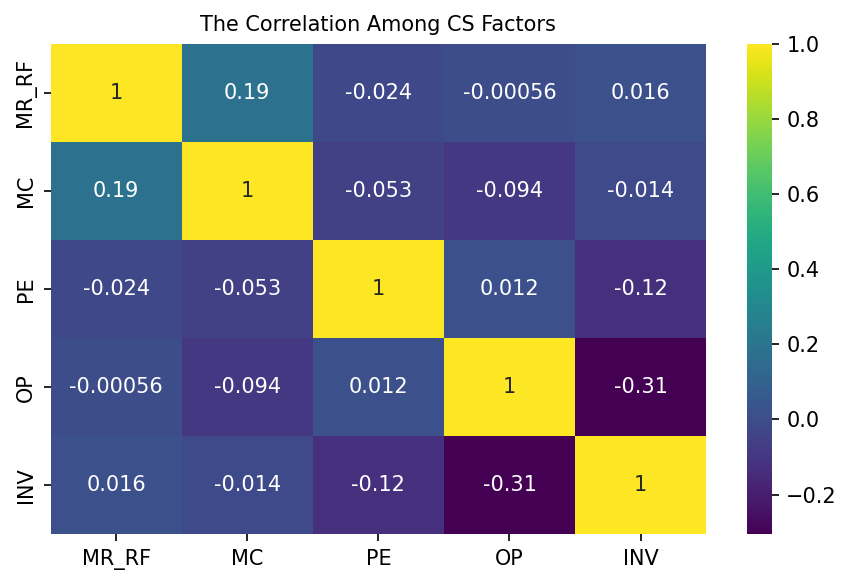

In [466]:
# Plot the correlation among CS factors
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
corrMatrix = df_CS_FF5.corr()
sn.heatmap(corrMatrix, annot=True, cmap="viridis")
plt.title('The Correlation Among CS Factors', fontsize=10)
plt.show()

In [467]:
# FF5CS-Factor Time Series Regression with Newey-West Adjustment
df_Ex_SR_trnct = df_Ex_SR_tmp.loc[df_CS_FF5.index,:]

all_betas = []
all_std_errs = []
all_Rs_CS = []
all_sd_res_CS = []

betas = []
labels = []
std_errs = []
Rs = []
sd_res = []

for j in tqdm(df_Ex_SR.columns):

    df_index = (df_Ex_SR_trnct.loc[:, j].dropna(
    ).index).intersection(df_CS_FF5.index)

    if len(df_index) > 10:
        lag = int(4*((len(df_Ex_SR_trnct.loc[df_index, j]))/100)**(1/9))
        ols = sm.OLS(df_Ex_SR_trnct.loc[df_index, j].astype(np.float64), sm.add_constant(
            df_CS_FF5.loc[df_index, :].astype(np.float64)))
        res = ols.fit()
        res = ols.fit(cov_type='HAC', cov_kwds={'maxlags': lag})
        b = list(res.params)
        se = list(res.bse)
        r = res.rsquared
        sr = res.resid.std()
        betas.append(b)
        std_errs.append(se)
        Rs.append(r)
        sd_res.append(sr)
        labels.append(j)

all_betas.append(pd.DataFrame(betas))
all_std_errs.append(pd.DataFrame(std_errs))
all_Rs_CS.append(pd.DataFrame(Rs))
all_sd_res_CS.append(pd.DataFrame(sd_res))

100%|██████████| 740/740 [00:03<00:00, 209.26it/s]


In [468]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ZSA.SJ.Equity   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.194
Date:                Mon, 02 May 2022   Prob (F-statistic):            0.00706
Time:                        14:28:09   Log-Likelihood:                 7119.8
No. Observations:                2330   AIC:                        -1.423e+04
Df Residuals:                    2324   BIC:                        -1.419e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.756      0.449      -0.000       0.001
MR_RF          0.0023      0.016      0.141      0.888      -0.030       0.034
MC             0.4594      0.148      3.096      0.002       0.169       0.750
PE            -0.2250      0.147     -1.530      0.126      -0.513       0.063
OP             0.1526      0.162      0.944      0.345      -0.164       0.469
INV           -0.2272      0.170     -1.337      0.181      -0.560       0.106
==============================================================================
Omnibus:                      403.554   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7124.507
Skew:                           0.247   Prob(JB):                         0.00
Kurtosis:                      11.552   Cond. No.                         857.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

In [469]:
df_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
df_betas.columns = ['Intercepts','MKT','Size','PE','OP','INV','Stocks']
df_betas = df_betas.set_index('Stocks')
df_betas

,Intercepts,MKT,Size,PE,OP,INV
Stocks,,,,,,
ABC.SJ.Equity,-0.004325,-0.248432,-2.730005,10.159118,-2.269599,3.260497
ABI.SJ.Equity,0.000279,0.257368,-0.257265,0.107787,-0.032924,-0.005279
ABK.SJ.Equity,-0.002682,0.358309,-1.164554,1.546209,-2.253111,5.235294
ABR.SJ.Equity,-0.005241,-0.274367,1.832379,-2.094345,-11.149353,-3.270059
ABU.SJ.Equity,-0.000561,0.015447,0.098374,-1.003282,0.494684,-0.768725
...,...,...,...,...,...,...
ZGOVI.SJ.Equity,0.000049,0.048153,-0.091700,-0.018617,-0.084377,-0.100206
ZPT.SJ.Equity,-0.002852,0.057928,0.596077,-1.840239,1.077203,-0.058892
ZRNHDG.SJ.Equity,-0.000359,0.035943,-0.134916,-0.047623,0.139875,0.187090


In [470]:
## The alphas are missing pricing errors of asset pricing model (FF5-Factor), which are also the intercepts of time series regression
alphas = df_betas.iloc[:,0]
alphas.describe()

count    708.000000
mean      -0.000730
std        0.002423
min       -0.019595
25%       -0.000807
50%       -0.000082
75%        0.000254
max        0.006763
Name: Intercepts, dtype: float64

In [471]:
df_SE = pd.concat([all_std_errs[0], pd.DataFrame(labels)], axis = 1)
df_SE.columns = ['Intercepts','MKT','Size','PE','OP','INV','Stocks']
df_SE = df_SE.set_index('Stocks')
df_SE

,Intercepts,MKT,Size,PE,OP,INV
Stocks,,,,,,
ABC.SJ.Equity,0.002707,0.337316,2.272346,2.443091,2.353905,2.168639
ABI.SJ.Equity,0.000314,0.036232,0.245011,0.249669,0.250772,0.248737
ABK.SJ.Equity,0.001615,0.144007,1.681711,1.700741,1.917492,2.282287
ABR.SJ.Equity,0.003541,0.402458,4.029085,3.114477,3.913463,3.427452
ABU.SJ.Equity,0.000615,0.044076,0.437086,0.608929,0.581706,0.508304
...,...,...,...,...,...,...
ZGOVI.SJ.Equity,0.000106,0.011292,0.082367,0.080439,0.079980,0.072178
ZPT.SJ.Equity,0.001317,0.162495,1.399618,1.422461,1.512068,1.315880
ZRNHDG.SJ.Equity,0.000341,0.020035,0.193914,0.242580,0.275241,0.265581


In [472]:
alphas_se = df_SE.iloc[:,0]
alphas_se.describe()

count    708.000000
mean       0.000781
std        0.000836
min        0.000008
25%        0.000287
50%        0.000514
75%        0.000963
max        0.009188
Name: Intercepts, dtype: float64

In [473]:
## Alpha Test (Fama & French, 2020)
### Step 1: Calculate t-statistics of alphas by using the formula: t-stats,i = alphas,i/s.e.(alphas,i)
alphas_t = alphas/alphas_se
alphas_t = alphas_t.replace(-np.inf,np.nan)
alphas_t.describe()

count    708.000000
mean      -0.337431
std        1.696897
min       -9.297348
25%       -1.155181
50%       -0.259634
75%        0.649072
max        7.757986
Name: Intercepts, dtype: float64

In [474]:
pd.DataFrame(alphas_t)

,Intercepts
Stocks,
ABC.SJ.Equity,-1.597882
ABI.SJ.Equity,0.887984
ABK.SJ.Equity,-1.660541
ABR.SJ.Equity,-1.480029
ABU.SJ.Equity,-0.912694
...,...
ZGOVI.SJ.Equity,0.461231
ZPT.SJ.Equity,-2.166085
ZRNHDG.SJ.Equity,-1.053322


#### Results_3

In [475]:
### Calculate the absolute value of alphas and alphas_t, then calculate their mean respectively
print(np.mean(abs(alphas))*21*100,np.nanmean(abs(alphas_t)))

2.446357442083511 1.2328176016475354


In [476]:
### Calculate the cross-sectional variance of LHS average returns and then divided by the mean of squared alphas
cs_var = np.var(df_SR_tmp.apply(lambda x: np.mean(x), axis = 0))
print(np.mean(np.square(alphas))/cs_var)

0.9278182908207693


In [477]:
### Substract the squared standard error of each intercept to adjust for the noise in the Step-3
A_lamda = np.mean((pd.DataFrame(np.square(alphas).values)-pd.DataFrame(np.square(alphas_se).values)), axis = 0)
print(A_lamda/cs_var)

0    0.738165
dtype: float64


In [478]:
### The average of the regression R^2; the average of the standard errors of the intercepts; 
### The average of the standard deviations of the regression residuals.
print('AR^2: ' + str(np.mean(all_Rs_CS)), 'As(a): ' + str(np.nanmean(alphas_se.values)*np.sqrt(21)), \
      'As(e): ' + str(np.mean(all_sd_res_CS)*np.sqrt(21)))

AR^2: 0.07052810174866636 As(a): 0.0035780121170143437 As(e): 0.12830883906608437


In [479]:
## Calculate Cross-sectional R-squared, how much the total variance of expected stock returns can be explained by the model?
1-(np.var(alphas)/np.var(df_Ex_SR_tmp.mean()))

0.156721273543302